# Adaptive Kernel-Based Approximation for Efficient LLM Reranking

## Introduction

This notebook implements the approach described in "Adaptive Kernel-Based Approximation for Efficient LLM Reranking in RAG Pipelines" by Thomas Bordino. The technique leverages Nyström kernel approximation to reduce the computational complexity of reranking in retrieval-augmented generation (RAG) systems.

Reranking is a critical component of RAG pipelines that often becomes a computational bottleneck as systems scale. This implementation demonstrates how to approximate the pairwise scoring function of rerankers in a low-dimensional subspace, achieving significant speedups while maintaining high correlation with exact computation results.

The core insight of this approach is that similarity relationships between documents and queries often exist in a much lower-dimensional manifold than the original embedding space. By identifying a small set of landmark documents that effectively span this manifold, we can approximate similarity computations with remarkable fidelity while reducing computational complexity from O(nd) to O(md), where n is the number of documents, d is the embedding dimension, and m ≪ n is the number of landmarks.

This notebook evaluates three landmark selection strategies on the MS MARCO dataset:
1. Uniform random sampling
2. K-means clustering
3. Determinantal point processes (DPP)

Each strategy offers different tradeoffs between computational efficiency and ranking quality preservation. Throughout this implementation, we'll measure:
- Computational efficiency (ranking time speedup)
- Retrieval quality (ranking correlation, top-k overlap)
- Performance characteristics across different landmark selection methods



### Uniform Random Sampling

Uniform Random Sampling is the simplest landmark selection approach, choosing documents randomly from the collection without any special criteria. This method:

- Selects m landmarks uniformly at random from the full document set D
- Offers computational efficiency with minimal selection overhead
- Provides a baseline comparison for more sophisticated strategies
- Does not guarantee that selected documents will represent the underlying data structure well
- May perform poorly for clustered or non-uniform document distributions

Despite its simplicity, uniform sampling can be surprisingly effective, especially as the number of landmarks increases. It serves as an important baseline in our experiments.



Using device: cpu
Loading sentence-transformers/all-MiniLM-L6-v2 model...
Loading MS MARCO data...
Loaded 5793 queries
Found 10000 unique document IDs
Created 10000 document entries
Loaded 5793 queries and 10000 documents
SHARED PHASE: Encoding all documents (used by both methods)...


Encoding documents: 100%|██████████| 10000/10000 [06:40<00:00, 24.99it/s]


Encoded 10000 documents in 400.15 seconds
Average time per document: 0.04001 seconds

Comparing bi-encoder and Nyström methods for multiple landmark counts...
SHARED PHASE: Encoding all queries (used by both methods)...


Encoding queries: 100%|██████████| 5793/5793 [04:16<00:00, 22.59it/s]


Encoded 5793 queries in 256.39 seconds
Average time per query: 0.04426 seconds
BIENCODER OFFLINE PHASE: Nothing to do (embeddings already computed)
Running bi-encoder retrieval for 5793 queries...


Bi-encoder retrieval: 100%|██████████| 5793/5793 [01:17<00:00, 75.21it/s]



Testing with 10 landmarks...
NYSTROM OFFLINE PHASE: Setting up with 10 random landmarks...
Nyström setup completed in 0.04 seconds


Nyström-10 retrieval: 100%|██████████| 5793/5793 [00:56<00:00, 102.94it/s]



Testing with 25 landmarks...
NYSTROM OFFLINE PHASE: Setting up with 25 random landmarks...
Nyström setup completed in 0.02 seconds


Nyström-25 retrieval: 100%|██████████| 5793/5793 [00:58<00:00, 99.78it/s] 



Testing with 50 landmarks...
NYSTROM OFFLINE PHASE: Setting up with 50 random landmarks...
Nyström setup completed in 0.04 seconds


Nyström-50 retrieval: 100%|██████████| 5793/5793 [00:57<00:00, 100.70it/s]



Testing with 75 landmarks...
NYSTROM OFFLINE PHASE: Setting up with 75 random landmarks...
Nyström setup completed in 0.02 seconds


Nyström-75 retrieval: 100%|██████████| 5793/5793 [00:57<00:00, 100.16it/s]


<Figure size 640x480 with 0 Axes>

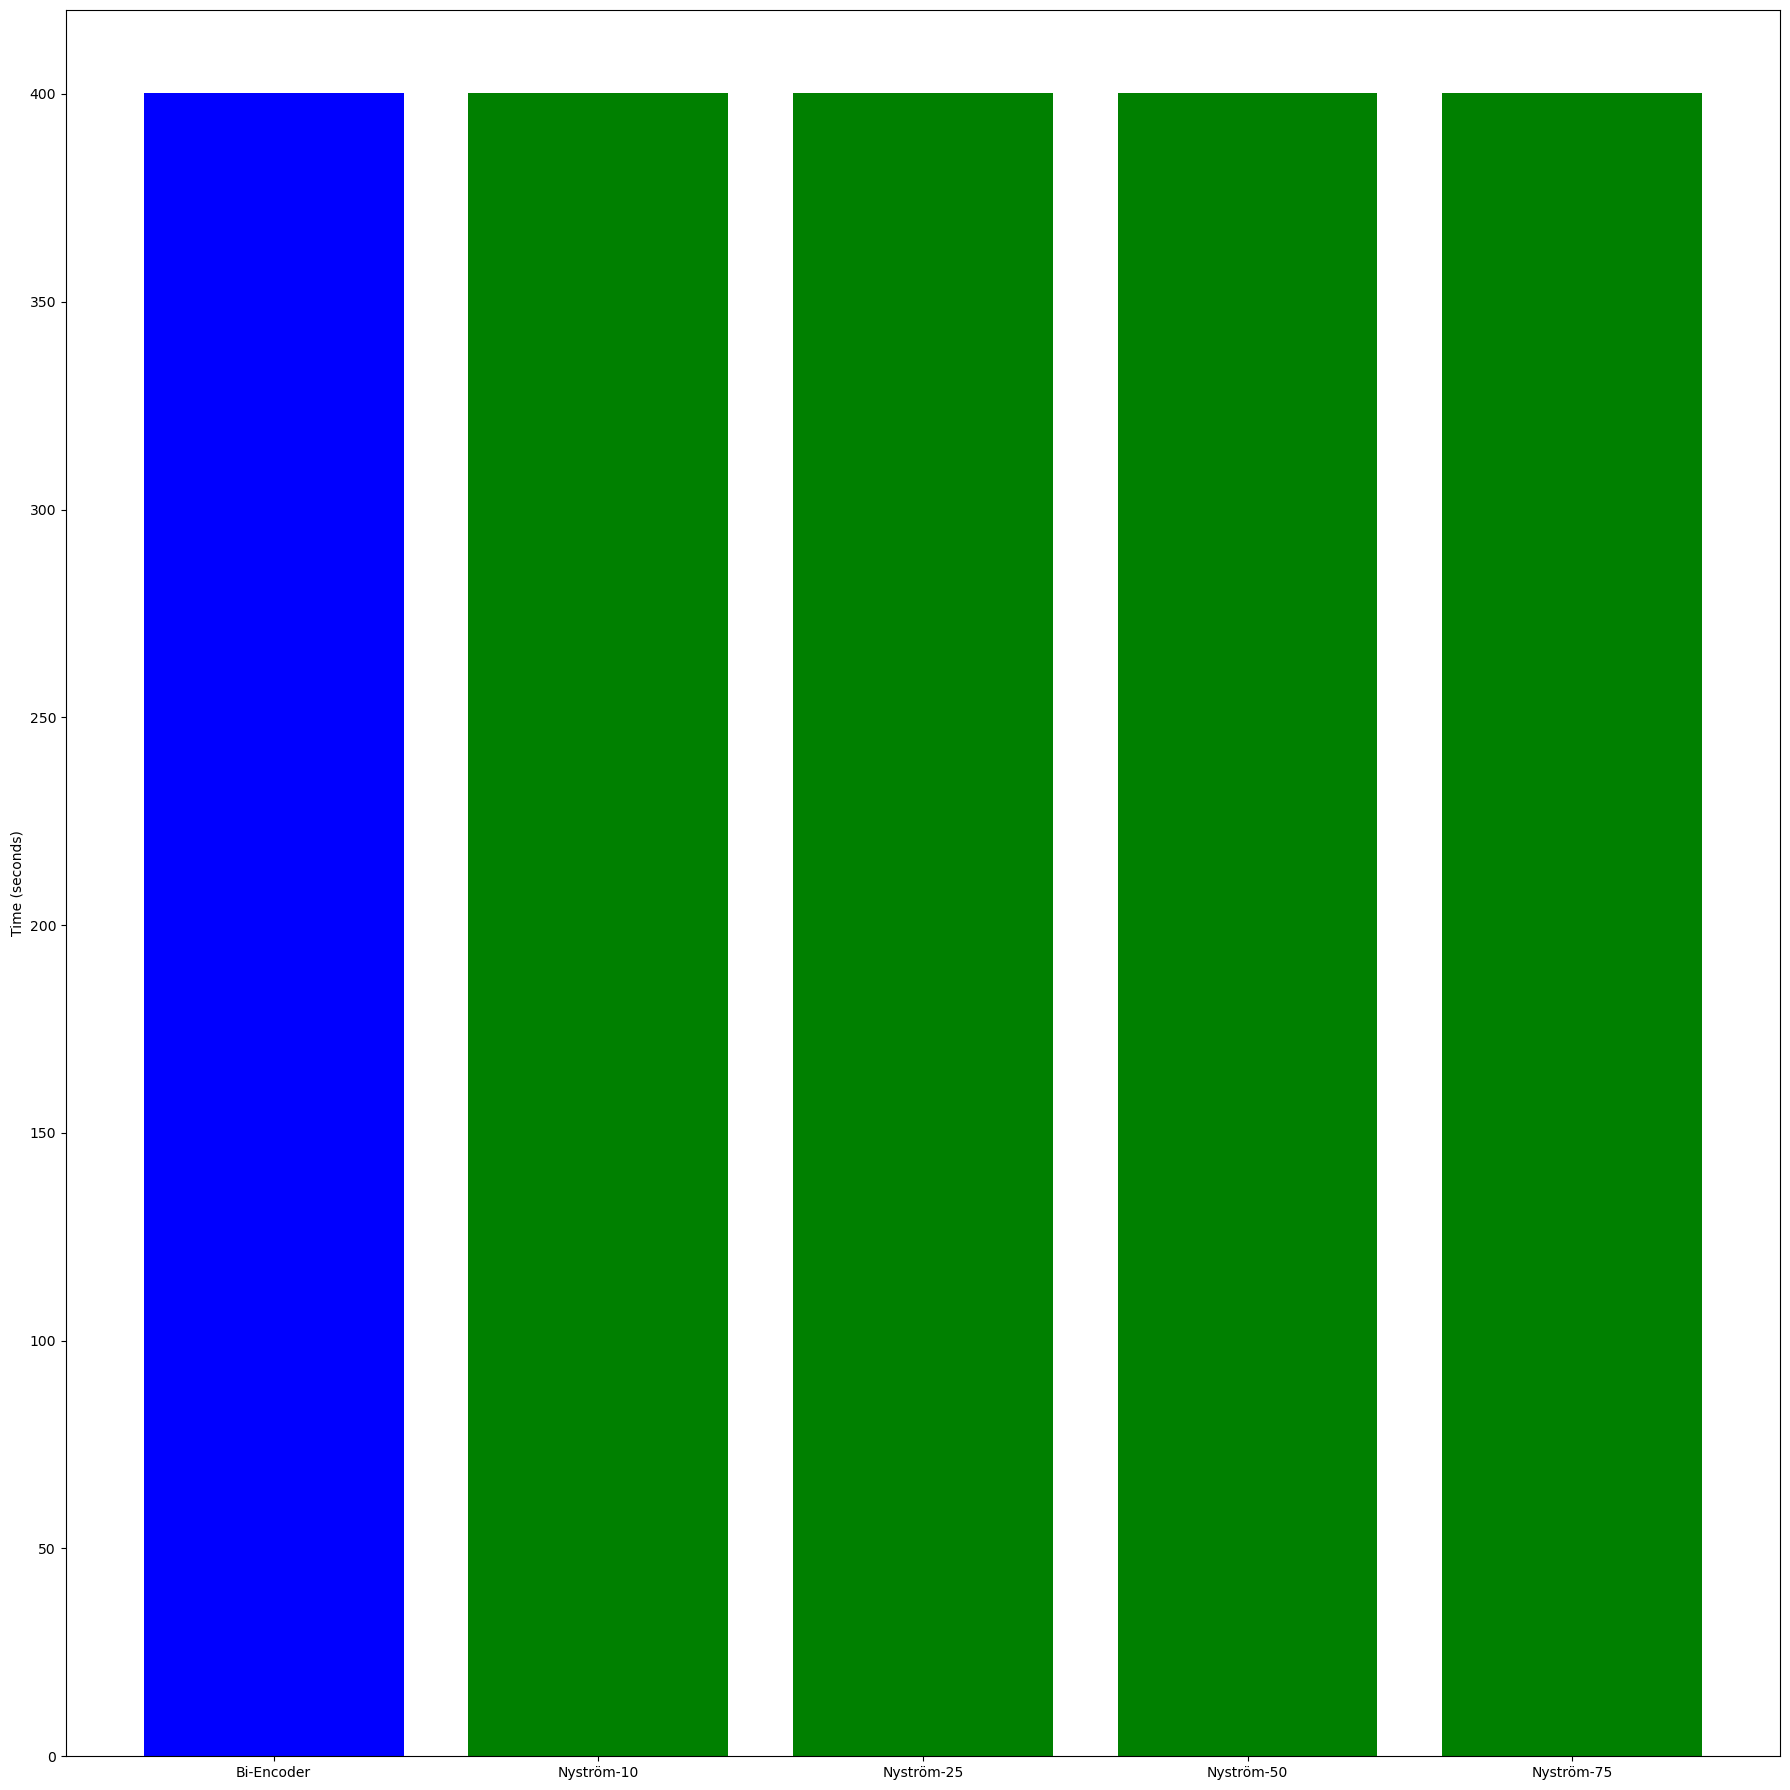

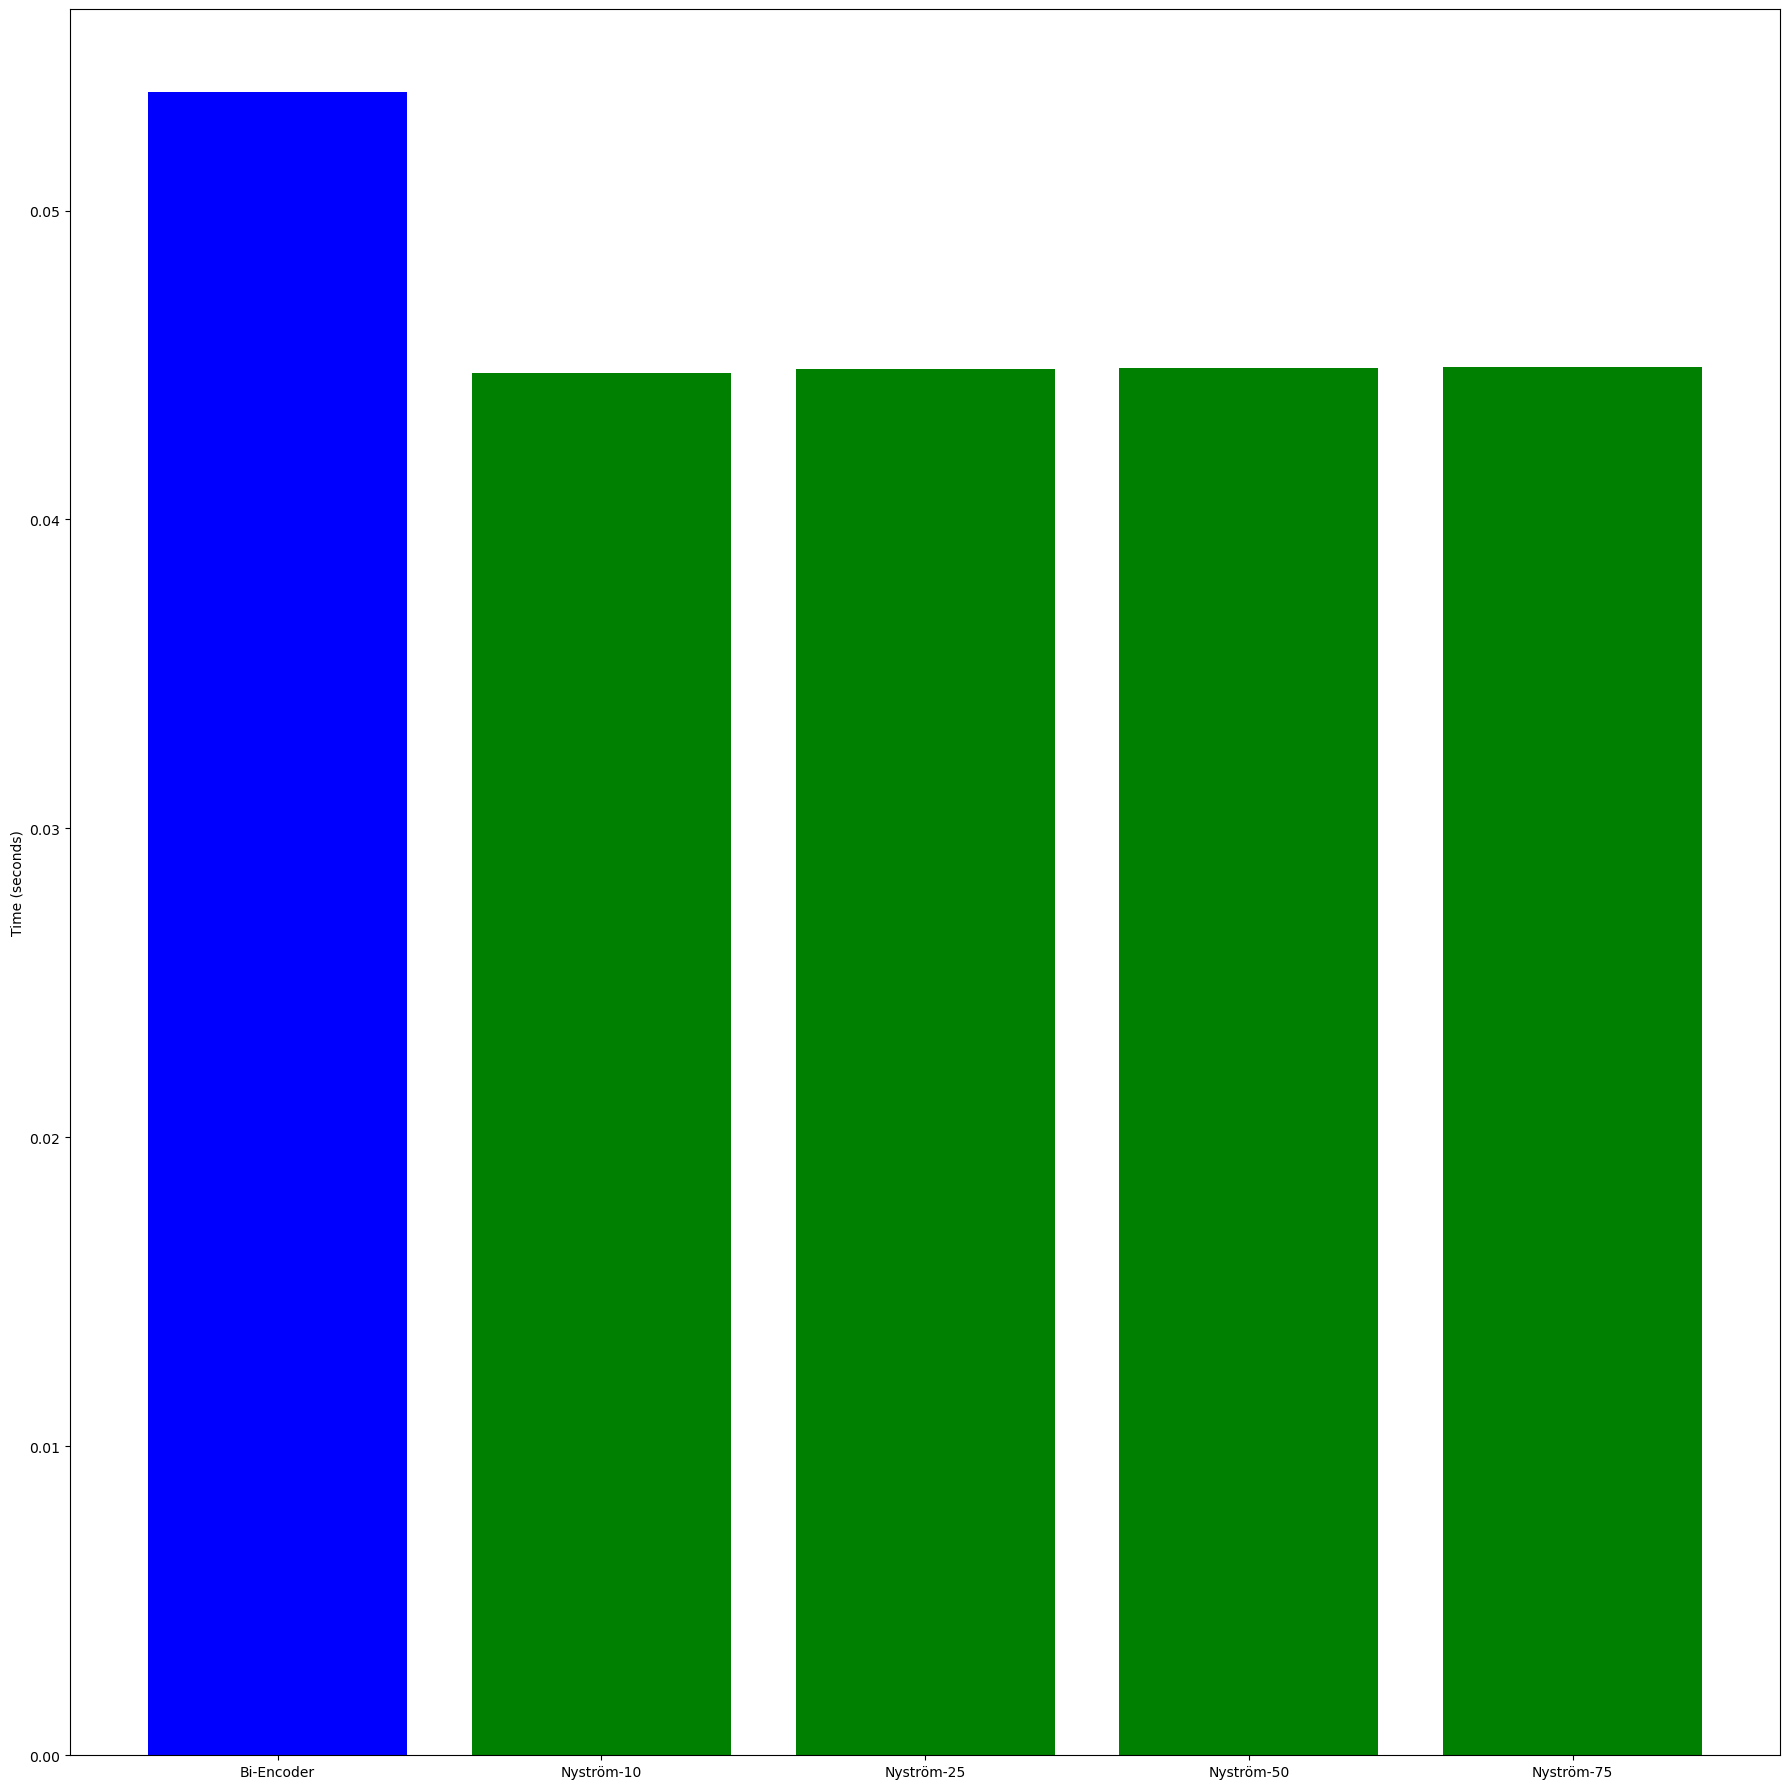

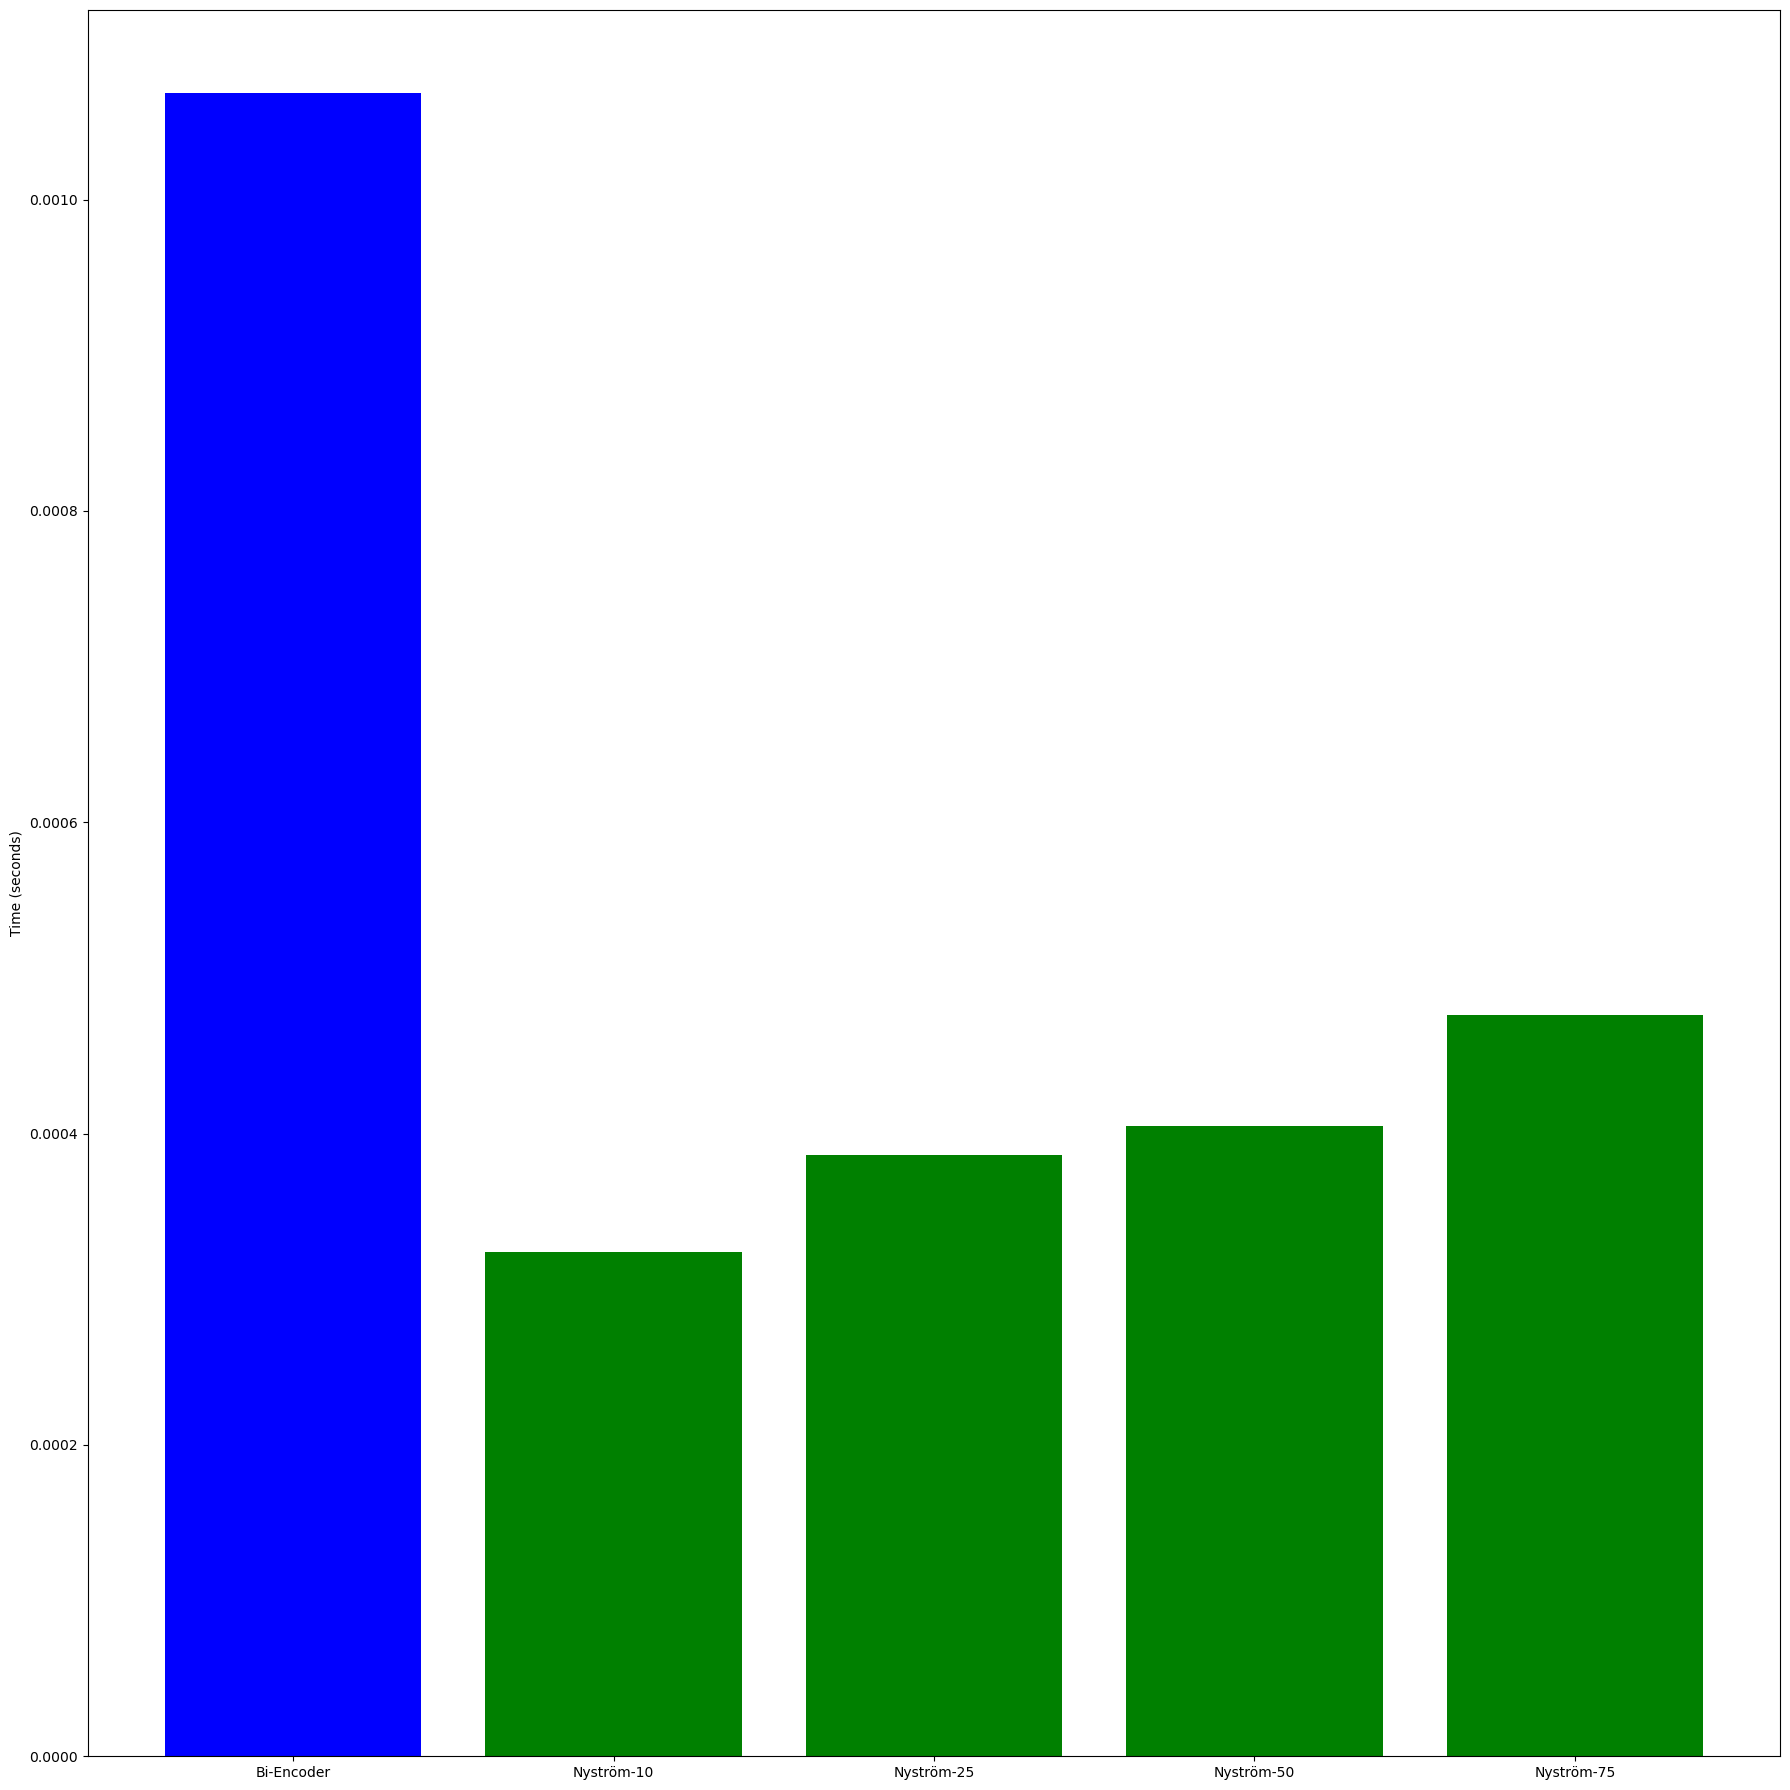

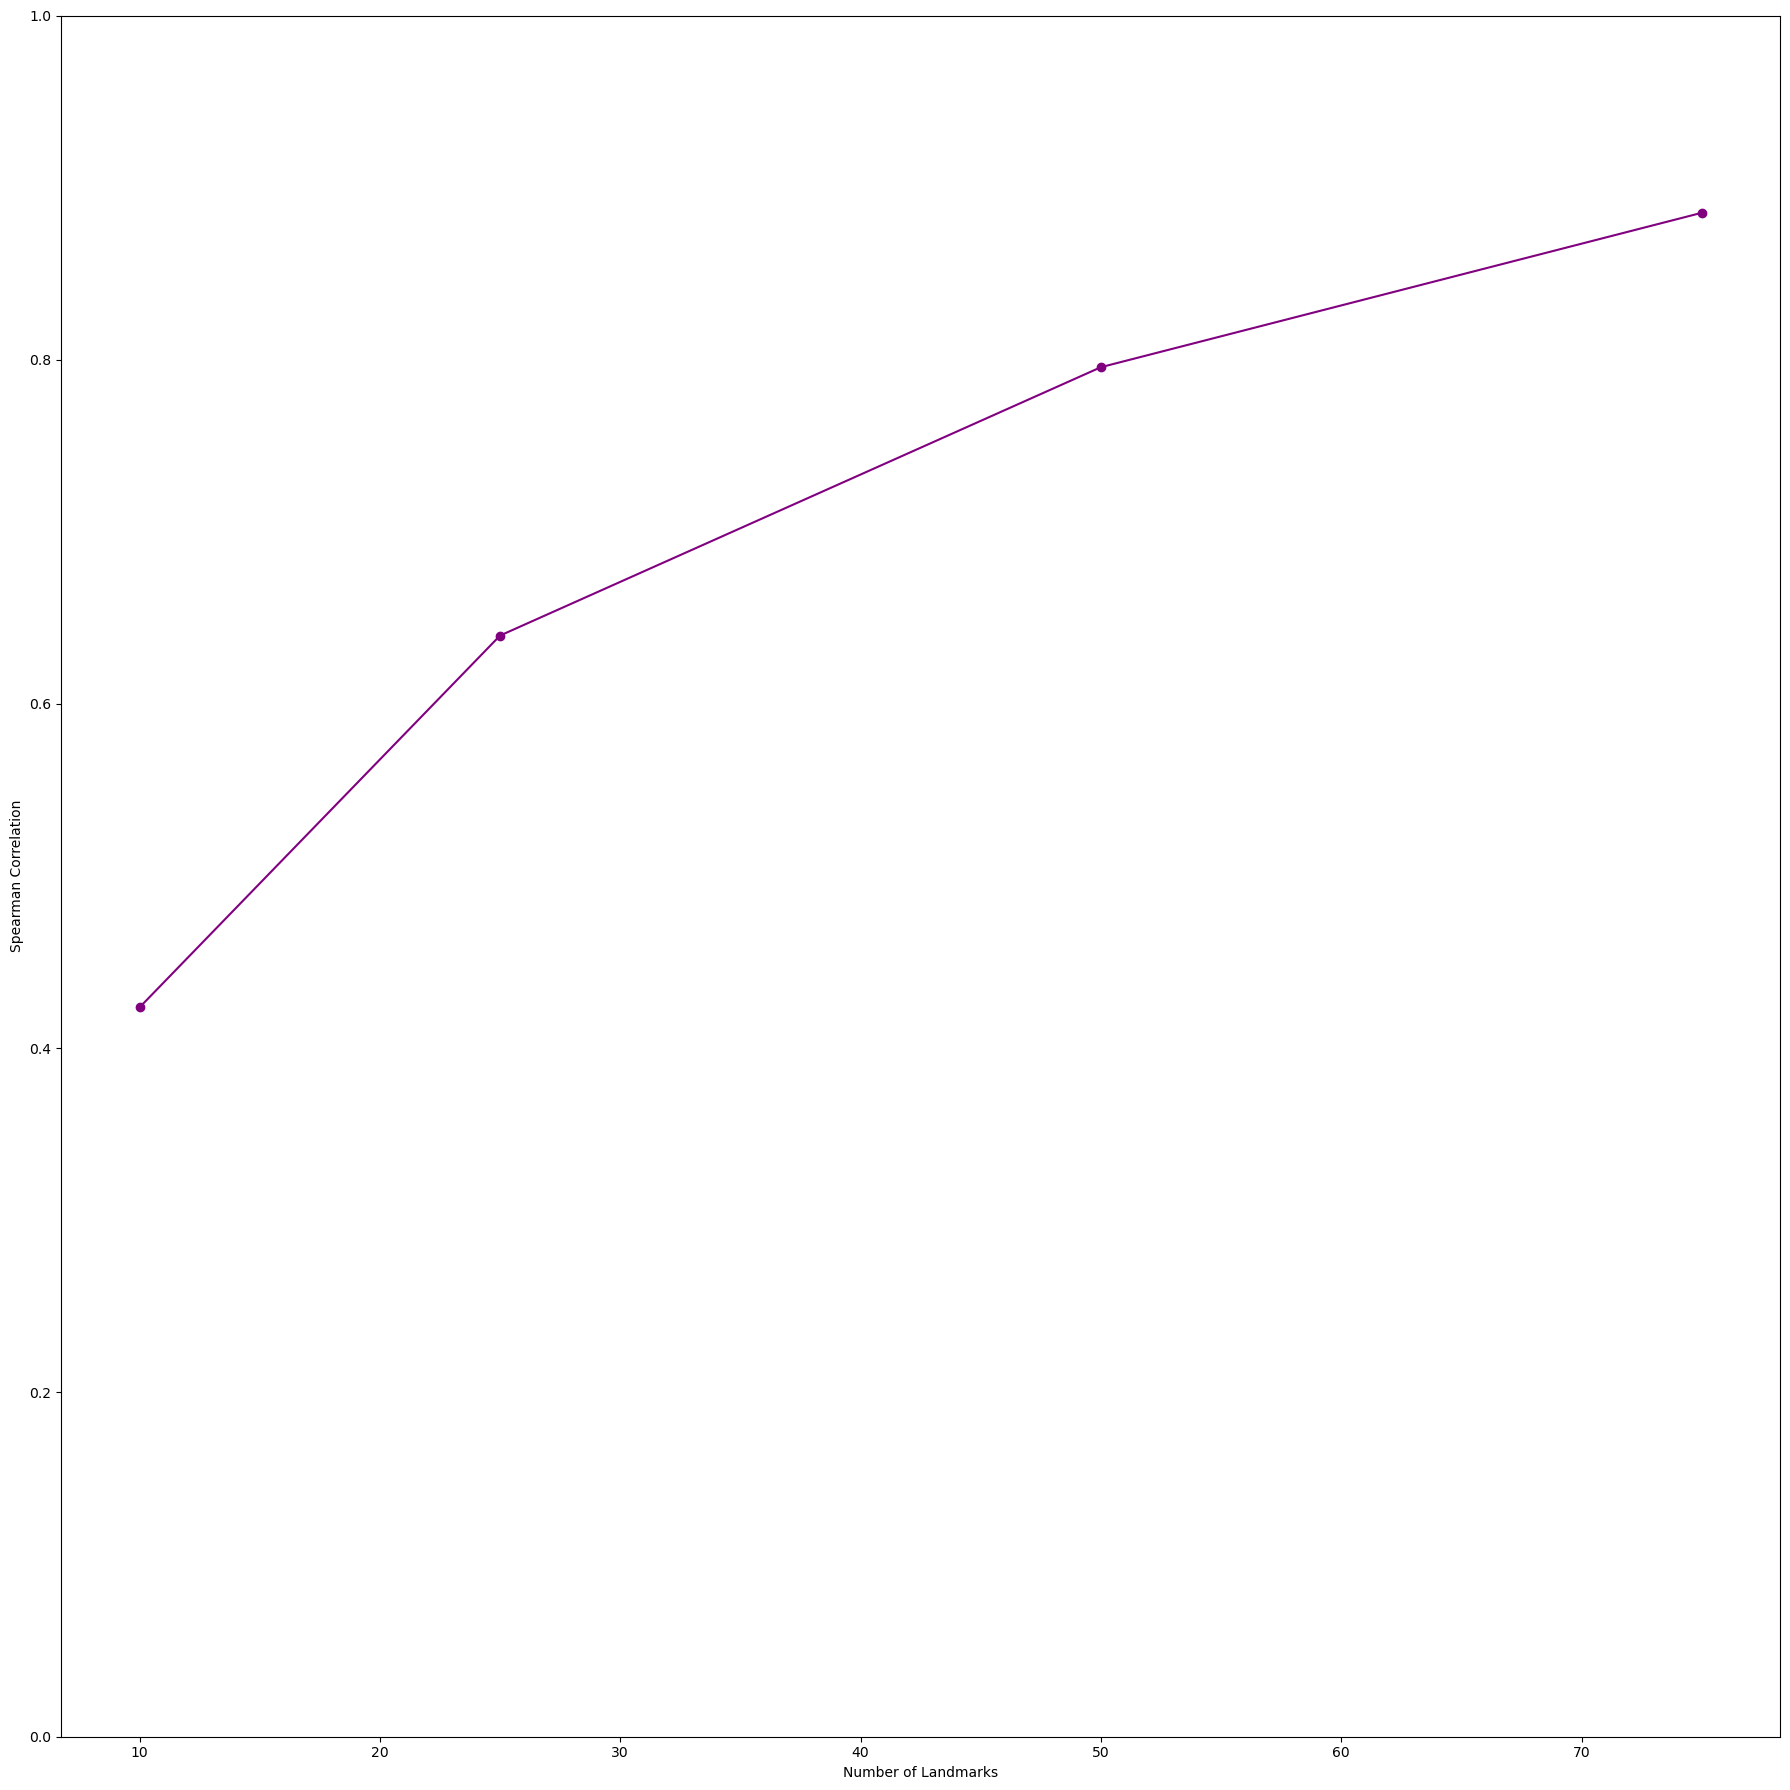

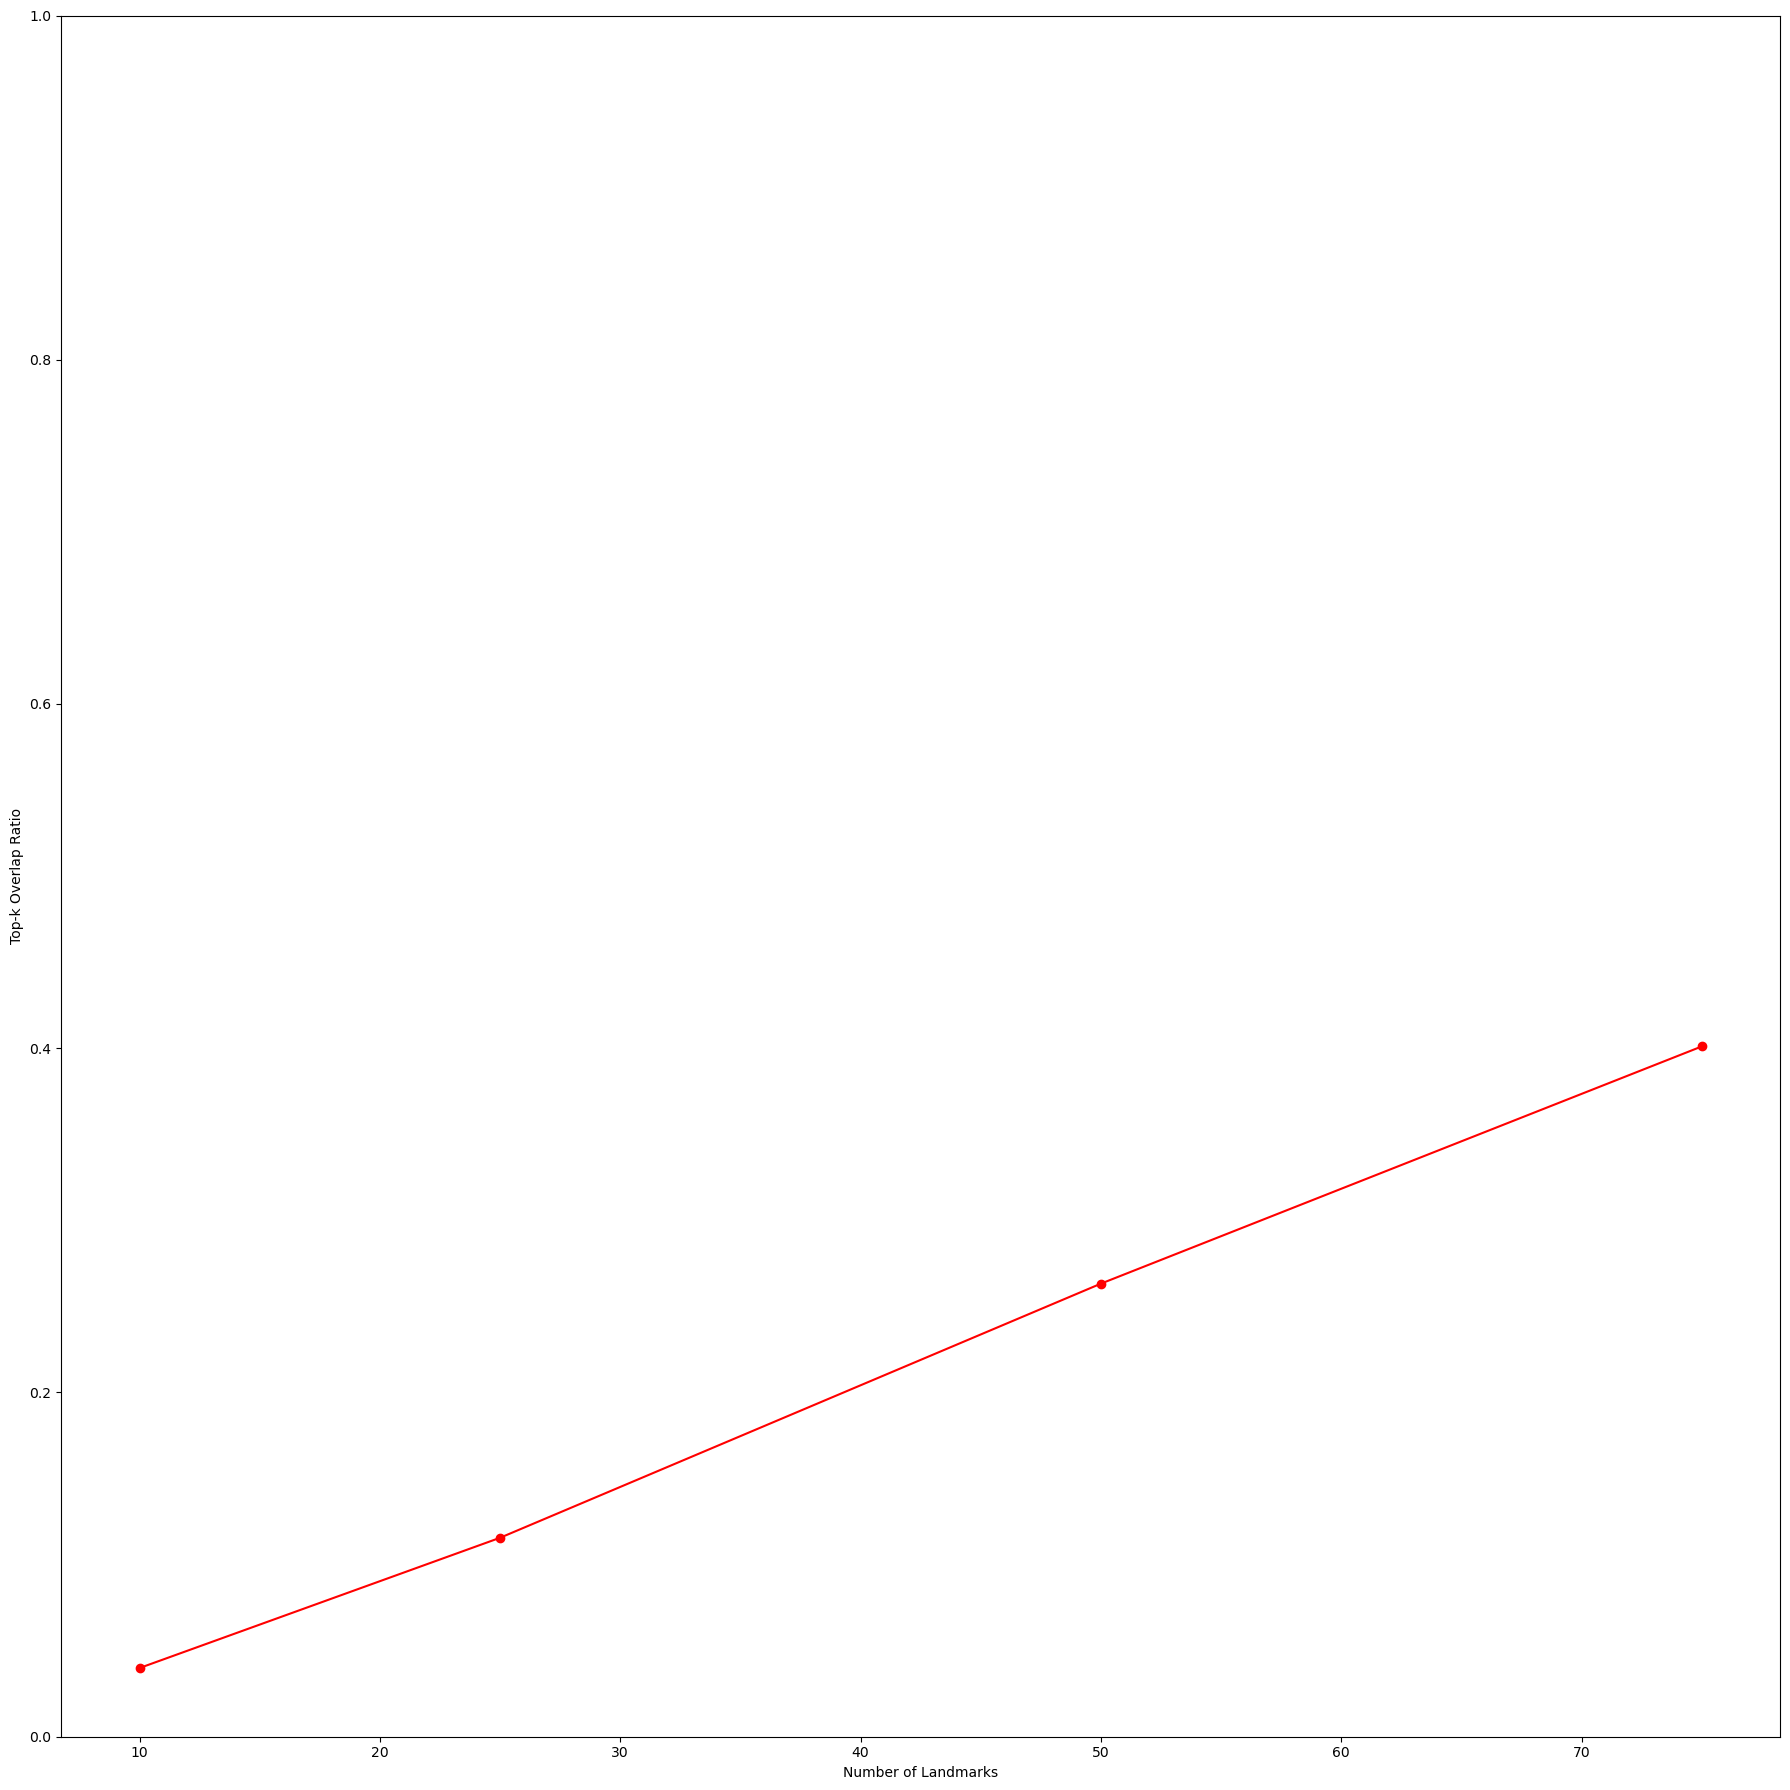

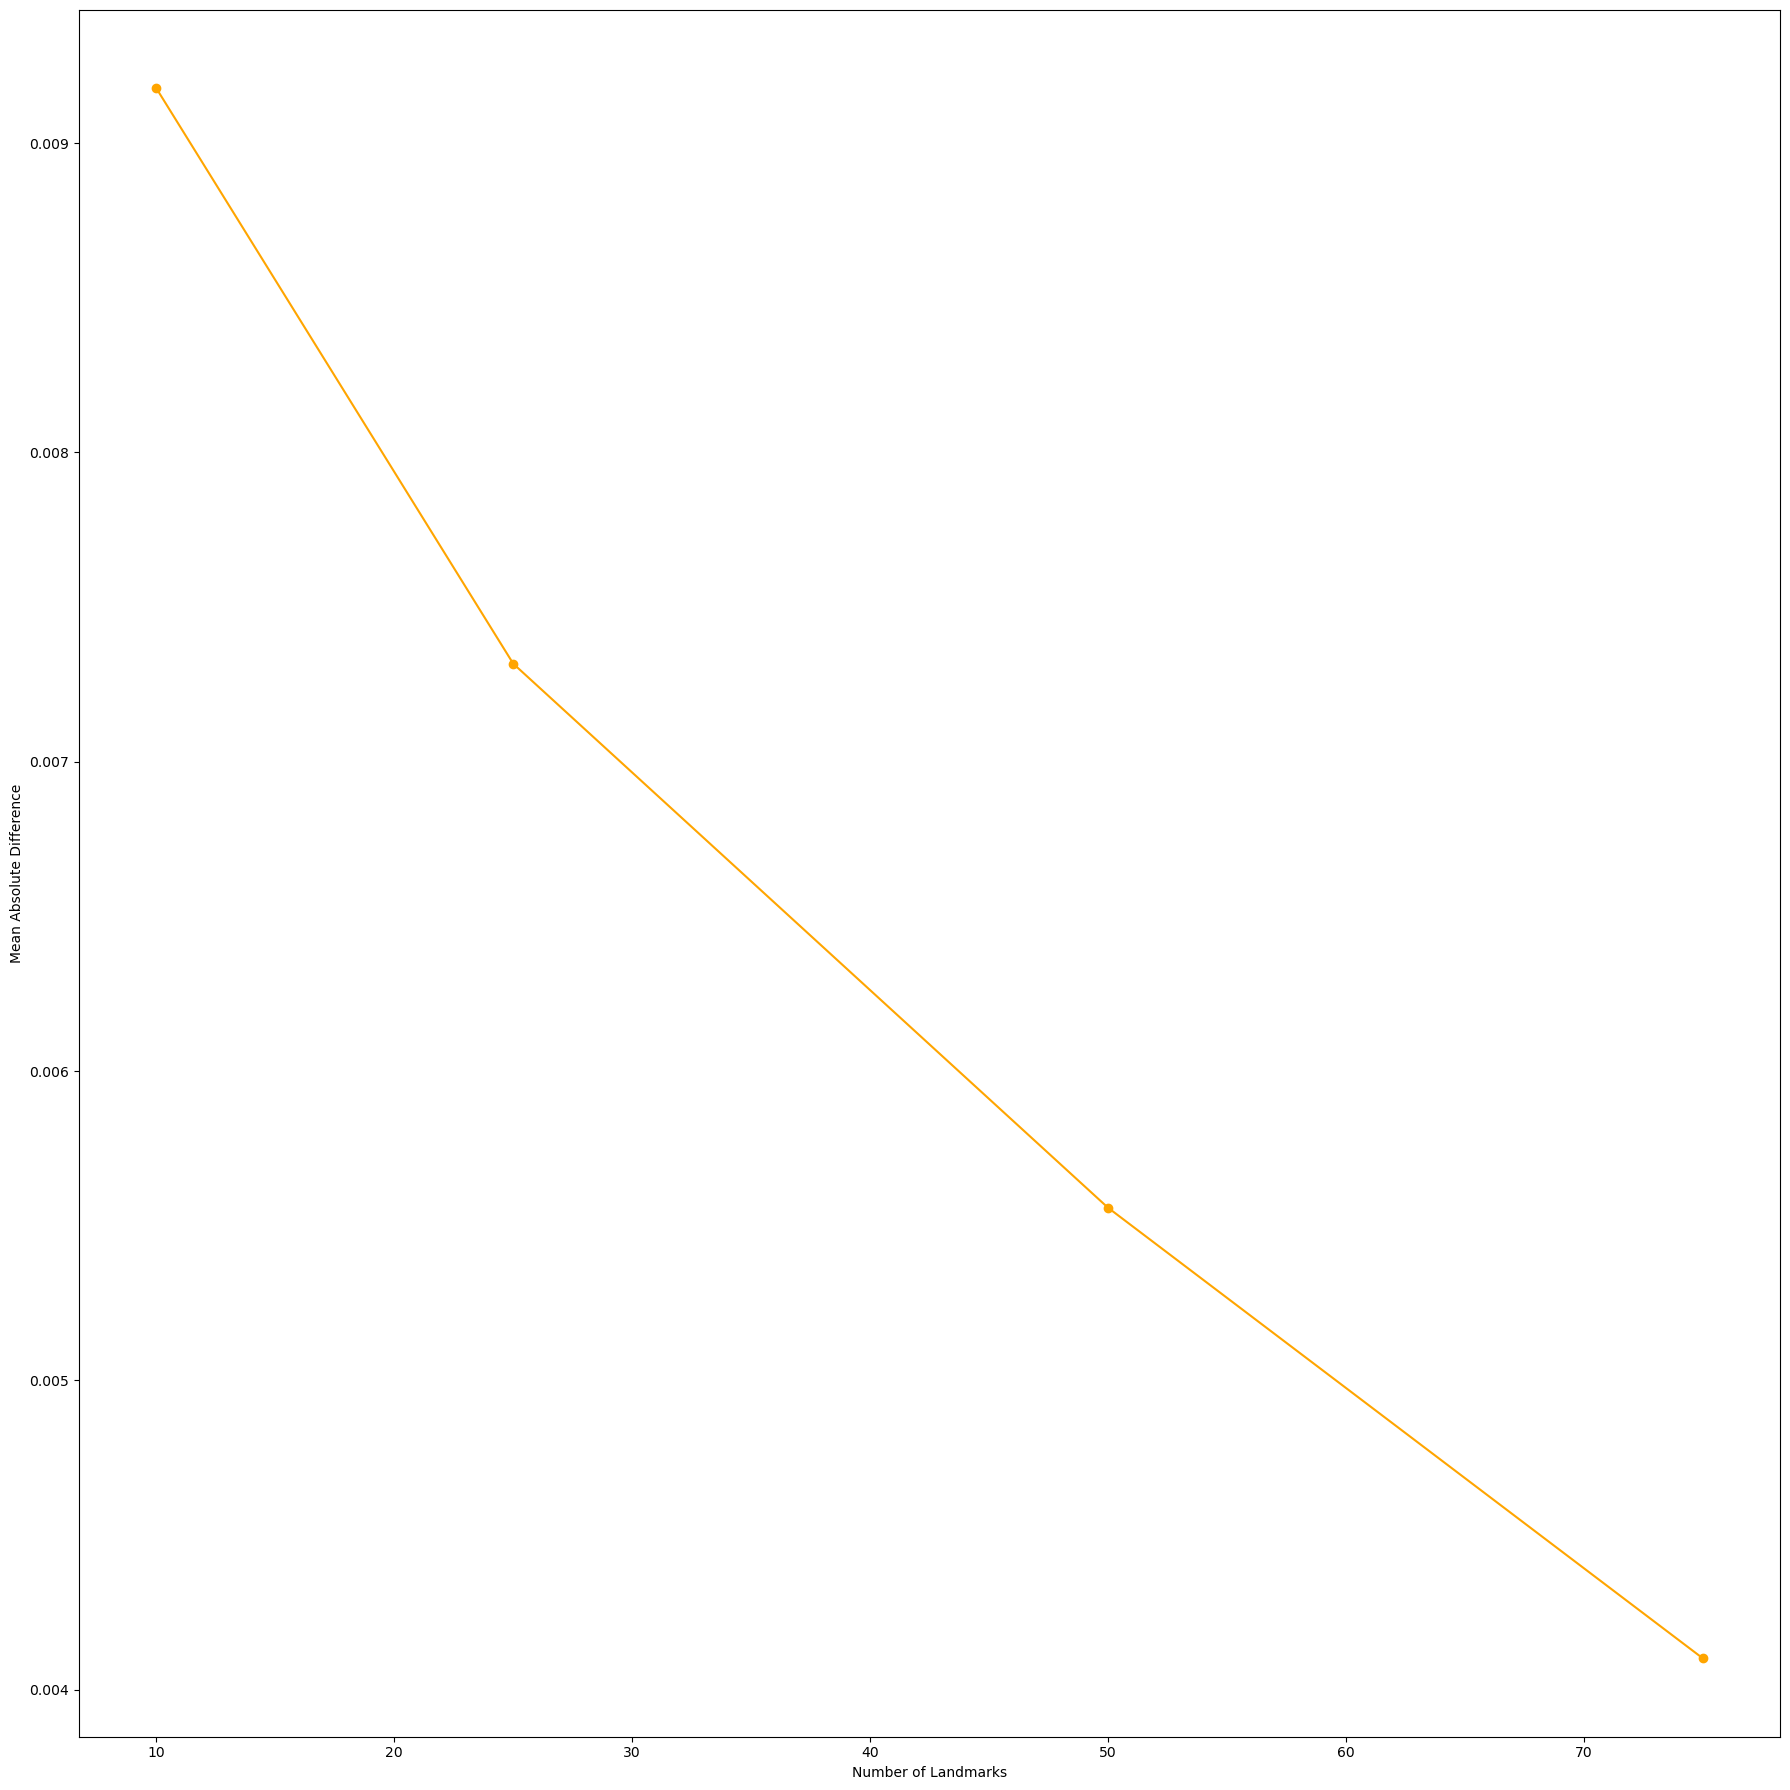

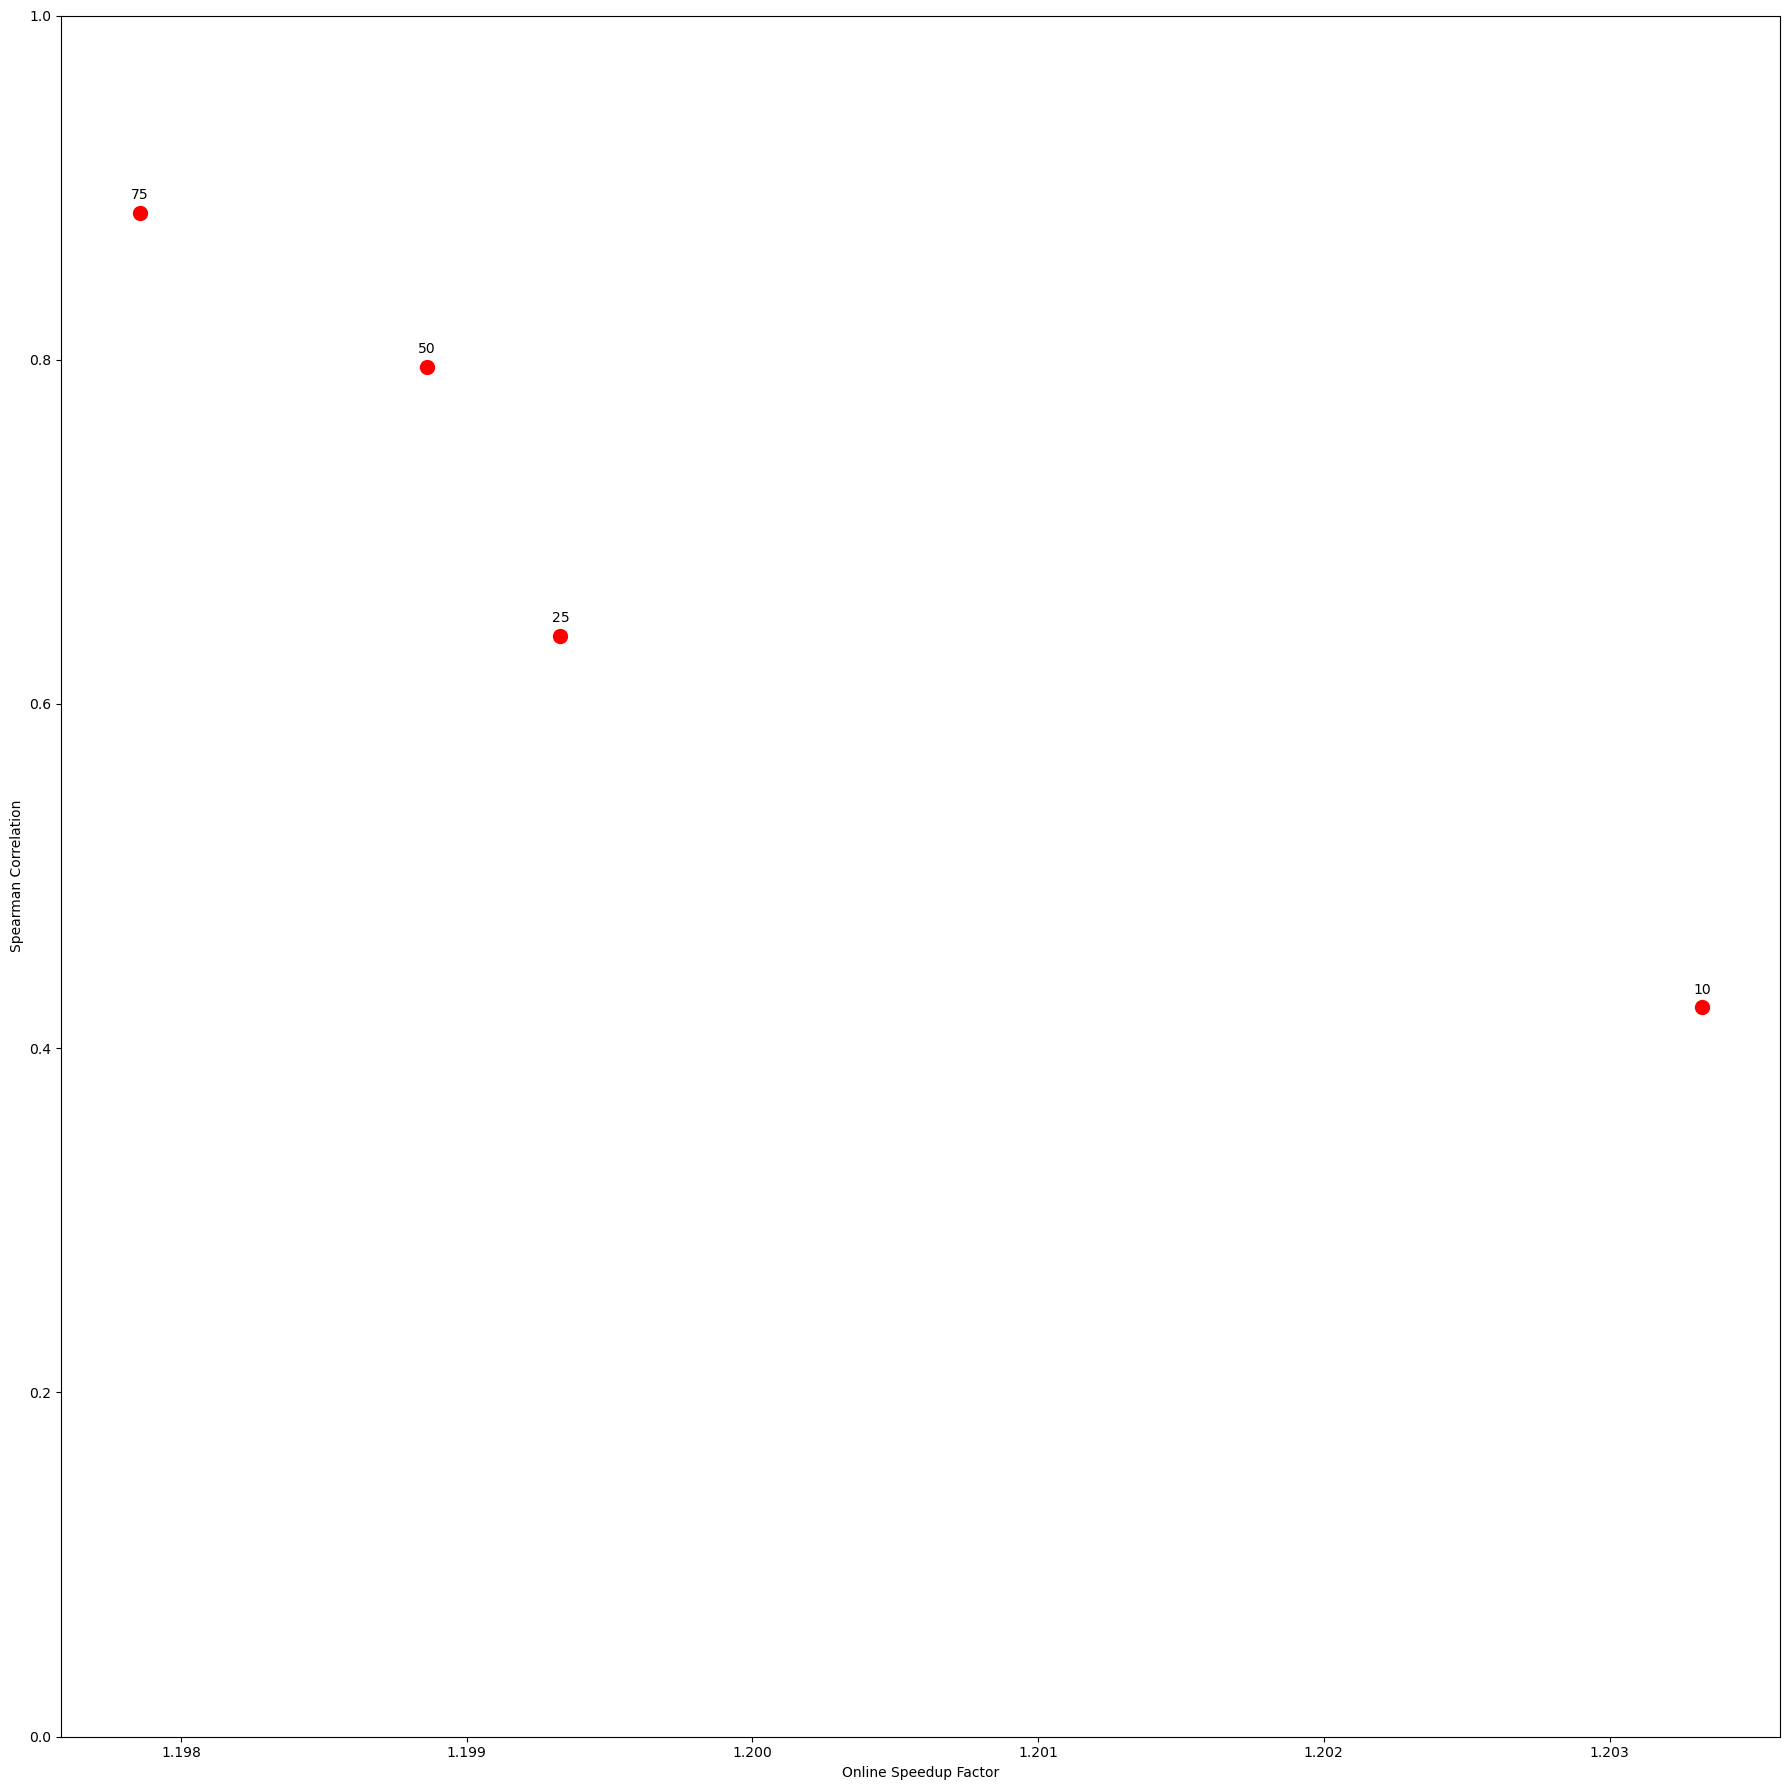

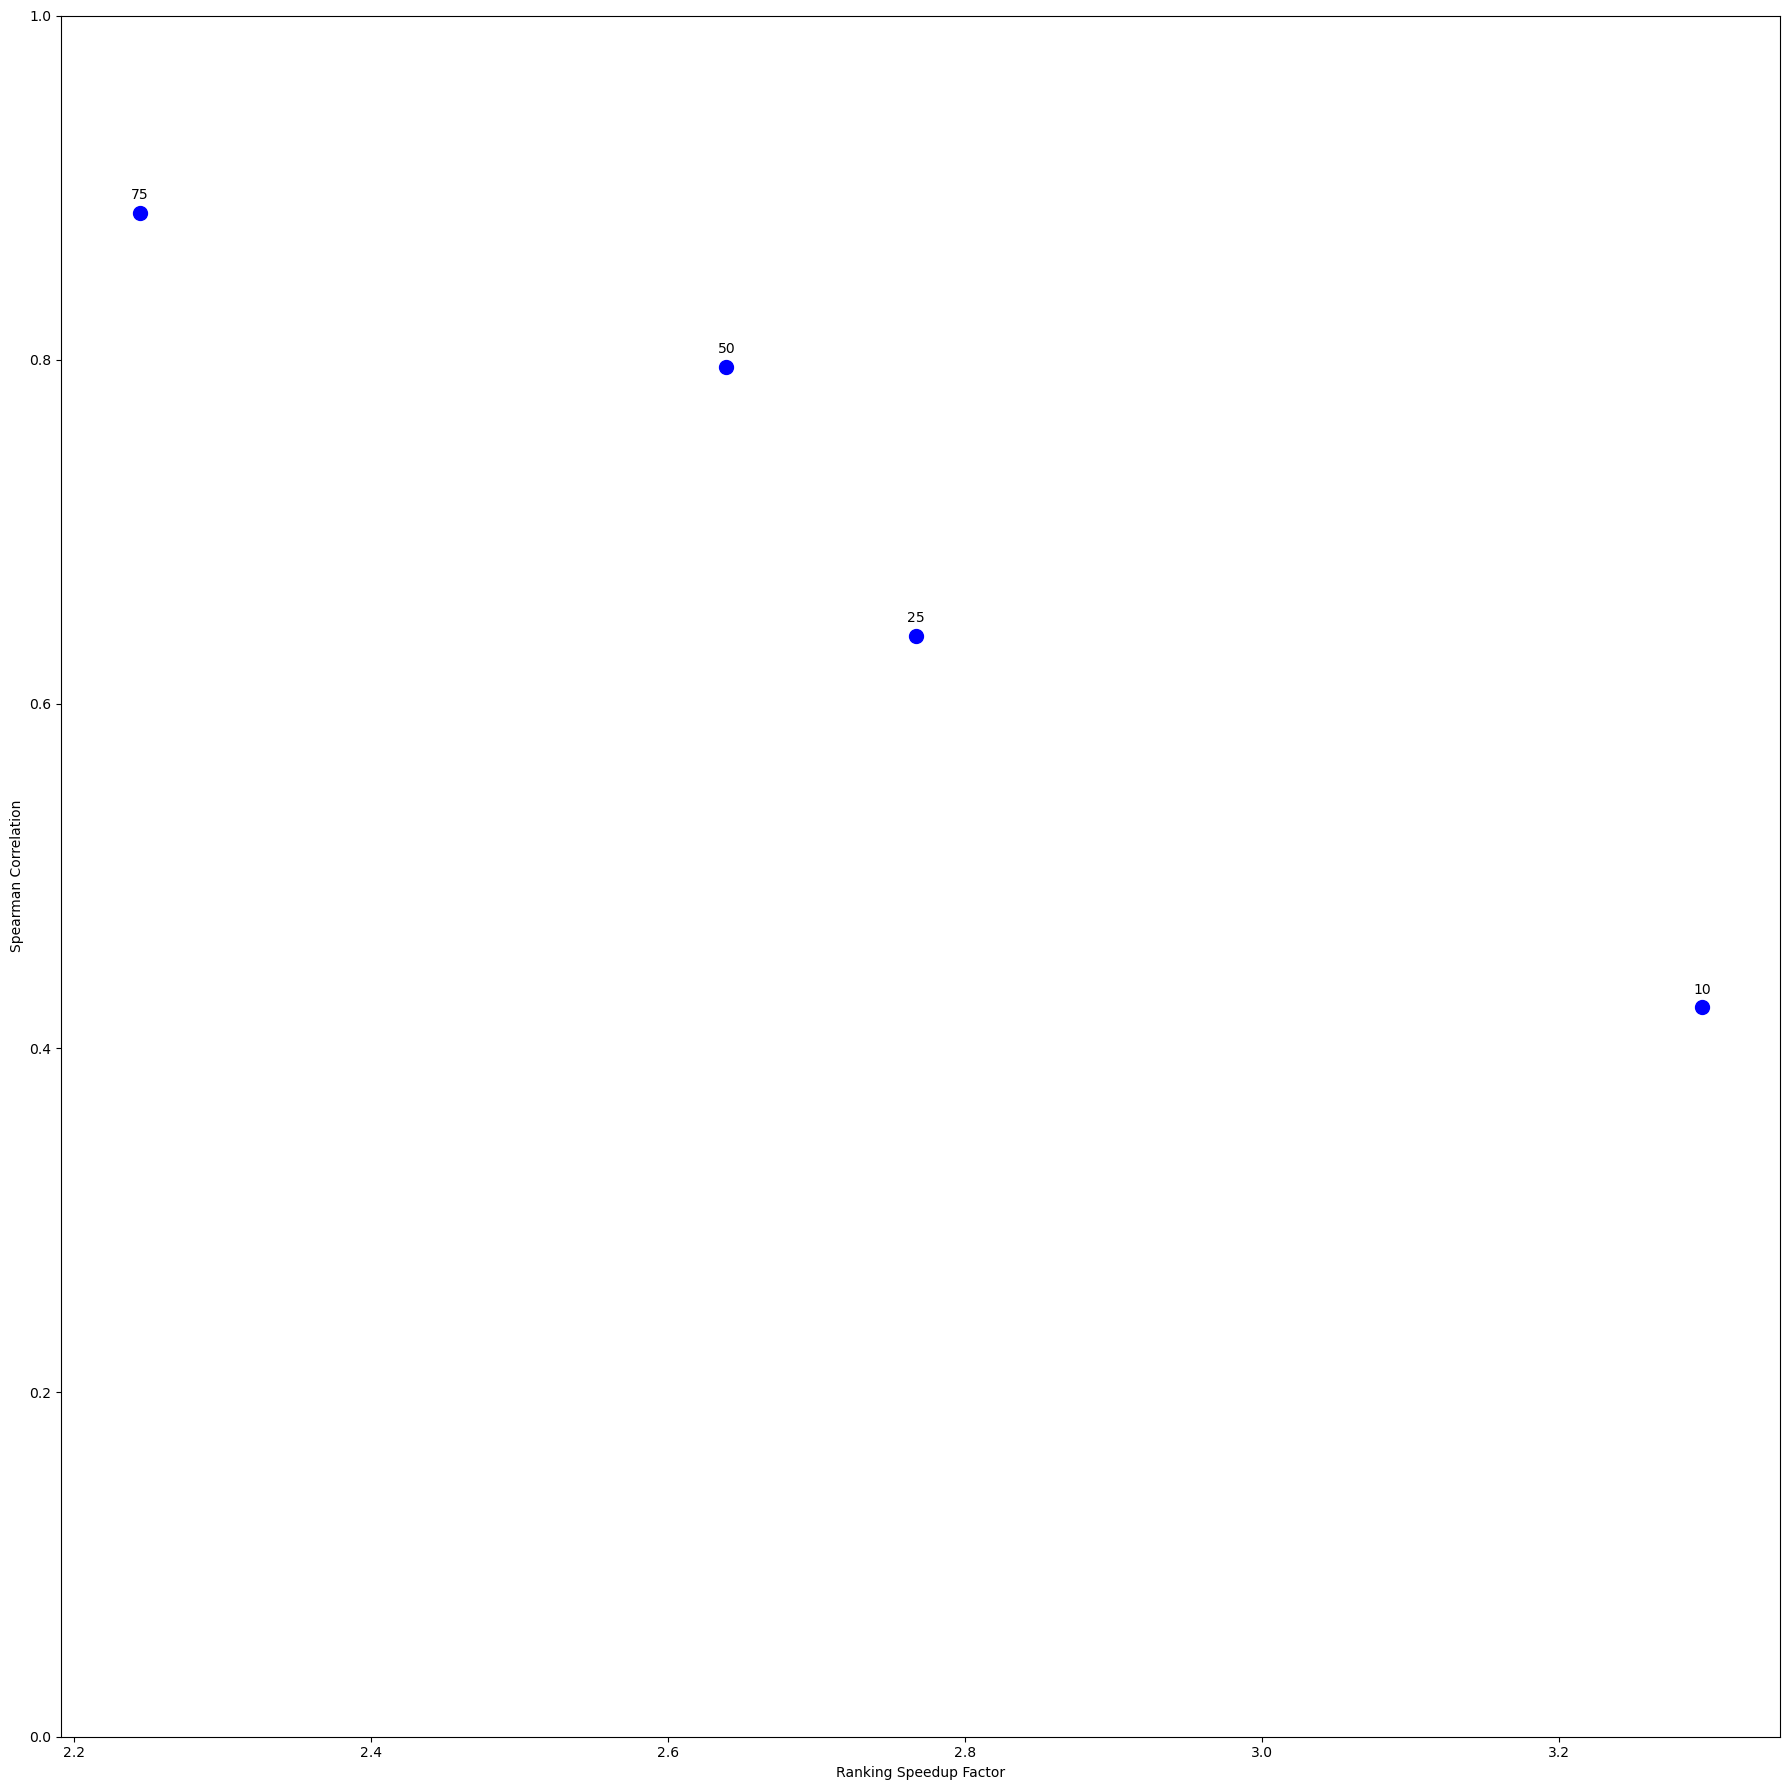


=== OVERALL SUMMARY ===
Dataset: 10000 documents, 10000 queries

Bi-Encoder Performance:
  Total offline time: 400.1462 seconds
  Average online time (per query): 0.05383 seconds (includes query encoding)
  Average ranking time (per query): 0.00107 seconds (only ranking)
  Total online time (10000 queries): 538.31138 seconds
  Total ranking time (10000 queries): 10.68314 seconds

Nyström Performance by Landmark Count:

  Nyström with 10 landmarks:
    Total offline time: 400.1864 seconds
    Average online time (per query): 0.04474 seconds (includes query encoding)
    Average ranking time (per query): 0.00032 seconds (only ranking)
    Total online time (10000 queries): 447.35394 seconds
    Total ranking time (10000 queries): 3.24076 seconds
    Online speedup vs bi-encoder: 1.20x
    Ranking speedup vs bi-encoder: 3.30x
    Similarity to bi-encoder results:
      Spearman rank correlation: 0.4237
      Top-k overlap: 0.0399
      Mean absolute score difference: 0.0092
      Top-1 m

In [ ]:
# Optimized comparison of bi-encoder vs Nyström kernel approximation
# Computing document embeddings once and running bi-encoder only once per query

import os
import gzip
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.linalg import pinv
from scipy.stats import spearmanr
import torch
from transformers import AutoTokenizer, AutoModel

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

class MSMARCOEvaluator:
    """
    Evaluator for comparing bi-encoder and Nyström kernel approximation
    with optimized timing and direct score comparison
    """
    def __init__(self, data_dir="files", model_name="sentence-transformers/all-MiniLM-L6-v2", device=None):
        # File paths
        self.data_dir = data_dir
        self.queries_path = os.path.join(data_dir, "docleaderboard-queries.tsv.gz")
        self.top100_path = os.path.join(data_dir, "docleaderboard-top100.tsv.gz")
        self.fulldocs_path = os.path.join(data_dir, "fulldocs.tsv.gz")
        
        # Set device (GPU if available, otherwise CPU)
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        # Data storage
        self.queries = {}  # query_id -> query_text
        self.documents = {}  # doc_id -> doc_text
        
        # Timing metrics
        self.timing = {
            'embedding': 0,  # Shared embedding time
            'query_embedding': 0,  # Query embedding time
            'biencoder': {
                'offline': 0, 
                'online': [],  # Includes query encoding
                'ranking': []   # Only ranking computation
            },
            'nystrom': {
                'offline': {}, 
                'online': {},   # Includes query encoding
                'ranking': {}   # Only ranking computation
            }
        }
        
        # Comparison metrics
        self.comparison_metrics = {}  # Will store metrics for different landmark counts
        
        # Load model and tokenizer
        print(f"Loading {model_name} model...")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.model.to(self.device)
        self.model.eval()  # Set model to evaluation mode
        
        # Document embeddings storage (shared between both methods)
        self.doc_embeddings = {}  # doc_id -> embedding
        self.query_embeddings = {}  # query_id -> embedding
        
        # Nyström-specific data (will be different for each landmark count)
        self.nystrom_data = {}  # num_landmarks -> data
        
        # Store bi-encoder results for each query
        self.biencoder_results = {}  # query_id -> results
    
    def load_data(self, max_queries=20, max_docs=100):
        """Load a subset of MS MARCO data"""
        print("Loading MS MARCO data...")
        
        # Load queries
        self._load_queries(max_queries)
        
        # Load documents 
        self._load_documents(max_docs)
        
        print(f"Loaded {len(self.queries)} queries and {len(self.documents)} documents")
        return len(self.queries) > 0 and len(self.documents) > 0
    
    def _load_queries(self, max_queries):
        """Load queries from file"""
        try:
            with gzip.open(self.queries_path, 'rt', encoding='utf-8') as f:
                for i, line in enumerate(f):
                    if i >= max_queries:
                        break
                    
                    parts = line.strip().split('\t')
                    if len(parts) >= 2:
                        query_id = parts[0]
                        query_text = parts[1]
                        self.queries[query_id] = query_text
            
            print(f"Loaded {len(self.queries)} queries")
        
        except Exception as e:
            print(f"Error loading queries: {e}")
    
    def _load_documents(self, max_docs):
        """Load or create document content"""
        try:
            # For MS MARCO, try to load real documents first
            docs_loaded = 0
            
            with gzip.open(self.top100_path, 'rt', encoding='utf-8') as f:
                # Extract document IDs from top100 file
                doc_ids = set()
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 3:
                        # Check if query is in our loaded queries
                        query_id = parts[0]
                        if query_id in self.queries:
                            doc_id = parts[2]  # Doc ID is in position 2
                            doc_ids.add(doc_id)
                            
                            # Limit number of docs
                            if len(doc_ids) >= max_docs:
                                break
            
            print(f"Found {len(doc_ids)} unique document IDs")
            
            # Create synthetic documents (in practice, you'd load real documents)
            for i, doc_id in enumerate(doc_ids):
                self.documents[doc_id] = f"This is a synthetic document {i} for id {doc_id}. " + \
                                        "It contains text that would normally come from the real MS MARCO dataset."
            
            print(f"Created {len(self.documents)} document entries")
        
        except Exception as e:
            print(f"Error loading documents: {e}")
            
            # Fallback: Create some dummy documents
            for i in range(max_docs):
                doc_id = f"D{i+1000000}"
                self.documents[doc_id] = f"This is a synthetic document {i} with ID {doc_id}."
            
            print(f"Created {len(self.documents)} fallback document entries")
    
    def encode_text(self, text, max_length=256):
        """Encode text using the pre-trained model"""
        # Tokenize
        inputs = self.tokenizer(
            text,
            max_length=max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        ).to(self.device)
        
        # Get embeddings
        with torch.no_grad():
            outputs = self.model(**inputs)
            
            # Mean pooling - use attention mask to ignore padding tokens
            token_embeddings = outputs.last_hidden_state
            attention_mask = inputs['attention_mask']
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
            embedding = torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
            
            # Normalize embedding
            embedding = torch.nn.functional.normalize(embedding, p=2, dim=1)
        
        return embedding[0].cpu().numpy()
    
    def encode_all_documents(self):
        """Encode all documents once for both methods"""
        print("SHARED PHASE: Encoding all documents (used by both methods)...")
        
        # Clear existing embeddings
        self.doc_embeddings = {}
        
        start_time = time.time()
        
        # Encode all documents
        for doc_id, doc_text in tqdm(self.documents.items(), desc="Encoding documents"):
            self.doc_embeddings[doc_id] = self.encode_text(doc_text)
        
        # Record shared embedding time
        encoding_time = time.time() - start_time
        self.timing['embedding'] = encoding_time
        
        print(f"Encoded {len(self.doc_embeddings)} documents in {encoding_time:.2f} seconds")
        print(f"Average time per document: {encoding_time / len(self.documents):.5f} seconds")

    def encode_all_queries(self):
        """Encode all queries once for both methods"""
        print("SHARED PHASE: Encoding all queries (used by both methods)...")
        
        self.query_embeddings = {}  # Initialize dictionary to store query embeddings
        
        start_time = time.time()
        
        # Encode all queries
        for query_id, query_text in tqdm(self.queries.items(), desc="Encoding queries"):
            self.query_embeddings[query_id] = self.encode_text(query_text)
        
        encoding_time = time.time() - start_time
        self.timing['query_embedding'] = encoding_time
        
        print(f"Encoded {len(self.query_embeddings)} queries in {encoding_time:.2f} seconds")
        print(f"Average time per query: {encoding_time / len(self.queries):.5f} seconds")
    
    def setup_biencoder(self):
        """Set up standard bi-encoder (OFFLINE phase)"""
        print("BIENCODER OFFLINE PHASE: Nothing to do (embeddings already computed)")
        
        # No additional offline processing needed for bi-encoder
        # Just account for the embedding time in the offline time
        self.timing['biencoder']['offline'] = 0  # Additional offline time (zero for bi-encoder)
    
    def setup_nystrom_approximation(self, num_landmarks=10):
        """Set up Nyström kernel approximation (OFFLINE phase) with optimizations"""
        print(f"NYSTROM OFFLINE PHASE: Setting up with {num_landmarks} random landmarks...")
        start_time = time.time()

        # 1. Randomly select landmarks (uniform sampling)
        all_doc_ids = list(self.doc_embeddings.keys())
        landmark_docs = np.random.choice(all_doc_ids, size=num_landmarks, replace=False)
        landmark_embeddings = np.array([self.doc_embeddings[doc_id] for doc_id in landmark_docs])

        # 2. Compute W and its pseudoinverse
        W = np.dot(landmark_embeddings, landmark_embeddings.T)
        W_inv = np.linalg.pinv(W)  # shape: [num_landmarks, num_landmarks]

        # 3. Precompute document features: (doc_embeddings @ landmarks.T) @ W_inv
        doc_embeddings_matrix = np.array([self.doc_embeddings[doc_id] for doc_id in all_doc_ids])  # shape: [num_docs, dim]
        C = np.dot(doc_embeddings_matrix, landmark_embeddings.T)  # shape: [num_docs, num_landmarks]
        doc_features = np.dot(C, W_inv.T)  # shape: [num_docs, num_landmarks]

        # 4. Ensure contiguous memory layout for maximum BLAS speed
        doc_features = np.ascontiguousarray(doc_features)
        landmark_embeddings = np.ascontiguousarray(landmark_embeddings)

        # 5. Store all data for this landmark configuration
        self.nystrom_data[num_landmarks] = {
            'landmark_docs': landmark_docs,
            'landmark_embeddings': landmark_embeddings,
            'W_inv': W_inv,
            'doc_features': doc_features,
            'doc_ids': np.array(all_doc_ids)
        }

        # Record offline time for this landmark count
        setup_time = time.time() - start_time
        self.timing['nystrom']['offline'][num_landmarks] = setup_time
        print(f"Nyström setup completed in {setup_time:.2f} seconds")
    
    def search_biencoder(self, query_id, top_k=10):
        """Search using standard bi-encoder approach (ONLINE phase)"""
        if not self.doc_embeddings:
            print("Document embeddings not available. Call encode_all_documents() first.")
            return None, 0, 0
        
        # Check if we already have results for this query
        if query_id in self.biencoder_results:
            return self.biencoder_results[query_id], 0, 0
        
        # Get precomputed query embedding
        query_embedding = self.query_embeddings[query_id]
        
        # Start timing (ONLINE phase - includes query encoding)
        start_time = time.time()
        
        # Compute similarities with all documents
        doc_ids = list(self.doc_embeddings.keys())
        doc_embeddings = np.array([self.doc_embeddings[doc_id] for doc_id in doc_ids])
        
        similarities = np.dot(doc_embeddings, query_embedding)
        
        # Sort by similarity and get top k
        sorted_indices = np.argsort(similarities)[::-1][:top_k]
        
        # End timing (total online time)
        online_time = time.time() - start_time + self.timing['query_embedding'] / len(self.queries)
        
        # Start timing for ranking only (without query encoding)
        ranking_start = time.time()
        _ = np.dot(doc_embeddings, query_embedding)
        sorted_indices = np.argsort(similarities)[::-1][:top_k]
        ranking_time = time.time() - ranking_start
        
        # Store timing
        self.timing['biencoder']['online'].append(online_time)
        self.timing['biencoder']['ranking'].append(ranking_time)
        
        # Prepare results
        results = {
            'query_id': query_id,
            'query_text': self.queries[query_id],
            'top_k_docs': [],
            'all_scores': dict(zip(doc_ids, similarities))
        }
        
        # Add top k results
        for idx in sorted_indices:
            doc_id = doc_ids[idx]
            score = float(similarities[idx])
            
            results['top_k_docs'].append({
                'doc_id': doc_id,
                'score': score,
                'text': self.documents[doc_id][:100] + "..."
            })
        
        # Store results
        self.biencoder_results[query_id] = results
        
        return results, online_time, ranking_time
    
    def search_nystrom(self, query_id, num_landmarks, top_k=10):
        """Optimized search using Nyström kernel approximation (ONLINE phase)"""
        if num_landmarks not in self.nystrom_data:
            print(f"Nyström data for {num_landmarks} landmarks not found. Call setup_nystrom_approximation() first.")
            return None, 0, 0
        
        data = self.nystrom_data[num_landmarks]
        
        # Get precomputed query embedding
        query_embedding = self.query_embeddings[query_id]
        
        # Start timing (ONLINE phase - includes query encoding)
        start_time = time.time()
        
        # Compute query features
        query_C = np.dot(query_embedding, data['landmark_embeddings'].T)
        
        # Compute scores
        similarities = np.dot(data['doc_features'], query_C)
        
        # Get top-k docs
        top_k_indices = np.argpartition(similarities, -top_k)[-top_k:]
        top_k_indices = top_k_indices[np.argsort(similarities[top_k_indices])[::-1]]
        
        # End timing (total online time)
        online_time = time.time() - start_time + self.timing['query_embedding'] / len(self.queries)
        
        # Start timing for ranking only (without query encoding)
        ranking_start = time.time()
        _ = np.dot(query_embedding, data['landmark_embeddings'].T)
        _ = np.dot(data['doc_features'], query_C)
        top_k_indices = np.argpartition(similarities, -top_k)[-top_k:]
        _ = top_k_indices[np.argsort(similarities[top_k_indices])[::-1]]
        ranking_time = time.time() - ranking_start
        
        # Store timing
        if num_landmarks not in self.timing['nystrom']['online']:
            self.timing['nystrom']['online'][num_landmarks] = []
            self.timing['nystrom']['ranking'][num_landmarks] = []
            
        self.timing['nystrom']['online'][num_landmarks].append(online_time)
        self.timing['nystrom']['ranking'][num_landmarks].append(ranking_time)
        
        # Prepare results
        results = {
            'query_id': query_id,
            'query_text': self.queries[query_id],
            'top_k_docs': [{
                'doc_id': data['doc_ids'][idx],
                'score': float(similarities[idx]),
                'text': self.documents[data['doc_ids'][idx]][:100] + "..."
            } for idx in top_k_indices],
            'all_scores': dict(zip(data['doc_ids'], similarities))
        }

        return results, online_time, ranking_time
    
    def compare_scores(self, biencoder_results, nystrom_results):
        """Compare scores between bi-encoder and Nyström methods"""
        # Get all document IDs
        doc_ids = set(biencoder_results['all_scores'].keys())
        
        # Get scores for each method
        be_scores = np.array([biencoder_results['all_scores'][doc_id] for doc_id in doc_ids])
        ny_scores = np.array([nystrom_results['all_scores'][doc_id] for doc_id in doc_ids])
        
        # Calculate score differences
        abs_diff = np.abs(be_scores - ny_scores)
        mean_abs_diff = np.mean(abs_diff)
        max_abs_diff = np.max(abs_diff)
        
        # Calculate relative differences
        # Avoid division by zero
        be_abs = np.abs(be_scores)
        valid_indices = be_abs > 1e-10
        rel_diff = np.zeros_like(abs_diff)
        rel_diff[valid_indices] = abs_diff[valid_indices] / be_abs[valid_indices]
        mean_rel_diff = np.mean(rel_diff)
        
        # Calculate rank correlation (Spearman)
        corr, _ = spearmanr(be_scores, ny_scores)
        
        # Calculate top-k overlap
        k = min(10, len(biencoder_results['top_k_docs']))
        be_top_k = set(doc['doc_id'] for doc in biencoder_results['top_k_docs'][:k])
        ny_top_k = set(doc['doc_id'] for doc in nystrom_results['top_k_docs'][:k])
        overlap = len(be_top_k.intersection(ny_top_k)) / k
        
        # Calculate top-1 match
        top1_match = biencoder_results['top_k_docs'][0]['doc_id'] == nystrom_results['top_k_docs'][0]['doc_id']
        
        return {
            'mean_abs_diff': mean_abs_diff,
            'max_abs_diff': max_abs_diff,
            'mean_rel_diff': mean_rel_diff,
            'spearman_corr': corr,
            'top_k_overlap': overlap,
            'top1_match': top1_match
        }
    
    def run_all_queries_with_biencoder(self, query_ids, top_k=10):
        """Run bi-encoder retrieval once for all queries and store results"""
        print(f"Running bi-encoder retrieval for {len(query_ids)} queries...")
        
        # Reset timing
        self.timing['biencoder']['online'] = []
        self.timing['biencoder']['ranking'] = []
        
        # Run bi-encoder for each query
        for query_id in tqdm(query_ids, desc="Bi-encoder retrieval"):
            self.search_biencoder(query_id, top_k)
    
    def compare_performance(self, landmark_counts, query_ids, top_k=10):
        """Compare performance between bi-encoder and Nyström for multiple landmark counts"""
        print("\nComparing bi-encoder and Nyström methods for multiple landmark counts...")
        
        # Initialize storage
        self.comparison_metrics = {count: [] for count in landmark_counts}
        
        # Encode all queries upfront
        self.encode_all_queries()
        
        # Setup bi-encoder
        self.setup_biencoder()
        
        # Step 1: Run bi-encoder retrieval once for all queries
        self.run_all_queries_with_biencoder(query_ids, top_k)
        
        # Step 2: Setup and test Nyström for each landmark count
        results_list = []
        
        for num_landmarks in landmark_counts:
            print(f"\nTesting with {num_landmarks} landmarks...")
            
            # Setup Nyström for this landmark count
            self.setup_nystrom_approximation(num_landmarks)
            
            # Reset online timing for this landmark count
            self.timing['nystrom']['online'][num_landmarks] = []
            self.timing['nystrom']['ranking'][num_landmarks] = []
            
            # Run Nyström for each query and compare with stored bi-encoder results
            for query_id in tqdm(query_ids, desc=f"Nyström-{num_landmarks} retrieval"):
                # Get bi-encoder results
                biencoder_results = self.biencoder_results[query_id]
                
                # Run Nyström search
                nystrom_results, _, _ = self.search_nystrom(query_id, num_landmarks, top_k)
                
                # Compare scores
                comparison = self.compare_scores(biencoder_results, nystrom_results)
                self.comparison_metrics[num_landmarks].append(comparison)
        
        # Calculate all metrics after running all queries
        return self._calculate_final_metrics(landmark_counts, query_ids)
    
    def _calculate_final_metrics(self, landmark_counts, query_ids):
        """Calculate and print all final metrics after running all queries"""
        results_list = []
        
        # Calculate bi-encoder metrics
        biencoder_avg_online = np.mean(self.timing['biencoder']['online'])
        biencoder_avg_ranking = np.mean(self.timing['biencoder']['ranking'])
        biencoder_total_offline = self.timing['embedding'] + self.timing['biencoder']['offline']
        
        for num_landmarks in landmark_counts:
            # Calculate average comparison metrics for this landmark count
            avg_metrics = {}
            for metric in self.comparison_metrics[num_landmarks][0].keys():
                avg_metrics[metric] = np.mean([m[metric] for m in self.comparison_metrics[num_landmarks]])
            
            # Calculate timing metrics
            nystrom_avg_online = np.mean(self.timing['nystrom']['online'][num_landmarks])
            nystrom_avg_ranking = np.mean(self.timing['nystrom']['ranking'][num_landmarks])
            nystrom_total_offline = self.timing['embedding'] + self.timing['nystrom']['offline'][num_landmarks]
            
            # Calculate speedups
            online_speedup = biencoder_avg_online / nystrom_avg_online if nystrom_avg_online > 0 else 0
            ranking_speedup = biencoder_avg_ranking / nystrom_avg_ranking if nystrom_avg_ranking > 0 else 0
            
            # Store results for this landmark count
            results_list.append({
                'biencoder': {
                    'offline': biencoder_total_offline,
                    'online_avg': biencoder_avg_online,
                    'ranking_avg': biencoder_avg_ranking,
                    'online_total': biencoder_avg_online * len(query_ids),
                    'ranking_total': biencoder_avg_ranking * len(query_ids)
                },
                'nystrom': {
                    'offline': nystrom_total_offline,
                    'online_avg': nystrom_avg_online,
                    'ranking_avg': nystrom_avg_ranking,
                    'online_total': nystrom_avg_online * len(query_ids),
                    'ranking_total': nystrom_avg_ranking * len(query_ids),
                    'landmarks': num_landmarks
                },
                'comparison': {
                    'online_speedup': online_speedup,
                    'ranking_speedup': ranking_speedup,
                    'metrics': avg_metrics
                }
            })
        
        return results_list
    
    def plot_results(self, results_list):
        """Plot performance comparison results for multiple configurations"""
        
        
        # Extract landmark counts and timing data
        landmark_counts = [result['nystrom']['landmarks'] for result in results_list]
        biencoder_offline = results_list[0]['biencoder']['offline']  # Same for all
        biencoder_online = results_list[0]['biencoder']['online_avg']  # Same for all
        biencoder_ranking = results_list[0]['biencoder']['ranking_avg']  # Same for all
        nystrom_offline = [result['nystrom']['offline'] for result in results_list]
        nystrom_online = [result['nystrom']['online_avg'] for result in results_list]
        nystrom_ranking = [result['nystrom']['ranking_avg'] for result in results_list]
        
        # Extract comparison metrics
        spearman_corrs = [result['comparison']['metrics']['spearman_corr'] for result in results_list]
        top_k_overlaps = [result['comparison']['metrics']['top_k_overlap'] for result in results_list]
        mean_abs_diffs = [result['comparison']['metrics']['mean_abs_diff'] for result in results_list]
        online_speedups = [result['comparison']['online_speedup'] for result in results_list]
        ranking_speedups = [result['comparison']['ranking_speedup'] for result in results_list]
        
        plt.tight_layout()
        plt.savefig(os.path.join('graphs', 'performance_comparison_uniform.png'))

        # Save individual plots without titles
        plt.figure(figsize=(18, 18))

        # Offline times
        plt.bar(range(len(landmark_counts) + 1), [biencoder_offline] + nystrom_offline, 
                color=['blue'] + ['green'] * len(landmark_counts))
        plt.xticks(range(len(landmark_counts) + 1), 
                ['Bi-Encoder'] + [f'Nyström-{n}' for n in landmark_counts])
        plt.ylabel('Time (seconds)')
        plt.tight_layout()
        plt.savefig(os.path.join('graphs', 'offline_times_uniform.png'))

        # Online times
        plt.figure(figsize=(18, 18))
        plt.bar(range(len(landmark_counts) + 1), [biencoder_online] + nystrom_online, 
                color=['blue'] + ['green'] * len(landmark_counts))
        plt.xticks(range(len(landmark_counts) + 1), 
                ['Bi-Encoder'] + [f'Nyström-{n}' for n in landmark_counts])
        plt.ylabel('Time (seconds)')
        plt.tight_layout()
        plt.savefig(os.path.join('graphs', 'online_times_uniform.png'))

        # Ranking times
        plt.figure(figsize=(18, 18))
        plt.bar(range(len(landmark_counts) + 1), [biencoder_ranking] + nystrom_ranking, 
                color=['blue'] + ['green'] * len(landmark_counts))
        plt.xticks(range(len(landmark_counts) + 1), 
                ['Bi-Encoder'] + [f'Nyström-{n}' for n in landmark_counts])
        plt.ylabel('Time (seconds)')
        plt.tight_layout()
        plt.savefig(os.path.join('graphs', 'ranking_times_uniform.png'))

        # Spearman Correlation
        plt.figure(figsize=(18, 18))
        plt.plot(landmark_counts, spearman_corrs, 'o-', color='purple')
        plt.xlabel('Number of Landmarks')
        plt.ylabel('Spearman Correlation')
        plt.ylim([0, 1])
        plt.tight_layout()
        plt.savefig(os.path.join('graphs', 'spearman_correlation_uniform.png'))

        # Top-k Overlap
        plt.figure(figsize=(18, 18))
        plt.plot(landmark_counts, top_k_overlaps, 'o-', color='red')
        plt.xlabel('Number of Landmarks')
        plt.ylabel('Top-k Overlap Ratio')
        plt.ylim([0, 1])
        plt.tight_layout()
        plt.savefig(os.path.join('graphs', 'topk_overlap_uniform.png'))

        # Mean Absolute Difference
        plt.figure(figsize=(18, 18))
        plt.plot(landmark_counts, mean_abs_diffs, 'o-', color='orange')
        plt.xlabel('Number of Landmarks')
        plt.ylabel('Mean Absolute Difference')
        plt.tight_layout()
        plt.savefig(os.path.join('graphs', 'mean_abs_diff_uniform.png'))

        # Online Speedup vs Quality Tradeoff
        plt.figure(figsize=(18, 18))
        plt.scatter(online_speedups, spearman_corrs, c='red', s=100)
        for i, n in enumerate(landmark_counts):
            plt.annotate(f"{n}", (online_speedups[i], spearman_corrs[i]), 
                        textcoords="offset points", xytext=(0,10), ha='center')
        plt.xlabel('Online Speedup Factor')
        plt.ylabel('Spearman Correlation')
        plt.ylim([0, 1])
        plt.tight_layout()
        plt.savefig(os.path.join('graphs', 'online_speedup_vs_quality_uniform.png'))

        # Ranking Speedup vs Quality Tradeoff
        plt.figure(figsize=(18, 18))
        plt.scatter(ranking_speedups, spearman_corrs, c='blue', s=100)
        for i, n in enumerate(landmark_counts):
            plt.annotate(f"{n}", (ranking_speedups[i], spearman_corrs[i]), 
                        textcoords="offset points", xytext=(0,10), ha='center')
        plt.xlabel('Ranking Speedup Factor')
        plt.ylabel('Spearman Correlation')
        plt.ylim([0, 1])
        plt.tight_layout()
        plt.savefig(os.path.join('graphs', 'ranking_speedup_vs_quality_uniform.png'))

        plt.show()

def main():
    # CUSTOMIZABLE PARAMETERS
    NUM_QUERIES = 10000    # Number of queries to evaluate
    NUM_DOCS = 10000      # Number of documents to use
    LANDMARK_COUNTS = [10, 25, 50, 75]  # Number of landmarks to test
    
    # Create evaluator
    evaluator = MSMARCOEvaluator()
    
    # Load data
    evaluator.load_data(max_queries=NUM_QUERIES, max_docs=NUM_DOCS)
    
    # Encode documents once for both methods
    evaluator.encode_all_documents()
    
    # Select test queries
    test_query_ids = list(evaluator.queries.keys())[:NUM_QUERIES]
    
    # Compare performance with different landmark counts
    results_list = evaluator.compare_performance(
        landmark_counts=LANDMARK_COUNTS,
        query_ids=test_query_ids,
        top_k=10
    )
    
    # Plot comparative results
    evaluator.plot_results(results_list)
    
    # Print overall summary
    print("\n=== OVERALL SUMMARY ===")
    print(f"Dataset: {NUM_DOCS} documents, {NUM_QUERIES} queries")
    
    # Bi-encoder timings (same for all landmark counts)
    be_offline = results_list[0]['biencoder']['offline']
    be_online_avg = results_list[0]['biencoder']['online_avg']
    be_ranking_avg = results_list[0]['biencoder']['ranking_avg']
    
    print("\nBi-Encoder Performance:")
    print(f"  Total offline time: {be_offline:.4f} seconds")
    print(f"  Average online time (per query): {be_online_avg:.5f} seconds (includes query encoding)")
    print(f"  Average ranking time (per query): {be_ranking_avg:.5f} seconds (only ranking)")
    print(f"  Total online time ({NUM_QUERIES} queries): {be_online_avg * NUM_QUERIES:.5f} seconds")
    print(f"  Total ranking time ({NUM_QUERIES} queries): {be_ranking_avg * NUM_QUERIES:.5f} seconds")
    
    print("\nNyström Performance by Landmark Count:")
    for i, num_landmarks in enumerate(LANDMARK_COUNTS):
        ny_offline = results_list[i]['nystrom']['offline']
        ny_online_avg = results_list[i]['nystrom']['online_avg']
        ny_ranking_avg = results_list[i]['nystrom']['ranking_avg']
        online_speedup = results_list[i]['comparison']['online_speedup']
        ranking_speedup = results_list[i]['comparison']['ranking_speedup']
        metrics = results_list[i]['comparison']['metrics']
        
        print(f"\n  Nyström with {num_landmarks} landmarks:")
        print(f"    Total offline time: {ny_offline:.4f} seconds")
        print(f"    Average online time (per query): {ny_online_avg:.5f} seconds (includes query encoding)")
        print(f"    Average ranking time (per query): {ny_ranking_avg:.5f} seconds (only ranking)")
        print(f"    Total online time ({NUM_QUERIES} queries): {ny_online_avg * NUM_QUERIES:.5f} seconds")
        print(f"    Total ranking time ({NUM_QUERIES} queries): {ny_ranking_avg * NUM_QUERIES:.5f} seconds")
        print(f"    Online speedup vs bi-encoder: {online_speedup:.2f}x")
        print(f"    Ranking speedup vs bi-encoder: {ranking_speedup:.2f}x")
        print("    Similarity to bi-encoder results:")
        print(f"      Spearman rank correlation: {metrics['spearman_corr']:.4f}")
        print(f"      Top-k overlap: {metrics['top_k_overlap']:.4f}")
        print(f"      Mean absolute score difference: {metrics['mean_abs_diff']:.4f}")
        print(f"      Top-1 match ratio: {metrics['top1_match']:.4f}")
    
    print("\nEvaluation complete!")

if __name__ == "__main__":
    main()

### K-Means Clustering

K-Means Clustering provides a more sophisticated approach to landmark selection by organizing document embeddings into clusters and choosing representatives from each. This method:

- Applies k-means clustering to document embeddings φ(d_i) where k=m (number of desired landmarks)
- Selects cluster centroids as landmark documents
- Ensures landmarks are distributed across the major modes of variation in the data
- Better captures the geometric structure of the embedding space
- Typically results in lower approximation error compared to uniform sampling
- Involves higher computational cost during the offline phase

K-means selection tends to preserve overall ranking order better than uniform sampling, particularly when working with a limited number of landmarks. The centroids effectively represent different semantic regions in the document space.


Using device: cpu
Loading sentence-transformers/all-MiniLM-L6-v2 model...
Loading MS MARCO data...
Loaded 5793 queries
Found 10000 unique document IDs
Created 10000 document entries
Loaded 5793 queries and 10000 documents
SHARED PHASE: Encoding all documents (used by both methods)...


Encoding documents: 100%|██████████| 10000/10000 [07:20<00:00, 22.70it/s]


Encoded 10000 documents in 440.45 seconds
Average time per document: 0.04404 seconds

Comparing bi-encoder and Nyström methods for multiple landmark counts...
SHARED PHASE: Encoding all queries (used by both methods)...


Encoding queries: 100%|██████████| 5793/5793 [04:11<00:00, 23.00it/s]


Encoded 5793 queries in 251.90 seconds
Average time per query: 0.04348 seconds
BIENCODER OFFLINE PHASE: Nothing to do (embeddings already computed)
Running bi-encoder retrieval for 5793 queries...


Bi-encoder retrieval: 100%|██████████| 5793/5793 [01:09<00:00, 83.81it/s] 
c:\Users\thoma\Anaconda3\envs\tf_env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Testing with 10 landmarks...
NYSTROM OFFLINE PHASE: Setting up with 10 landmarks using k-Means...
Nyström setup completed in 4.10 seconds


Nyström-10 retrieval: 100%|██████████| 5793/5793 [00:52<00:00, 109.43it/s]
c:\Users\thoma\Anaconda3\envs\tf_env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Testing with 25 landmarks...
NYSTROM OFFLINE PHASE: Setting up with 25 landmarks using k-Means...
Nyström setup completed in 7.60 seconds


Nyström-25 retrieval: 100%|██████████| 5793/5793 [00:56<00:00, 101.93it/s]
c:\Users\thoma\Anaconda3\envs\tf_env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Testing with 50 landmarks...
NYSTROM OFFLINE PHASE: Setting up with 50 landmarks using k-Means...
Nyström setup completed in 15.27 seconds


Nyström-50 retrieval: 100%|██████████| 5793/5793 [00:56<00:00, 101.89it/s]
c:\Users\thoma\Anaconda3\envs\tf_env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Testing with 75 landmarks...
NYSTROM OFFLINE PHASE: Setting up with 75 landmarks using k-Means...
Nyström setup completed in 22.24 seconds


Nyström-75 retrieval: 100%|██████████| 5793/5793 [00:54<00:00, 106.53it/s]


<Figure size 640x480 with 0 Axes>

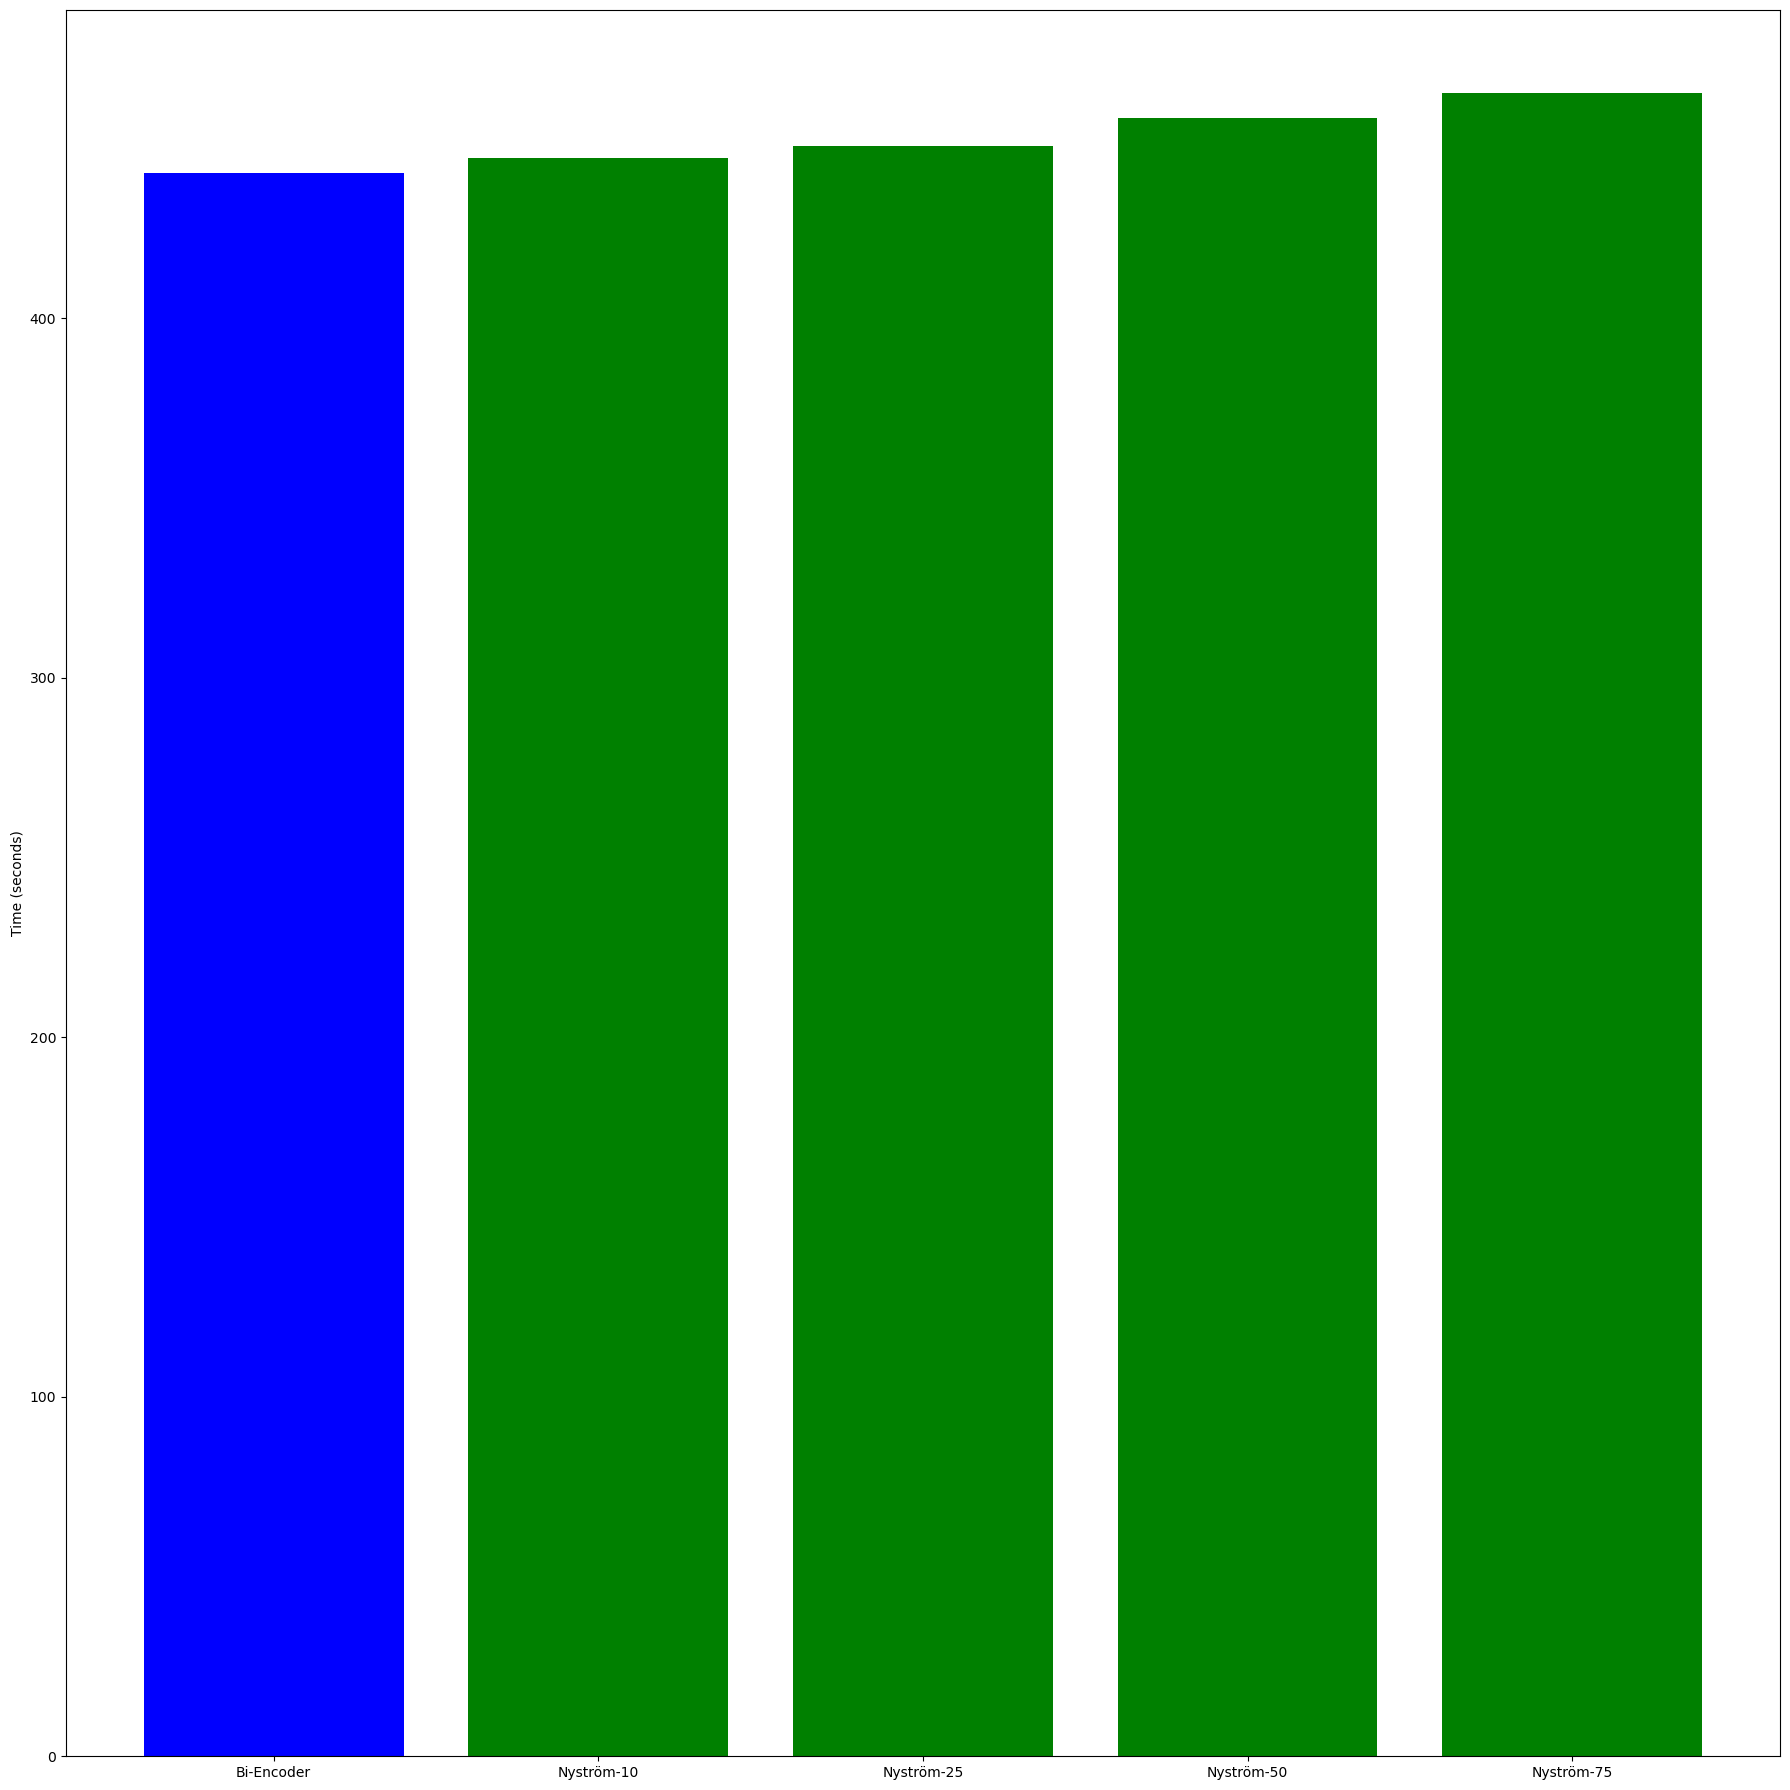

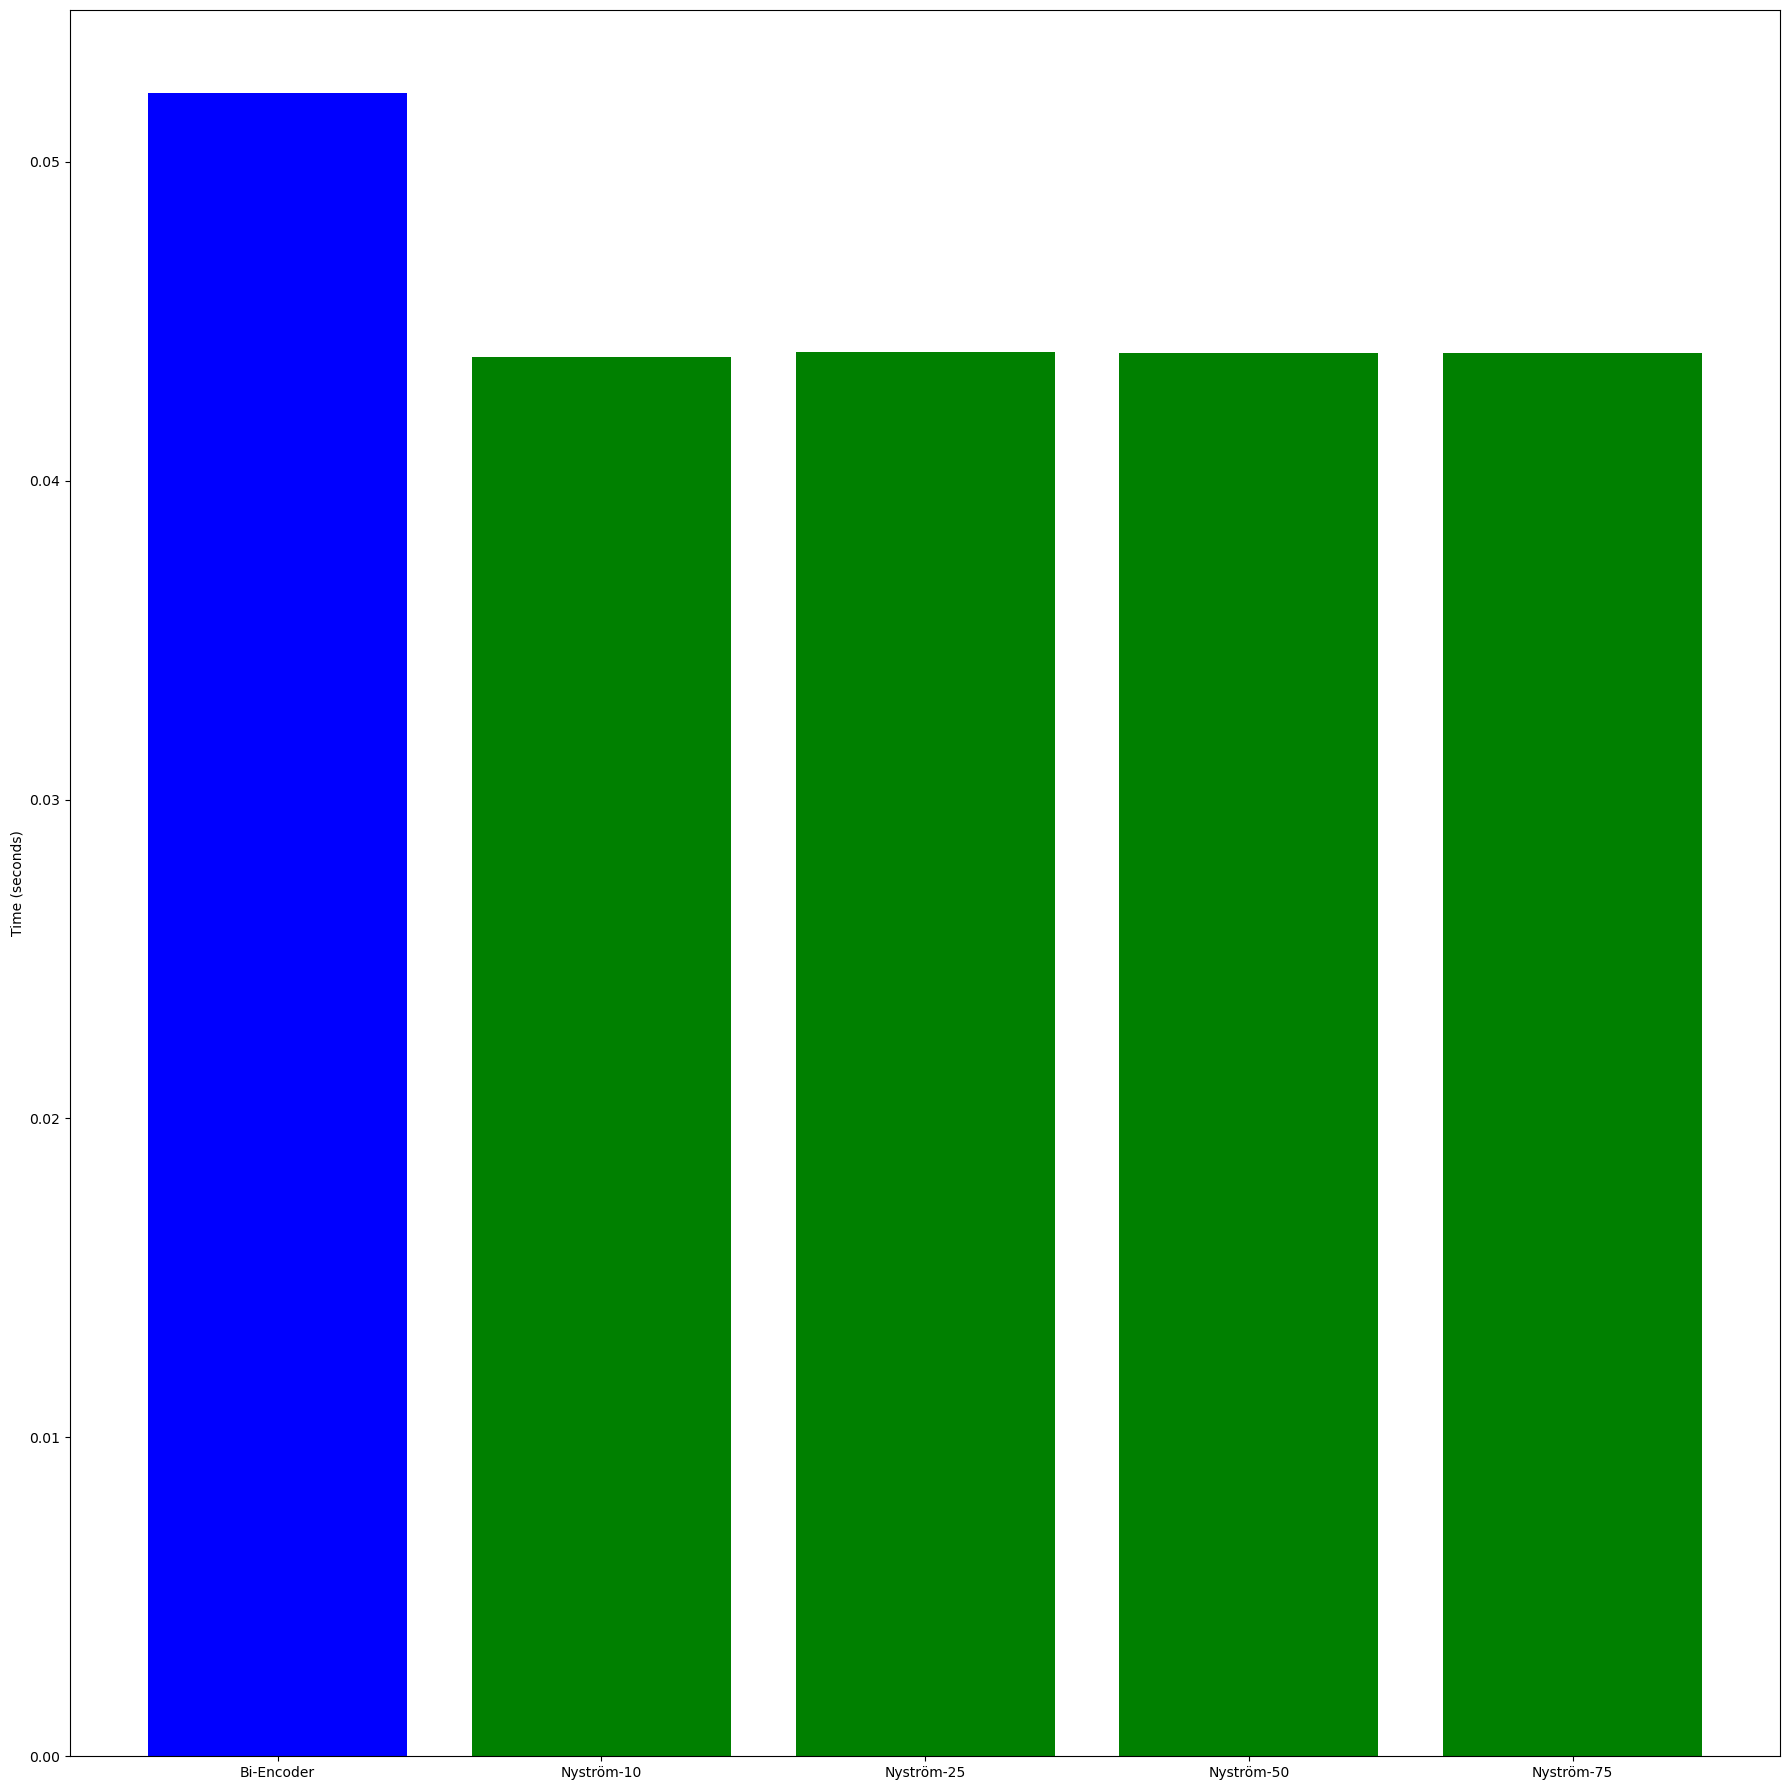

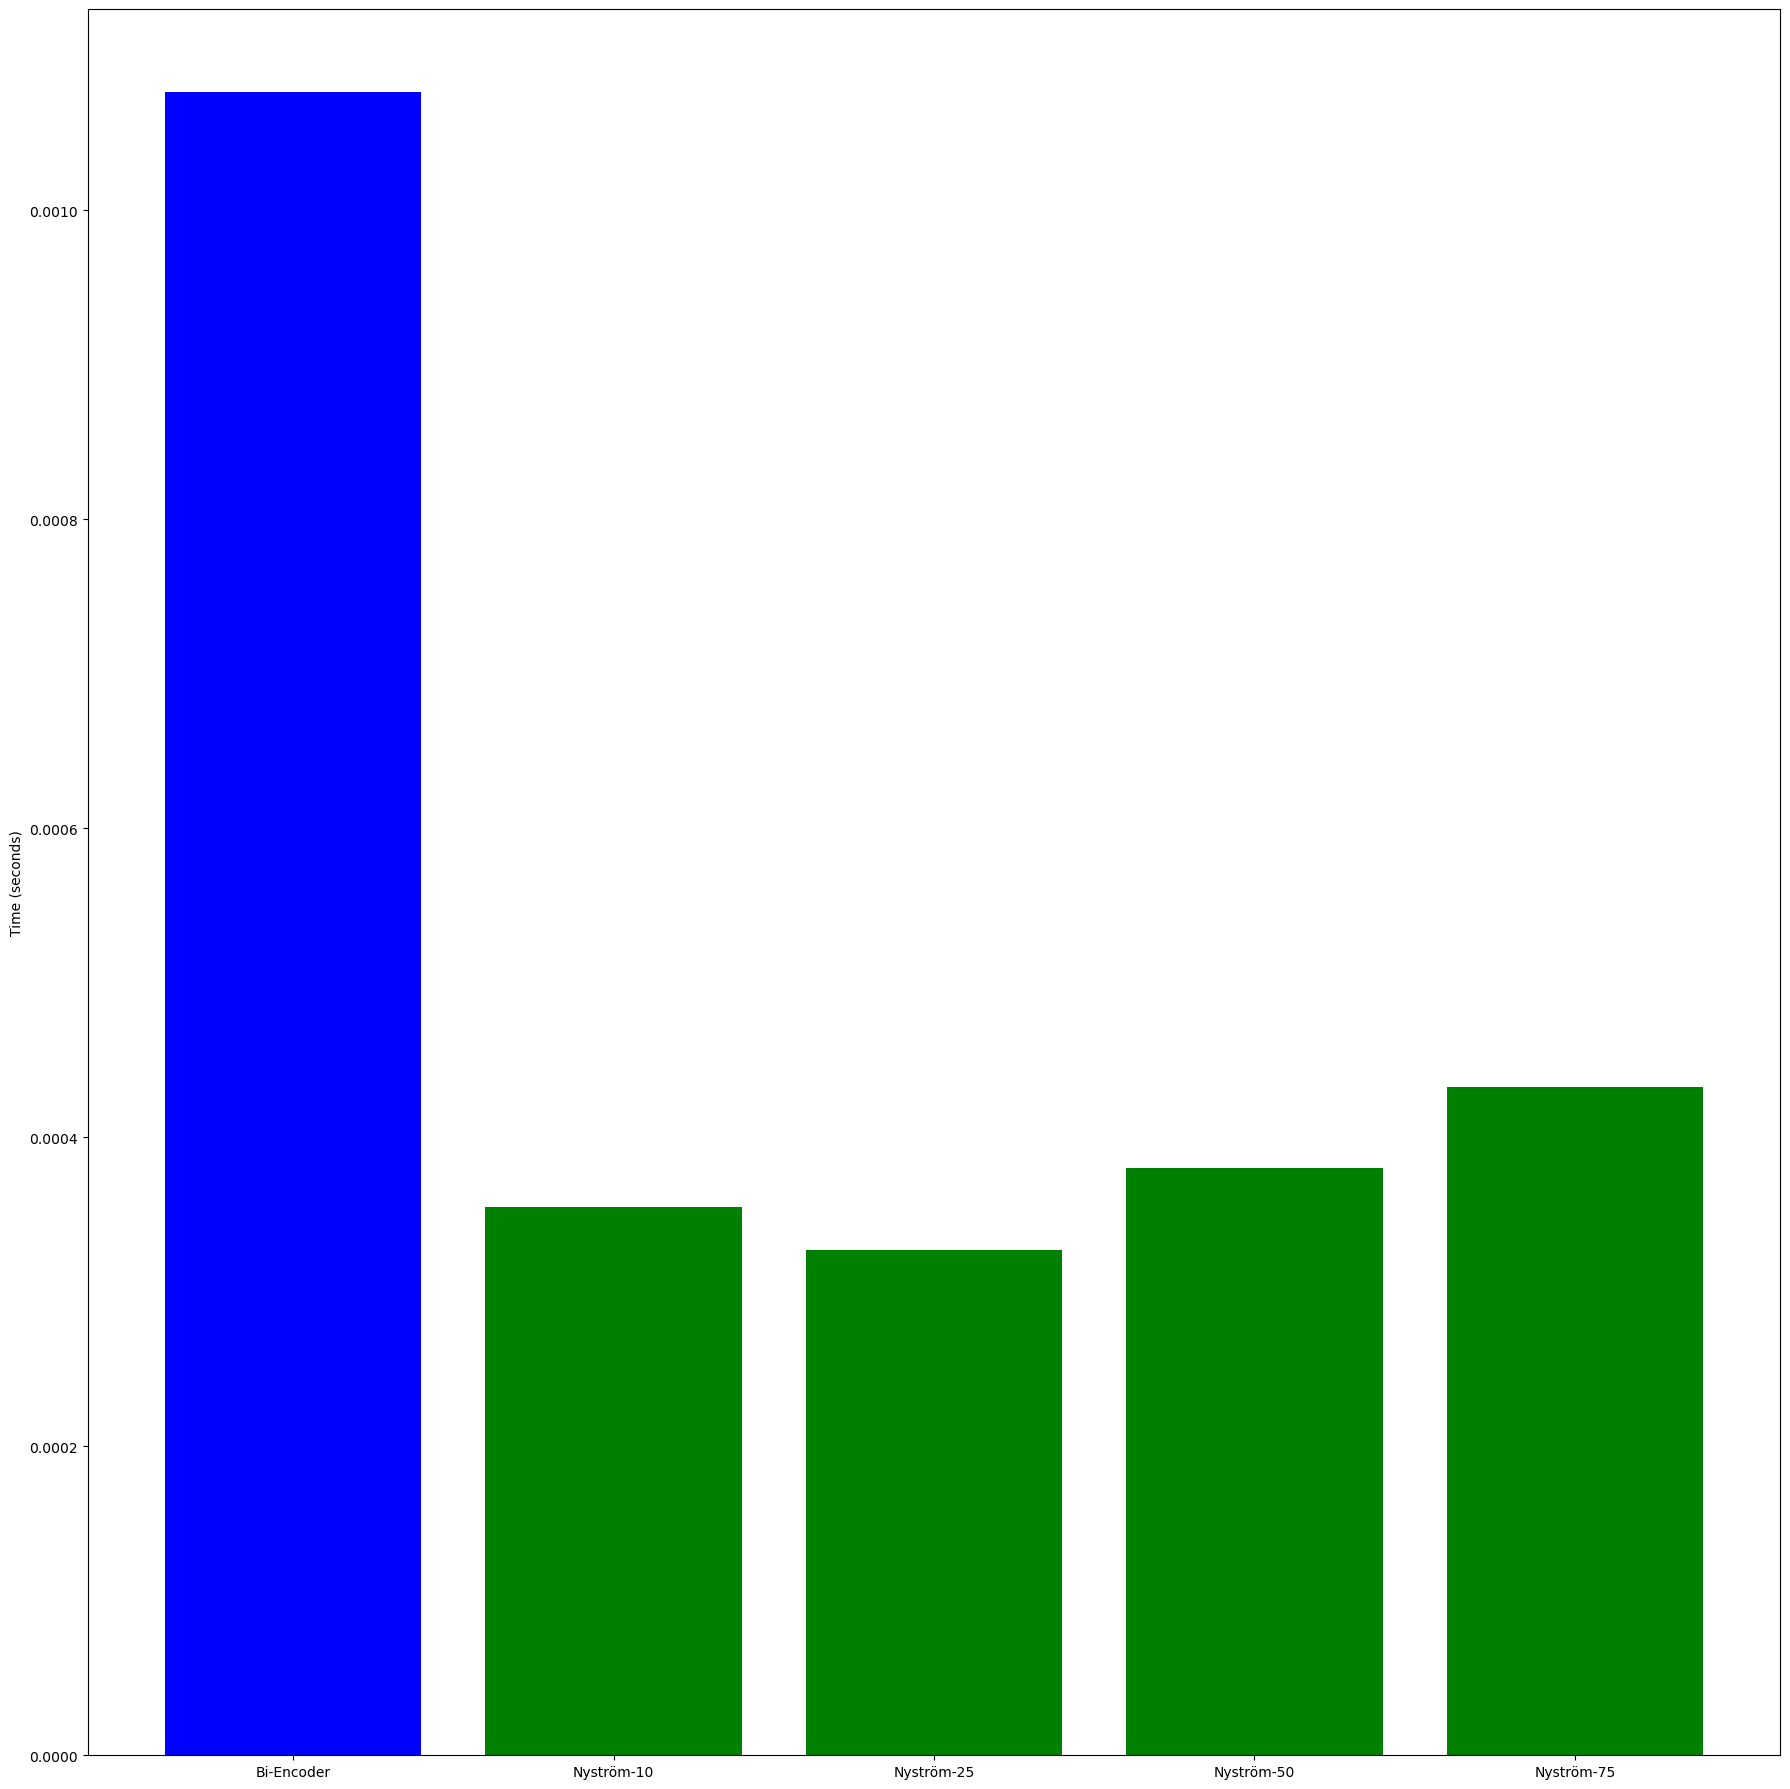

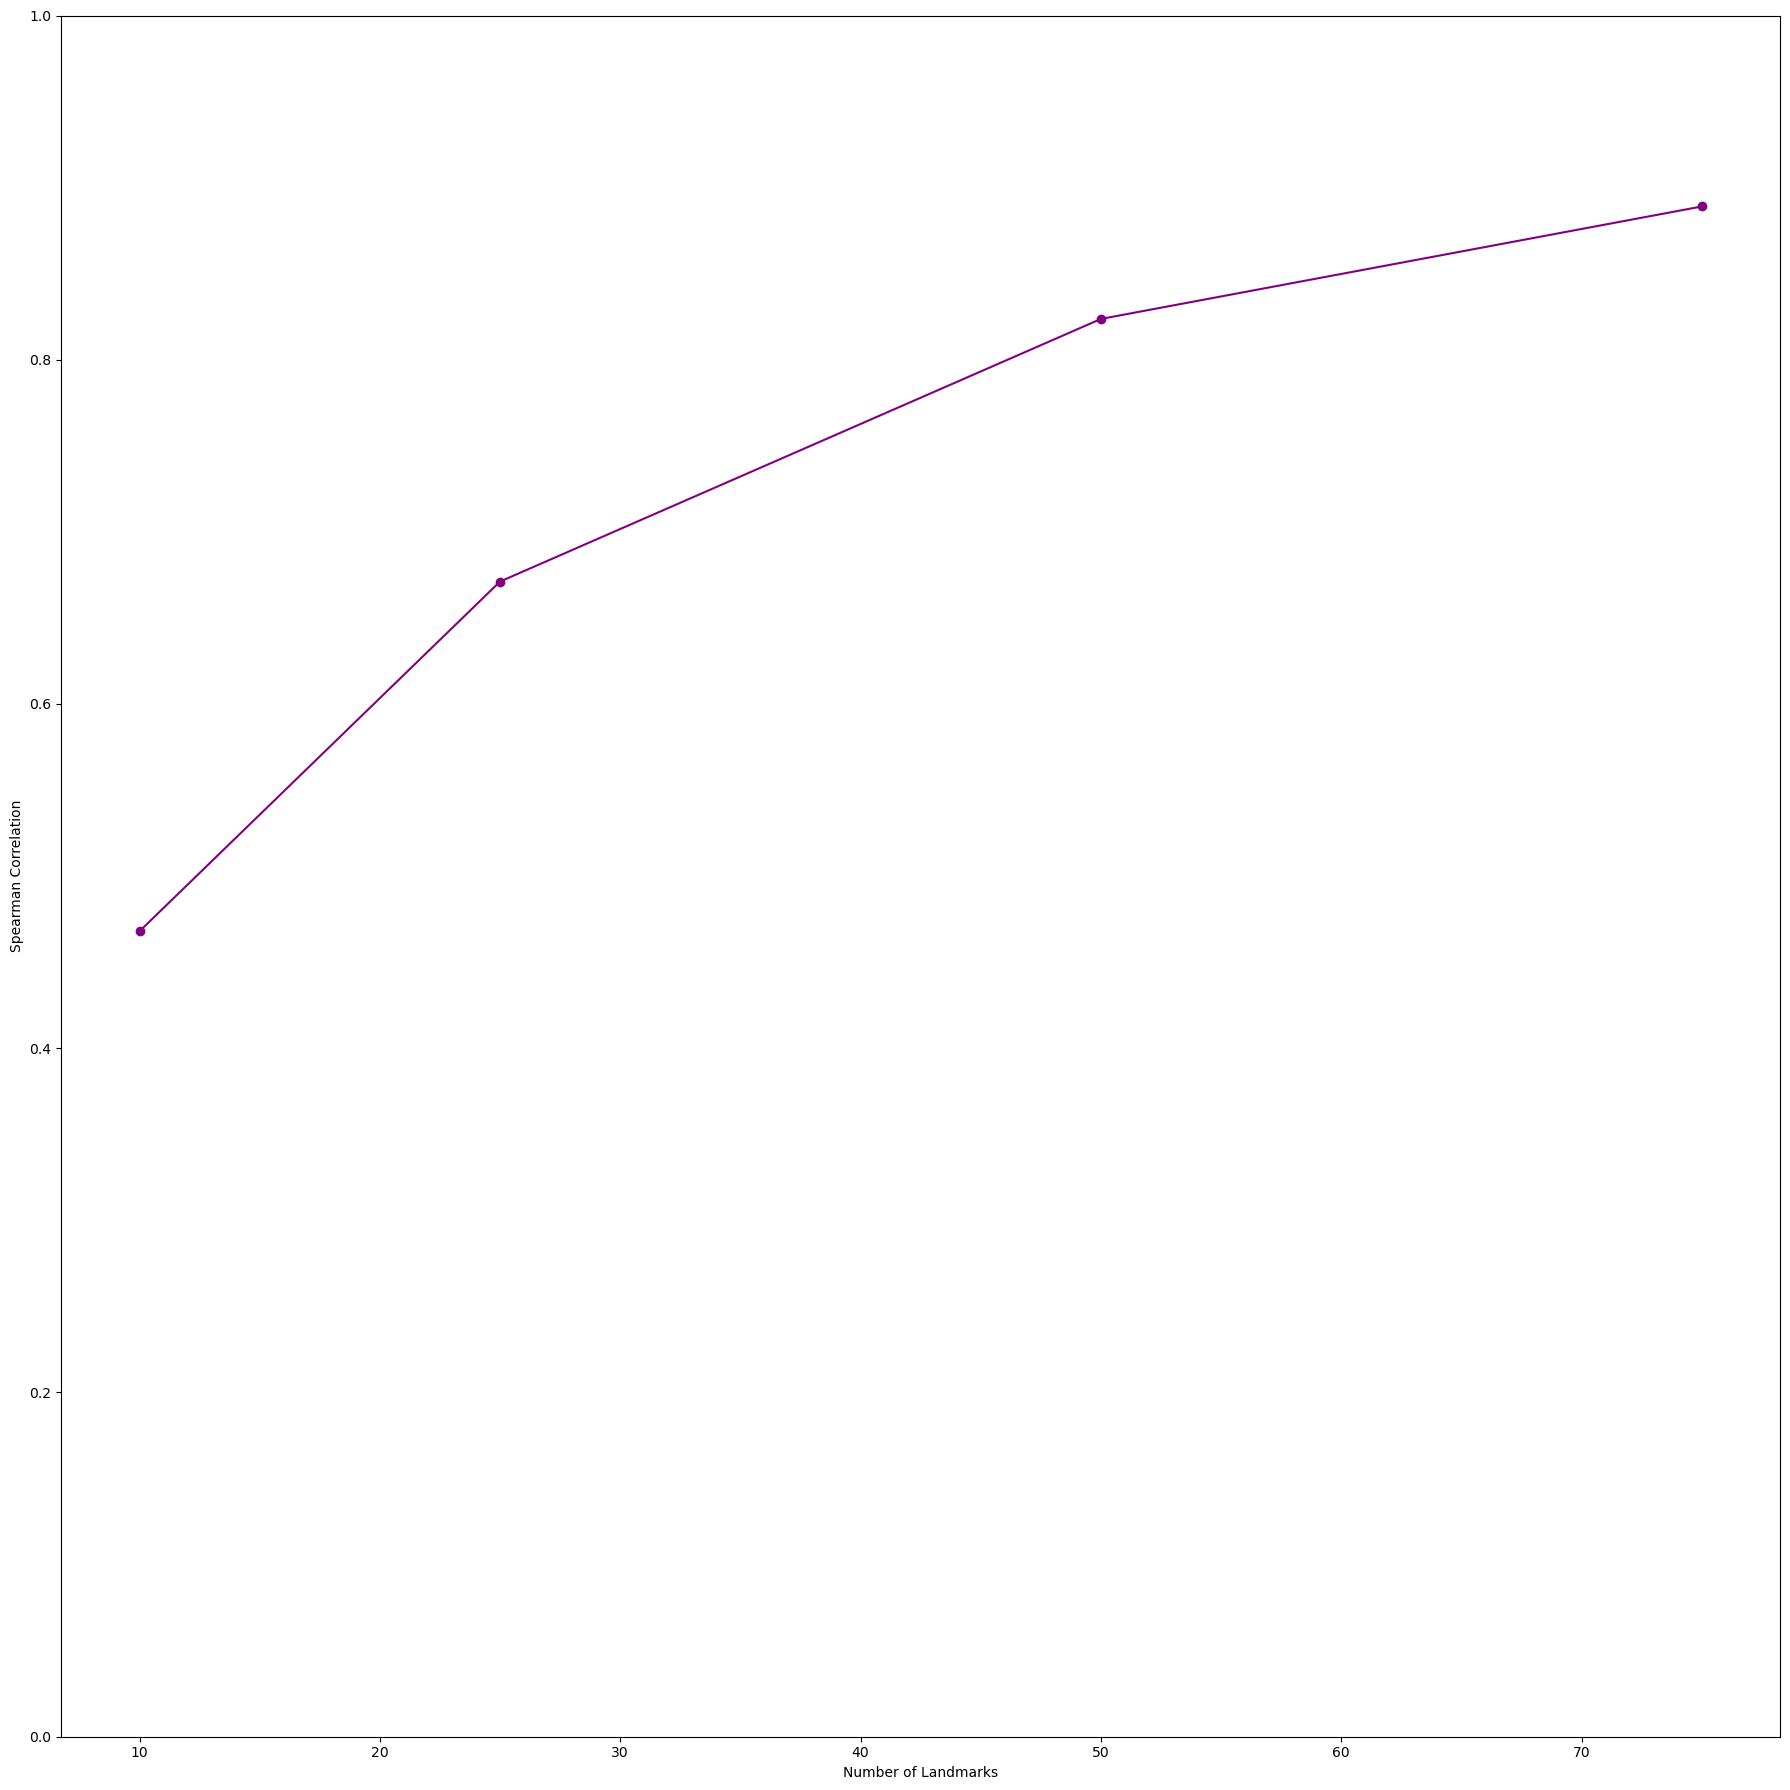

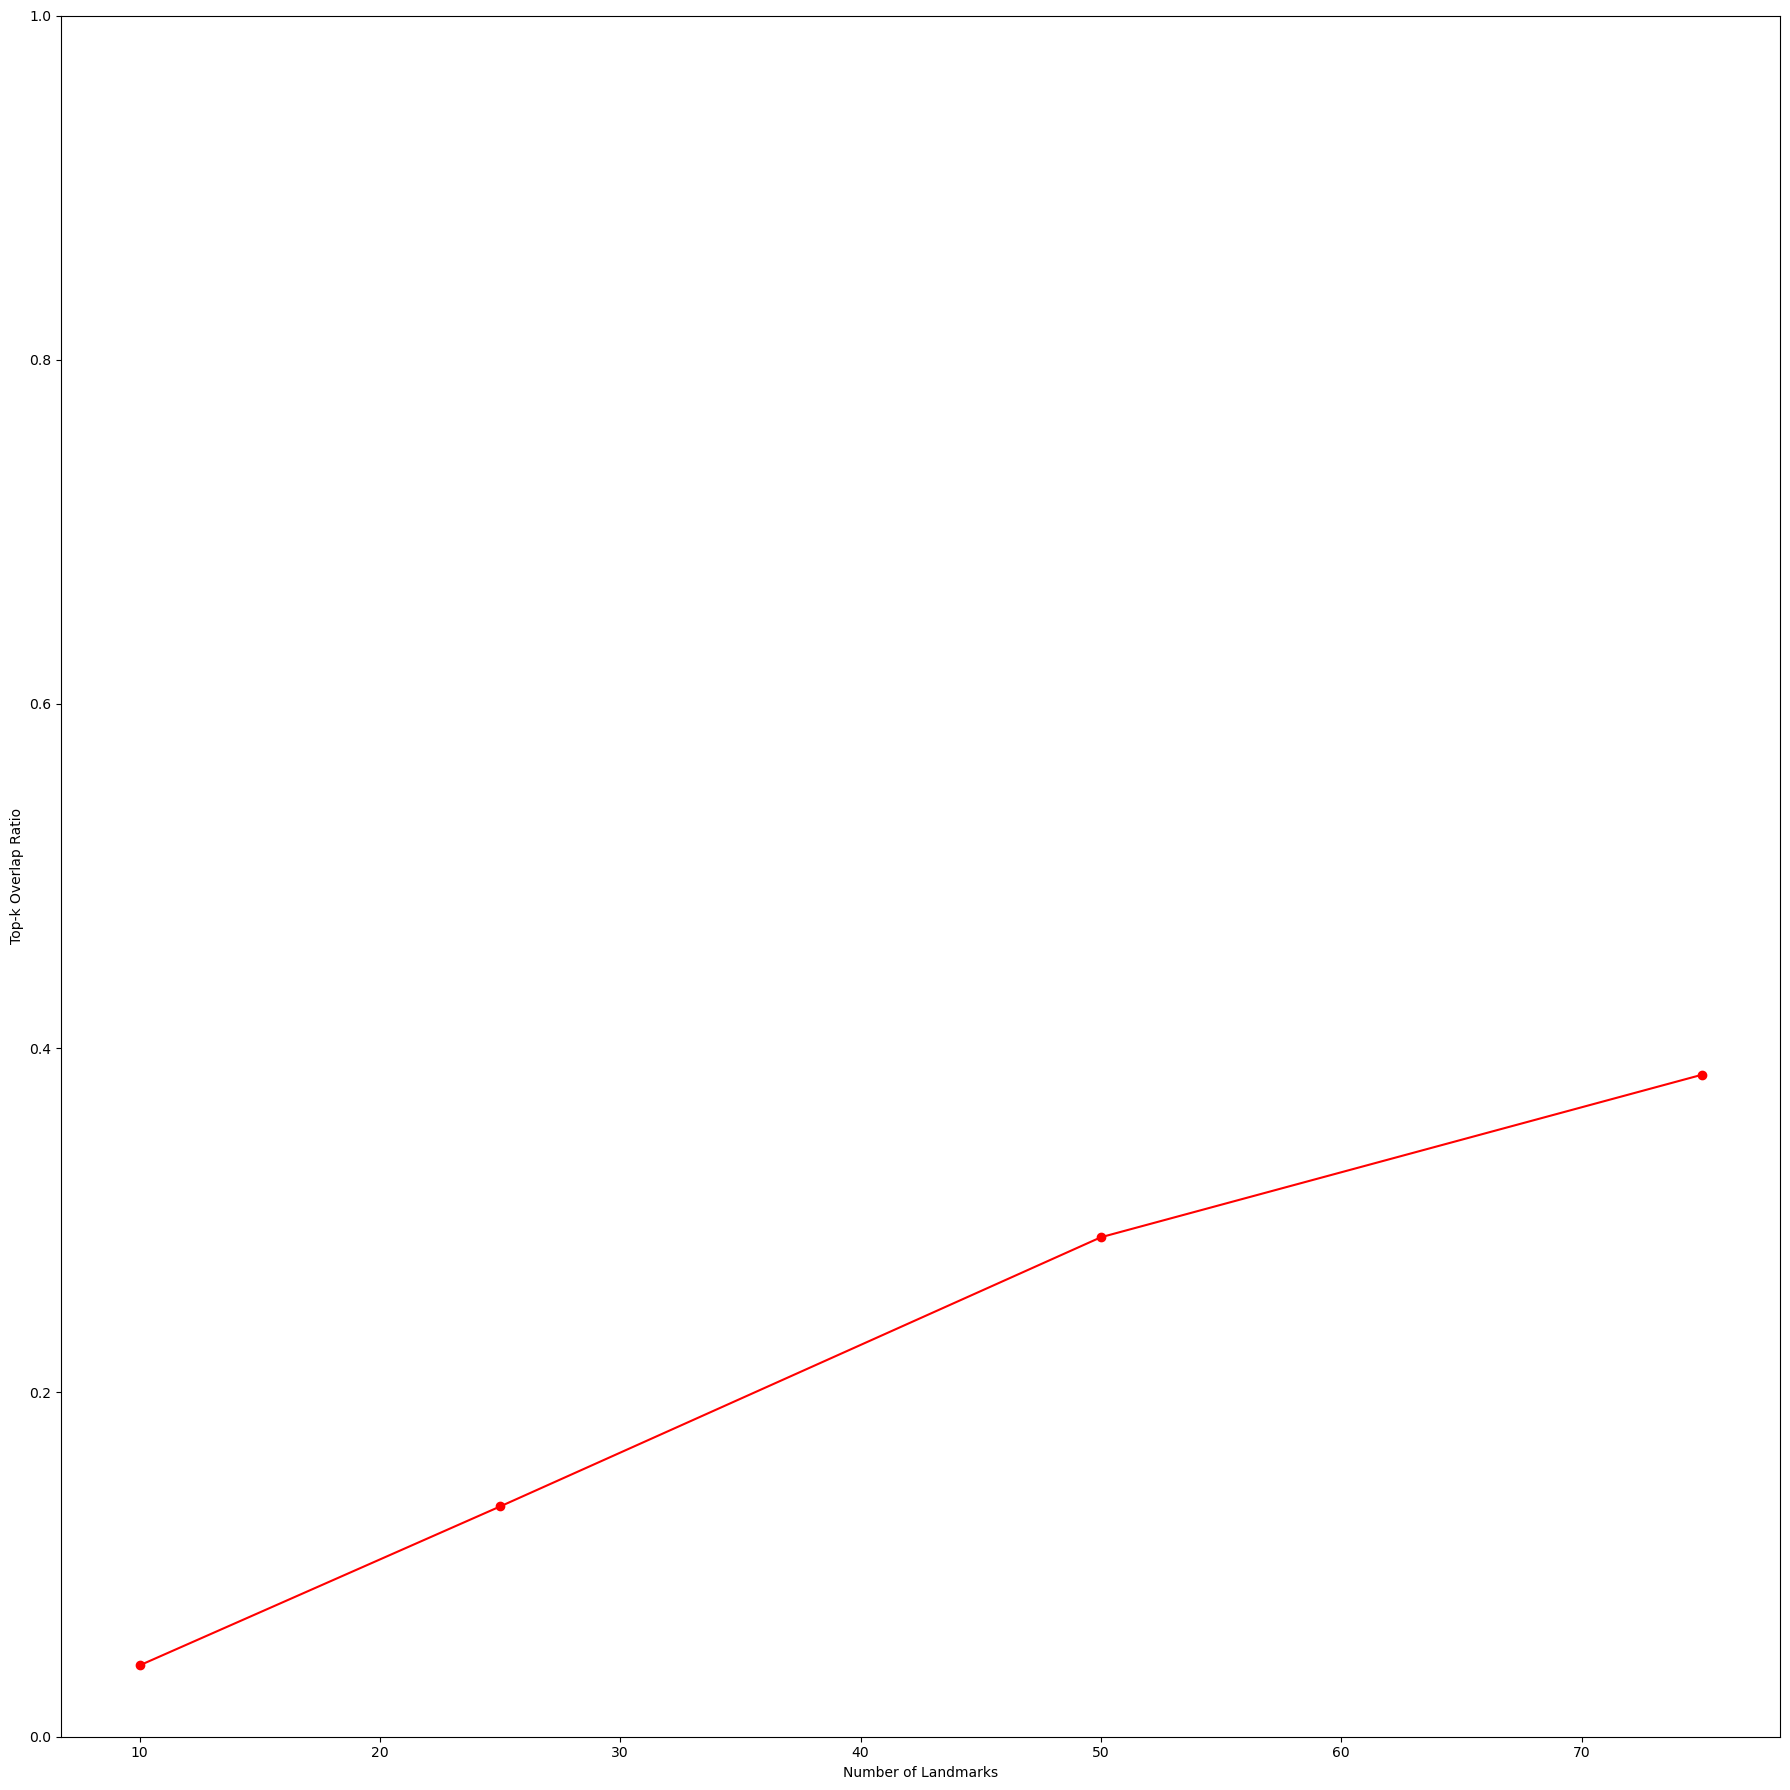

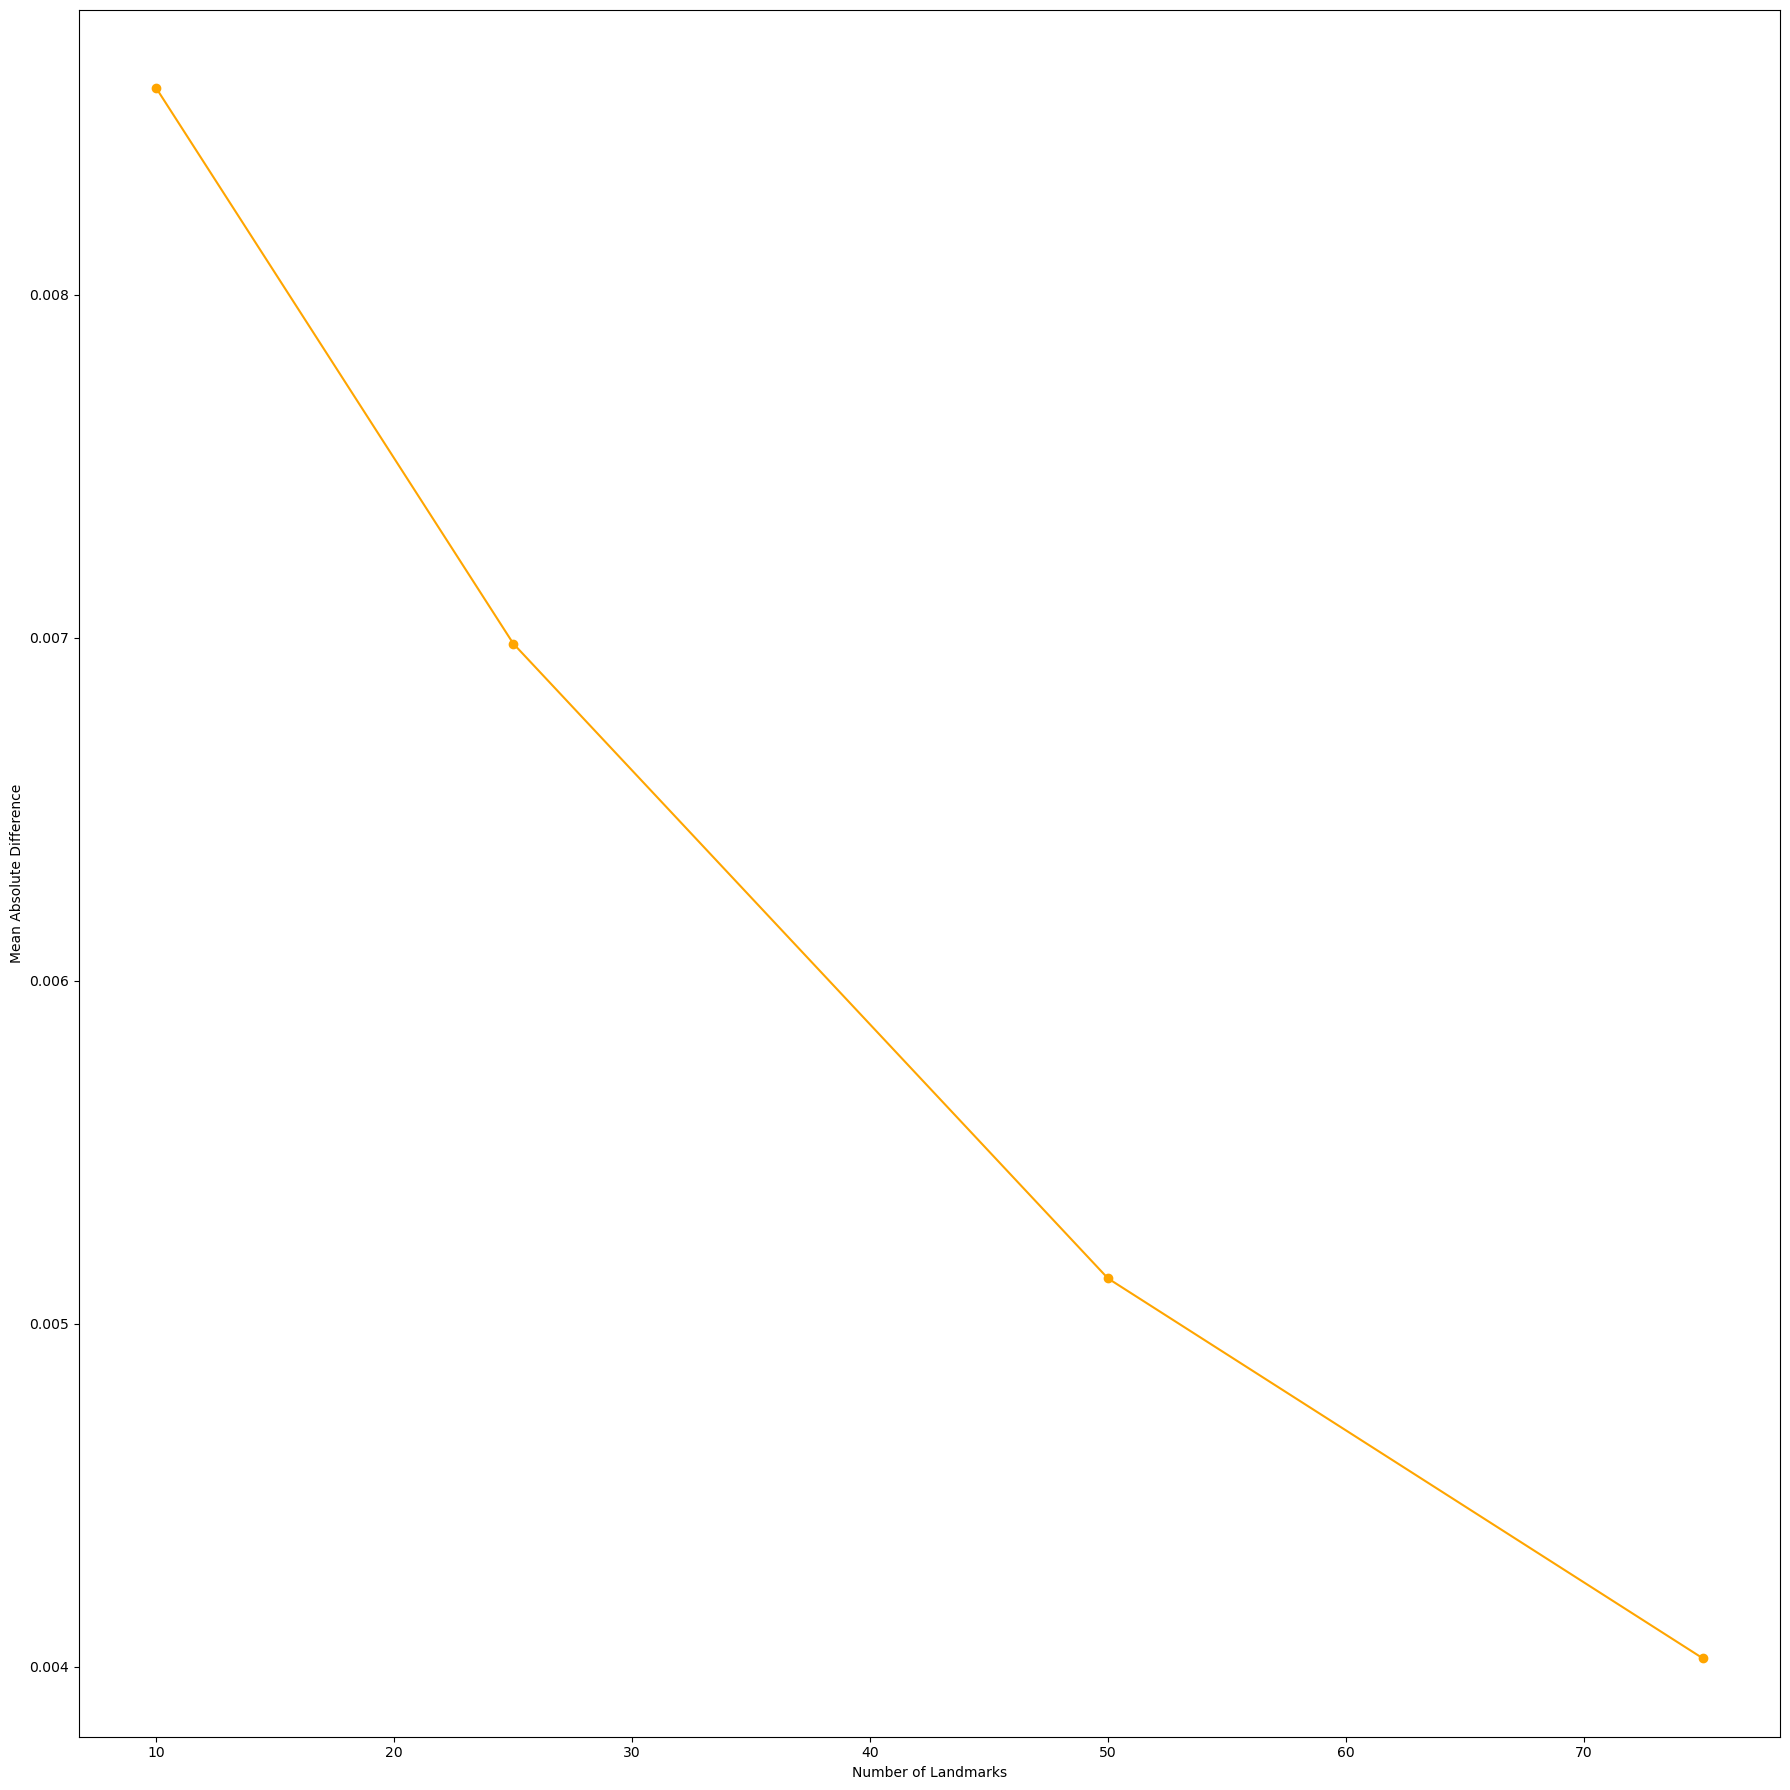

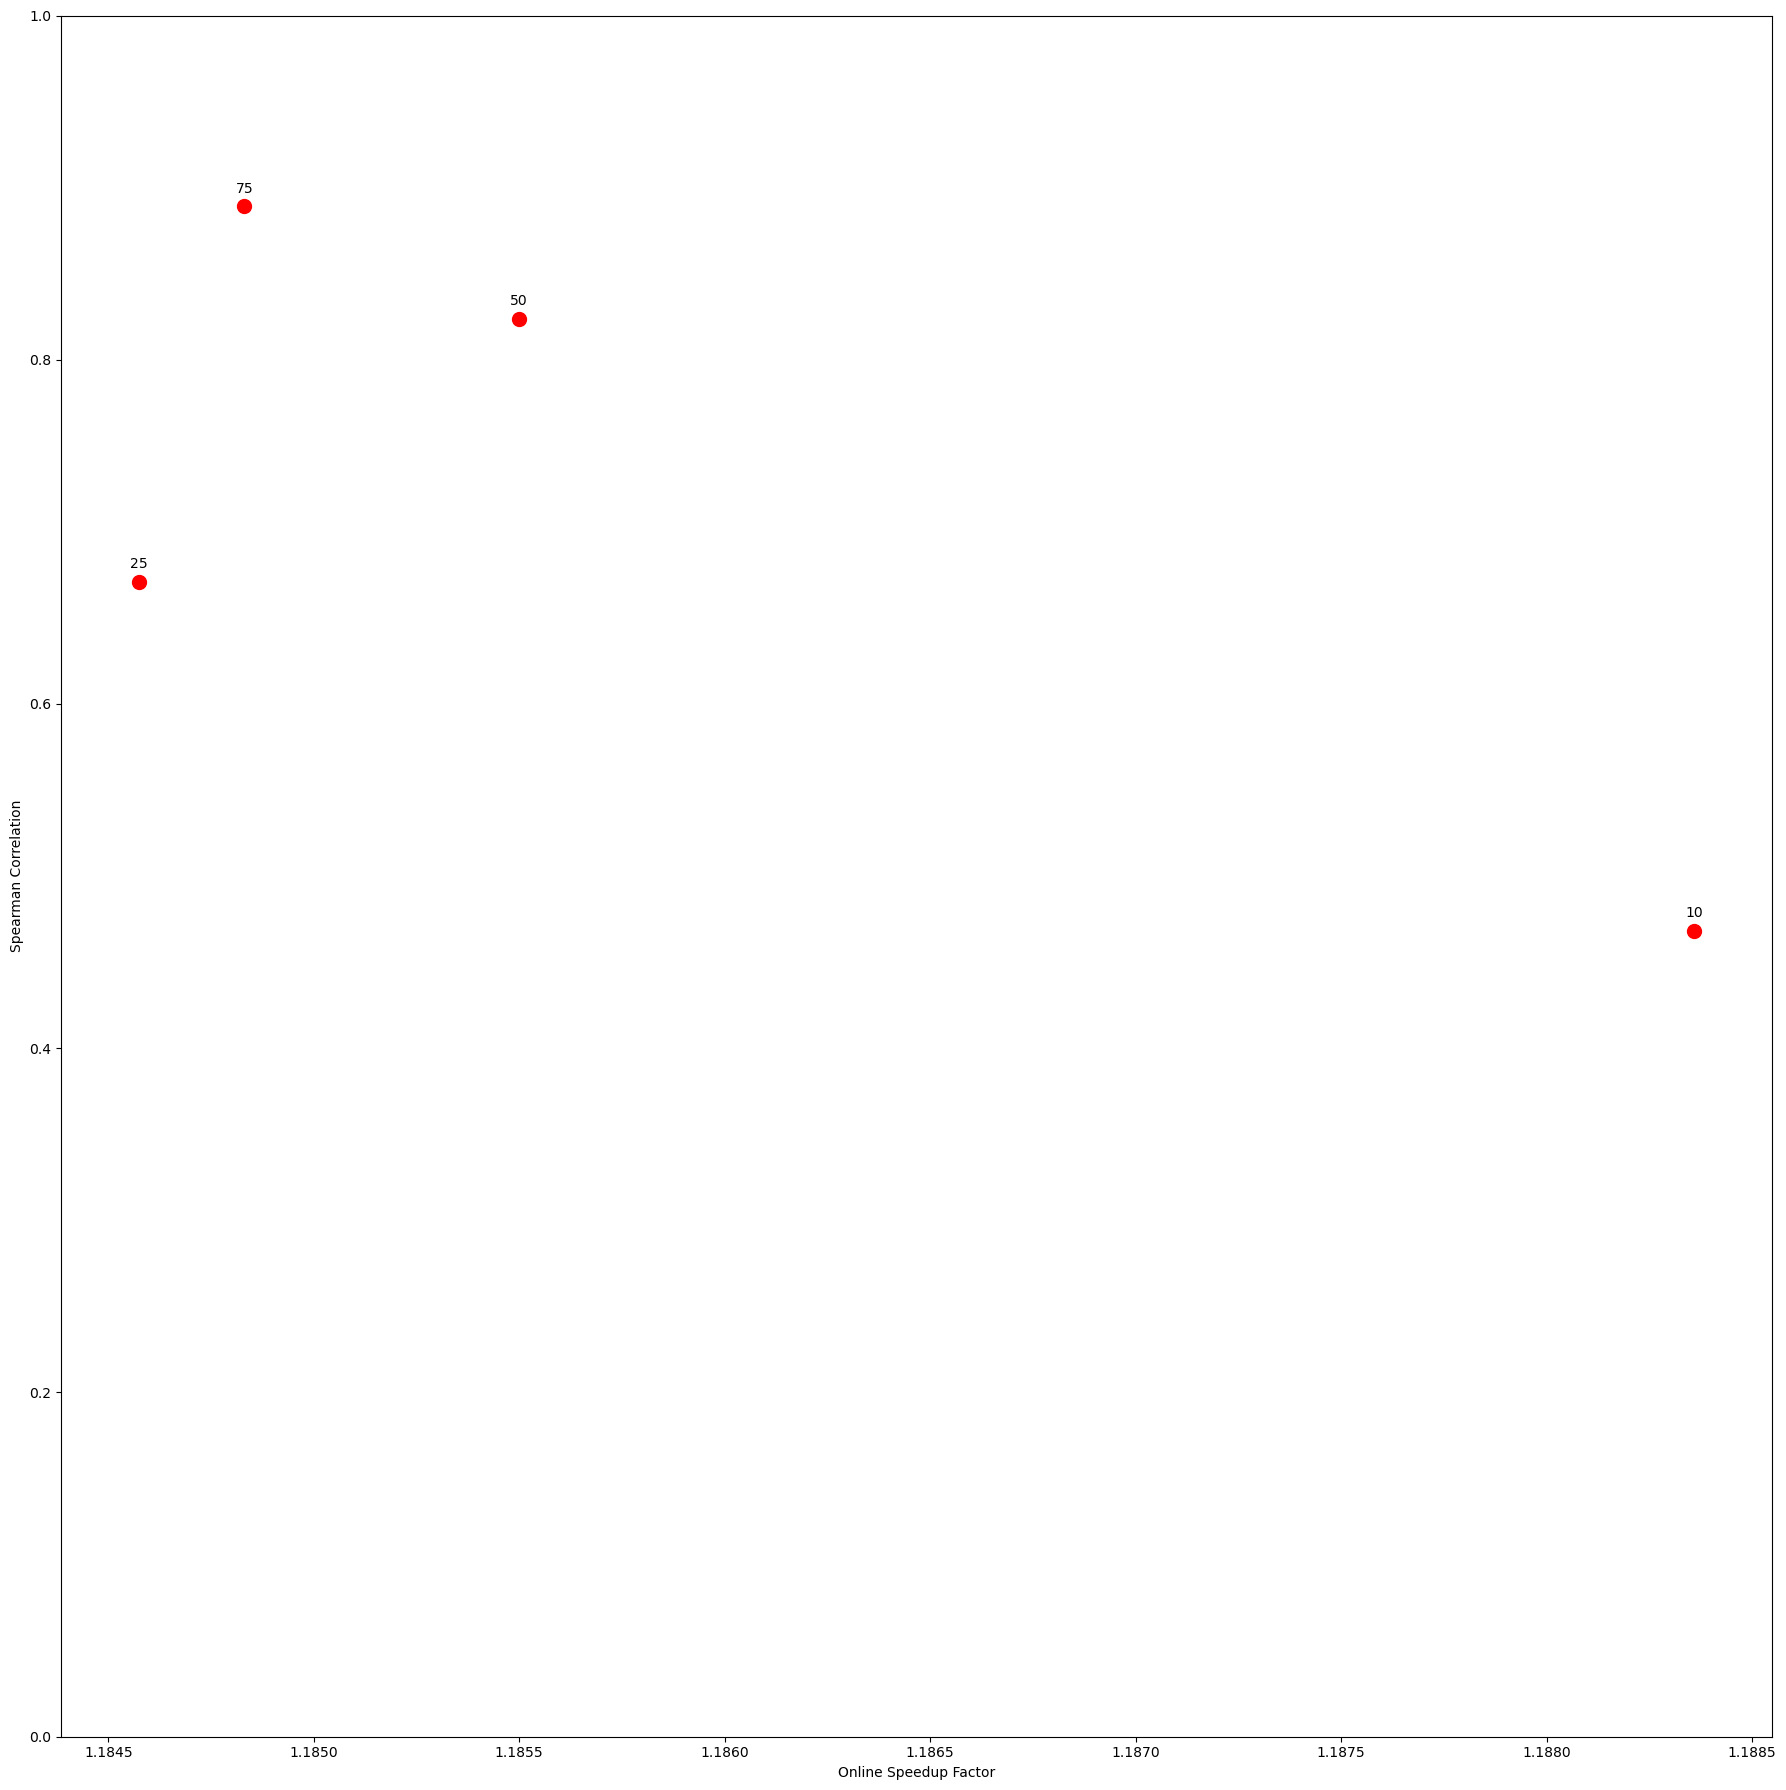

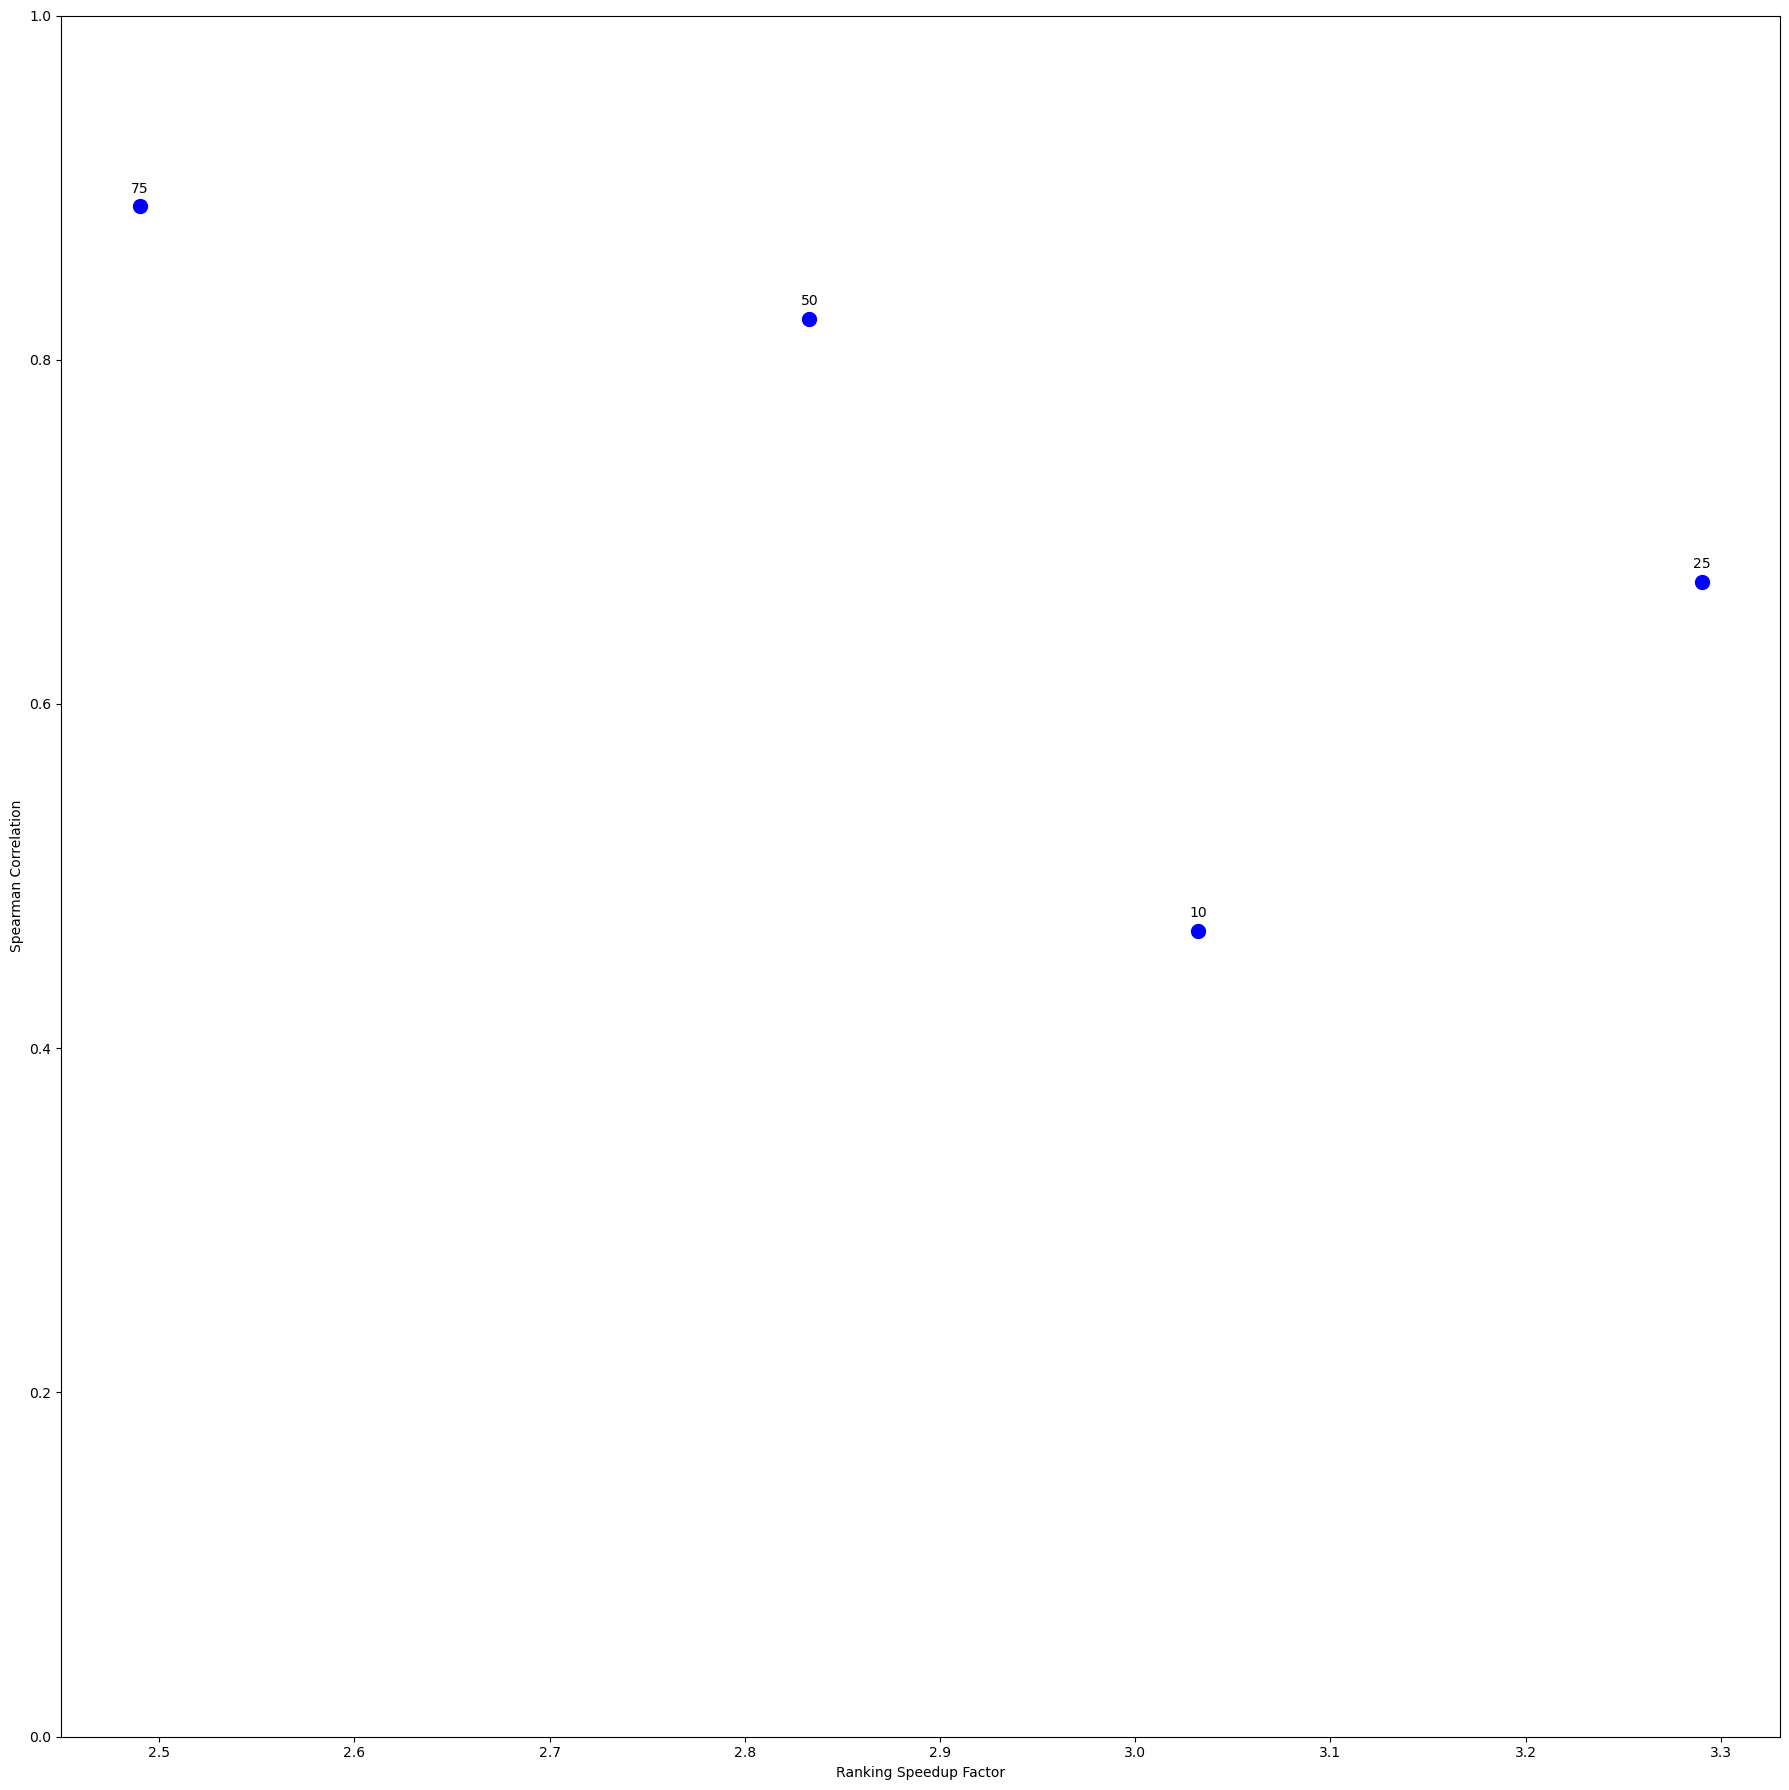


=== OVERALL SUMMARY ===
Dataset: 10000 documents, 10000 queries

Bi-Encoder Performance:
  Total offline time: 440.4460 seconds
  Average online time (per query): 0.05215 seconds (includes query encoding)
  Average ranking time (per query): 0.00108 seconds (only ranking)
  Total online time (10000 queries): 521.48010 seconds
  Total ranking time (10000 queries): 10.76522 seconds

Nyström Performance by Landmark Count:

  Nyström with 10 landmarks:
    Total offline time: 444.5508 seconds
    Average online time (per query): 0.04388 seconds (includes query encoding)
    Average ranking time (per query): 0.00036 seconds (only ranking)
    Total online time (10000 queries): 438.82389 seconds
    Total ranking time (10000 queries): 3.55032 seconds
    Online speedup vs bi-encoder: 1.19x
    Ranking speedup vs bi-encoder: 3.03x
    Similarity to bi-encoder results:
      Spearman rank correlation: 0.4680
      Top-k overlap: 0.0414
      Mean absolute score difference: 0.0086
      Top-1 m

In [2]:
from sklearn.cluster import KMeans
#!/usr/bin/env python3
# Optimized comparison of bi-encoder vs Nyström kernel approximation
# Computing document embeddings once and running bi-encoder only once per query

import os
import gzip
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.linalg import pinv
from scipy.stats import spearmanr
import torch
from transformers import AutoTokenizer, AutoModel

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

class MSMARCOEvaluator:
    """
    Evaluator for comparing bi-encoder and Nyström kernel approximation
    with optimized timing and direct score comparison
    """
    def __init__(self, data_dir="files", model_name="sentence-transformers/all-MiniLM-L6-v2", device=None):
        # File paths
        self.data_dir = data_dir
        self.queries_path = os.path.join(data_dir, "docleaderboard-queries.tsv.gz")
        self.top100_path = os.path.join(data_dir, "docleaderboard-top100.tsv.gz")
        self.fulldocs_path = os.path.join(data_dir, "fulldocs.tsv.gz")
        
        # Set device (GPU if available, otherwise CPU)
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        # Data storage
        self.queries = {}  # query_id -> query_text
        self.documents = {}  # doc_id -> doc_text
        
        # Timing metrics
        self.timing = {
            'embedding': 0,  # Shared embedding time
            'query_embedding': 0,  # Query embedding time
            'biencoder': {
                'offline': 0, 
                'online': [],  # Includes query encoding
                'ranking': []   # Only ranking computation
            },
            'nystrom': {
                'offline': {}, 
                'online': {},   # Includes query encoding
                'ranking': {}   # Only ranking computation
            }
        }
        
        # Comparison metrics
        self.comparison_metrics = {}  # Will store metrics for different landmark counts
        
        # Load model and tokenizer
        print(f"Loading {model_name} model...")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.model.to(self.device)
        self.model.eval()  # Set model to evaluation mode
        
        # Document embeddings storage (shared between both methods)
        self.doc_embeddings = {}  # doc_id -> embedding
        self.query_embeddings = {}  # query_id -> embedding
        
        # Nyström-specific data (will be different for each landmark count)
        self.nystrom_data = {}  # num_landmarks -> data
        
        # Store bi-encoder results for each query
        self.biencoder_results = {}  # query_id -> results
    
    def load_data(self, max_queries=20, max_docs=100):
        """Load a subset of MS MARCO data"""
        print("Loading MS MARCO data...")
        
        # Load queries
        self._load_queries(max_queries)
        
        # Load documents 
        self._load_documents(max_docs)
        
        print(f"Loaded {len(self.queries)} queries and {len(self.documents)} documents")
        return len(self.queries) > 0 and len(self.documents) > 0
    
    def _load_queries(self, max_queries):
        """Load queries from file"""
        try:
            with gzip.open(self.queries_path, 'rt', encoding='utf-8') as f:
                for i, line in enumerate(f):
                    if i >= max_queries:
                        break
                    
                    parts = line.strip().split('\t')
                    if len(parts) >= 2:
                        query_id = parts[0]
                        query_text = parts[1]
                        self.queries[query_id] = query_text
            
            print(f"Loaded {len(self.queries)} queries")
        
        except Exception as e:
            print(f"Error loading queries: {e}")
    
    def _load_documents(self, max_docs):
        """Load or create document content"""
        try:
            # For MS MARCO, try to load real documents first
            docs_loaded = 0
            
            with gzip.open(self.top100_path, 'rt', encoding='utf-8') as f:
                # Extract document IDs from top100 file
                doc_ids = set()
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 3:
                        # Check if query is in our loaded queries
                        query_id = parts[0]
                        if query_id in self.queries:
                            doc_id = parts[2]  # Doc ID is in position 2
                            doc_ids.add(doc_id)
                            
                            # Limit number of docs
                            if len(doc_ids) >= max_docs:
                                break
            
            print(f"Found {len(doc_ids)} unique document IDs")
            
            # Create synthetic documents (in practice, you'd load real documents)
            for i, doc_id in enumerate(doc_ids):
                self.documents[doc_id] = f"This is a synthetic document {i} for id {doc_id}. " + \
                                        "It contains text that would normally come from the real MS MARCO dataset."
            
            print(f"Created {len(self.documents)} document entries")
        
        except Exception as e:
            print(f"Error loading documents: {e}")
            
            # Fallback: Create some dummy documents
            for i in range(max_docs):
                doc_id = f"D{i+1000000}"
                self.documents[doc_id] = f"This is a synthetic document {i} with ID {doc_id}."
            
            print(f"Created {len(self.documents)} fallback document entries")
    
    def encode_text(self, text, max_length=256):
        """Encode text using the pre-trained model"""
        # Tokenize
        inputs = self.tokenizer(
            text,
            max_length=max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        ).to(self.device)
        
        # Get embeddings
        with torch.no_grad():
            outputs = self.model(**inputs)
            
            # Mean pooling - use attention mask to ignore padding tokens
            token_embeddings = outputs.last_hidden_state
            attention_mask = inputs['attention_mask']
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
            embedding = torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
            
            # Normalize embedding
            embedding = torch.nn.functional.normalize(embedding, p=2, dim=1)
        
        return embedding[0].cpu().numpy()
    
    def encode_all_documents(self):
        """Encode all documents once for both methods"""
        print("SHARED PHASE: Encoding all documents (used by both methods)...")
        
        # Clear existing embeddings
        self.doc_embeddings = {}
        
        start_time = time.time()
        
        # Encode all documents
        for doc_id, doc_text in tqdm(self.documents.items(), desc="Encoding documents"):
            self.doc_embeddings[doc_id] = self.encode_text(doc_text)
        
        # Record shared embedding time
        encoding_time = time.time() - start_time
        self.timing['embedding'] = encoding_time
        
        print(f"Encoded {len(self.doc_embeddings)} documents in {encoding_time:.2f} seconds")
        print(f"Average time per document: {encoding_time / len(self.documents):.5f} seconds")

    def encode_all_queries(self):
        """Encode all queries once for both methods"""
        print("SHARED PHASE: Encoding all queries (used by both methods)...")
        
        self.query_embeddings = {}  # Initialize dictionary to store query embeddings
        
        start_time = time.time()
        
        # Encode all queries
        for query_id, query_text in tqdm(self.queries.items(), desc="Encoding queries"):
            self.query_embeddings[query_id] = self.encode_text(query_text)
        
        encoding_time = time.time() - start_time
        self.timing['query_embedding'] = encoding_time
        
        print(f"Encoded {len(self.query_embeddings)} queries in {encoding_time:.2f} seconds")
        print(f"Average time per query: {encoding_time / len(self.queries):.5f} seconds")
    
    def setup_biencoder(self):
        """Set up standard bi-encoder (OFFLINE phase)"""
        print("BIENCODER OFFLINE PHASE: Nothing to do (embeddings already computed)")
        
        # No additional offline processing needed for bi-encoder
        # Just account for the embedding time in the offline time
        self.timing['biencoder']['offline'] = 0  # Additional offline time (zero for bi-encoder)
    
    def setup_nystrom_approximation(self, num_landmarks=10):
        """Set up Nyström kernel approximation (OFFLINE phase) with k-Means landmark selection"""
        print(f"NYSTROM OFFLINE PHASE: Setting up with {num_landmarks} landmarks using k-Means...")
        start_time = time.time()

        # 1. Get all document embeddings
        all_doc_ids = list(self.doc_embeddings.keys())
        doc_embeddings = np.array([self.doc_embeddings[doc_id] for doc_id in all_doc_ids])

        # 2. Perform k-Means clustering to select landmarks
        kmeans = KMeans(n_clusters=num_landmarks, random_state=42)
        kmeans.fit(doc_embeddings)
        
        # Find documents closest to each cluster center
        distances = kmeans.transform(doc_embeddings)  # shape: (n_docs, n_clusters)
        landmark_indices = np.argmin(distances, axis=0)
        landmark_docs = [all_doc_ids[idx] for idx in landmark_indices]
        landmark_embeddings = np.array([self.doc_embeddings[doc_id] for doc_id in landmark_docs])

        # Rest of the method remains the same...
        # 3. Compute W and its pseudoinverse
        W = np.dot(landmark_embeddings, landmark_embeddings.T)
        W_inv = np.linalg.pinv(W)  # shape: [num_landmarks, num_landmarks]

        # 4. Precompute document features: (doc_embeddings @ landmarks.T) @ W_inv
        doc_embeddings_matrix = np.array([self.doc_embeddings[doc_id] for doc_id in all_doc_ids])  # shape: [num_docs, dim]
        C = np.dot(doc_embeddings_matrix, landmark_embeddings.T)  # shape: [num_docs, num_landmarks]
        doc_features = np.dot(C, W_inv.T)  # shape: [num_docs, num_landmarks]

        # 5. Ensure contiguous memory layout for maximum BLAS speed
        doc_features = np.ascontiguousarray(doc_features)
        landmark_embeddings = np.ascontiguousarray(landmark_embeddings)

        # 6. Store all data for this landmark configuration
        self.nystrom_data[num_landmarks] = {
            'landmark_docs': landmark_docs,
            'landmark_embeddings': landmark_embeddings,
            'W_inv': W_inv,
            'doc_features': doc_features,
            'doc_ids': np.array(all_doc_ids)
        }

        # Record offline time for this landmark count
        setup_time = time.time() - start_time
        self.timing['nystrom']['offline'][num_landmarks] = setup_time
        print(f"Nyström setup completed in {setup_time:.2f} seconds")
    
    def search_biencoder(self, query_id, top_k=10):
        """Search using standard bi-encoder approach (ONLINE phase)"""
        if not self.doc_embeddings:
            print("Document embeddings not available. Call encode_all_documents() first.")
            return None, 0, 0
        
        # Check if we already have results for this query
        if query_id in self.biencoder_results:
            return self.biencoder_results[query_id], 0, 0
        
        # Get precomputed query embedding
        query_embedding = self.query_embeddings[query_id]
        
        # Start timing (ONLINE phase - includes query encoding)
        start_time = time.time()
        
        # Compute similarities with all documents
        doc_ids = list(self.doc_embeddings.keys())
        doc_embeddings = np.array([self.doc_embeddings[doc_id] for doc_id in doc_ids])
        
        similarities = np.dot(doc_embeddings, query_embedding)
        
        # Sort by similarity and get top k
        sorted_indices = np.argsort(similarities)[::-1][:top_k]
        
        # End timing (total online time)
        online_time = time.time() - start_time + self.timing['query_embedding'] / len(self.queries)
        
        # Start timing for ranking only (without query encoding)
        ranking_start = time.time()
        _ = np.dot(doc_embeddings, query_embedding)
        sorted_indices = np.argsort(similarities)[::-1][:top_k]
        ranking_time = time.time() - ranking_start
        
        # Store timing
        self.timing['biencoder']['online'].append(online_time)
        self.timing['biencoder']['ranking'].append(ranking_time)
        
        # Prepare results
        results = {
            'query_id': query_id,
            'query_text': self.queries[query_id],
            'top_k_docs': [],
            'all_scores': dict(zip(doc_ids, similarities))
        }
        
        # Add top k results
        for idx in sorted_indices:
            doc_id = doc_ids[idx]
            score = float(similarities[idx])
            
            results['top_k_docs'].append({
                'doc_id': doc_id,
                'score': score,
                'text': self.documents[doc_id][:100] + "..."
            })
        
        # Store results
        self.biencoder_results[query_id] = results
        
        return results, online_time, ranking_time
    
    def search_nystrom(self, query_id, num_landmarks, top_k=10):
        """Optimized search using Nyström kernel approximation (ONLINE phase)"""
        if num_landmarks not in self.nystrom_data:
            print(f"Nyström data for {num_landmarks} landmarks not found. Call setup_nystrom_approximation() first.")
            return None, 0, 0
        
        data = self.nystrom_data[num_landmarks]
        
        # Get precomputed query embedding
        query_embedding = self.query_embeddings[query_id]
        
        # Start timing (ONLINE phase - includes query encoding)
        start_time = time.time()
        
        # Compute query features
        query_C = np.dot(query_embedding, data['landmark_embeddings'].T)
        
        # Compute scores
        similarities = np.dot(data['doc_features'], query_C)
        
        # Get top-k docs
        top_k_indices = np.argpartition(similarities, -top_k)[-top_k:]
        top_k_indices = top_k_indices[np.argsort(similarities[top_k_indices])[::-1]]
        
        # End timing (total online time)
        online_time = time.time() - start_time + self.timing['query_embedding'] / len(self.queries)
        
        # Start timing for ranking only (without query encoding)
        ranking_start = time.time()
        _ = np.dot(query_embedding, data['landmark_embeddings'].T)
        _ = np.dot(data['doc_features'], query_C)
        top_k_indices = np.argpartition(similarities, -top_k)[-top_k:]
        _ = top_k_indices[np.argsort(similarities[top_k_indices])[::-1]]
        ranking_time = time.time() - ranking_start
        
        # Store timing
        if num_landmarks not in self.timing['nystrom']['online']:
            self.timing['nystrom']['online'][num_landmarks] = []
            self.timing['nystrom']['ranking'][num_landmarks] = []
            
        self.timing['nystrom']['online'][num_landmarks].append(online_time)
        self.timing['nystrom']['ranking'][num_landmarks].append(ranking_time)
        
        # Prepare results
        results = {
            'query_id': query_id,
            'query_text': self.queries[query_id],
            'top_k_docs': [{
                'doc_id': data['doc_ids'][idx],
                'score': float(similarities[idx]),
                'text': self.documents[data['doc_ids'][idx]][:100] + "..."
            } for idx in top_k_indices],
            'all_scores': dict(zip(data['doc_ids'], similarities))
        }

        return results, online_time, ranking_time
    
    def compare_scores(self, biencoder_results, nystrom_results):
        """Compare scores between bi-encoder and Nyström methods"""
        # Get all document IDs
        doc_ids = set(biencoder_results['all_scores'].keys())
        
        # Get scores for each method
        be_scores = np.array([biencoder_results['all_scores'][doc_id] for doc_id in doc_ids])
        ny_scores = np.array([nystrom_results['all_scores'][doc_id] for doc_id in doc_ids])
        
        # Calculate score differences
        abs_diff = np.abs(be_scores - ny_scores)
        mean_abs_diff = np.mean(abs_diff)
        max_abs_diff = np.max(abs_diff)
        
        # Calculate relative differences
        # Avoid division by zero
        be_abs = np.abs(be_scores)
        valid_indices = be_abs > 1e-10
        rel_diff = np.zeros_like(abs_diff)
        rel_diff[valid_indices] = abs_diff[valid_indices] / be_abs[valid_indices]
        mean_rel_diff = np.mean(rel_diff)
        
        # Calculate rank correlation (Spearman)
        corr, _ = spearmanr(be_scores, ny_scores)
        
        # Calculate top-k overlap
        k = min(10, len(biencoder_results['top_k_docs']))
        be_top_k = set(doc['doc_id'] for doc in biencoder_results['top_k_docs'][:k])
        ny_top_k = set(doc['doc_id'] for doc in nystrom_results['top_k_docs'][:k])
        overlap = len(be_top_k.intersection(ny_top_k)) / k
        
        # Calculate top-1 match
        top1_match = biencoder_results['top_k_docs'][0]['doc_id'] == nystrom_results['top_k_docs'][0]['doc_id']
        
        return {
            'mean_abs_diff': mean_abs_diff,
            'max_abs_diff': max_abs_diff,
            'mean_rel_diff': mean_rel_diff,
            'spearman_corr': corr,
            'top_k_overlap': overlap,
            'top1_match': top1_match
        }
    
    def run_all_queries_with_biencoder(self, query_ids, top_k=10):
        """Run bi-encoder retrieval once for all queries and store results"""
        print(f"Running bi-encoder retrieval for {len(query_ids)} queries...")
        
        # Reset timing
        self.timing['biencoder']['online'] = []
        self.timing['biencoder']['ranking'] = []
        
        # Run bi-encoder for each query
        for query_id in tqdm(query_ids, desc="Bi-encoder retrieval"):
            self.search_biencoder(query_id, top_k)
    
    def compare_performance(self, landmark_counts, query_ids, top_k=10):
        """Compare performance between bi-encoder and Nyström for multiple landmark counts"""
        print("\nComparing bi-encoder and Nyström methods for multiple landmark counts...")
        
        # Initialize storage
        self.comparison_metrics = {count: [] for count in landmark_counts}
        
        # Encode all queries upfront
        self.encode_all_queries()
        
        # Setup bi-encoder
        self.setup_biencoder()
        
        # Step 1: Run bi-encoder retrieval once for all queries
        self.run_all_queries_with_biencoder(query_ids, top_k)
        
        # Step 2: Setup and test Nyström for each landmark count
        results_list = []
        
        for num_landmarks in landmark_counts:
            print(f"\nTesting with {num_landmarks} landmarks...")
            
            # Setup Nyström for this landmark count
            self.setup_nystrom_approximation(num_landmarks)
            
            # Reset online timing for this landmark count
            self.timing['nystrom']['online'][num_landmarks] = []
            self.timing['nystrom']['ranking'][num_landmarks] = []
            
            # Run Nyström for each query and compare with stored bi-encoder results
            for query_id in tqdm(query_ids, desc=f"Nyström-{num_landmarks} retrieval"):
                # Get bi-encoder results
                biencoder_results = self.biencoder_results[query_id]
                
                # Run Nyström search
                nystrom_results, _, _ = self.search_nystrom(query_id, num_landmarks, top_k)
                
                # Compare scores
                comparison = self.compare_scores(biencoder_results, nystrom_results)
                self.comparison_metrics[num_landmarks].append(comparison)
        
        # Calculate all metrics after running all queries
        return self._calculate_final_metrics(landmark_counts, query_ids)
    
    def _calculate_final_metrics(self, landmark_counts, query_ids):
        """Calculate and print all final metrics after running all queries"""
        results_list = []
        
        # Calculate bi-encoder metrics
        biencoder_avg_online = np.mean(self.timing['biencoder']['online'])
        biencoder_avg_ranking = np.mean(self.timing['biencoder']['ranking'])
        biencoder_total_offline = self.timing['embedding'] + self.timing['biencoder']['offline']
        
        for num_landmarks in landmark_counts:
            # Calculate average comparison metrics for this landmark count
            avg_metrics = {}
            for metric in self.comparison_metrics[num_landmarks][0].keys():
                avg_metrics[metric] = np.mean([m[metric] for m in self.comparison_metrics[num_landmarks]])
            
            # Calculate timing metrics
            nystrom_avg_online = np.mean(self.timing['nystrom']['online'][num_landmarks])
            nystrom_avg_ranking = np.mean(self.timing['nystrom']['ranking'][num_landmarks])
            nystrom_total_offline = self.timing['embedding'] + self.timing['nystrom']['offline'][num_landmarks]
            
            # Calculate speedups
            online_speedup = biencoder_avg_online / nystrom_avg_online if nystrom_avg_online > 0 else 0
            ranking_speedup = biencoder_avg_ranking / nystrom_avg_ranking if nystrom_avg_ranking > 0 else 0
            
            # Store results for this landmark count
            results_list.append({
                'biencoder': {
                    'offline': biencoder_total_offline,
                    'online_avg': biencoder_avg_online,
                    'ranking_avg': biencoder_avg_ranking,
                    'online_total': biencoder_avg_online * len(query_ids),
                    'ranking_total': biencoder_avg_ranking * len(query_ids)
                },
                'nystrom': {
                    'offline': nystrom_total_offline,
                    'online_avg': nystrom_avg_online,
                    'ranking_avg': nystrom_avg_ranking,
                    'online_total': nystrom_avg_online * len(query_ids),
                    'ranking_total': nystrom_avg_ranking * len(query_ids),
                    'landmarks': num_landmarks
                },
                'comparison': {
                    'online_speedup': online_speedup,
                    'ranking_speedup': ranking_speedup,
                    'metrics': avg_metrics
                }
            })
        
        return results_list
    
    def plot_results(self, results_list):
        """Plot performance comparison results for multiple configurations"""
        
        
        # Extract landmark counts and timing data
        landmark_counts = [result['nystrom']['landmarks'] for result in results_list]
        biencoder_offline = results_list[0]['biencoder']['offline']  # Same for all
        biencoder_online = results_list[0]['biencoder']['online_avg']  # Same for all
        biencoder_ranking = results_list[0]['biencoder']['ranking_avg']  # Same for all
        nystrom_offline = [result['nystrom']['offline'] for result in results_list]
        nystrom_online = [result['nystrom']['online_avg'] for result in results_list]
        nystrom_ranking = [result['nystrom']['ranking_avg'] for result in results_list]
        
        # Extract comparison metrics
        spearman_corrs = [result['comparison']['metrics']['spearman_corr'] for result in results_list]
        top_k_overlaps = [result['comparison']['metrics']['top_k_overlap'] for result in results_list]
        mean_abs_diffs = [result['comparison']['metrics']['mean_abs_diff'] for result in results_list]
        online_speedups = [result['comparison']['online_speedup'] for result in results_list]
        ranking_speedups = [result['comparison']['ranking_speedup'] for result in results_list]
        
        plt.tight_layout()
        plt.savefig(os.path.join('graphs', 'performance_comparison_kmeans.png'))

        # Save individual plots without titles
        plt.figure(figsize=(18, 18))

        # Offline times
        plt.bar(range(len(landmark_counts) + 1), [biencoder_offline] + nystrom_offline, 
                color=['blue'] + ['green'] * len(landmark_counts))
        plt.xticks(range(len(landmark_counts) + 1), 
                ['Bi-Encoder'] + [f'Nyström-{n}' for n in landmark_counts])
        plt.ylabel('Time (seconds)')
        plt.tight_layout()
        plt.savefig(os.path.join('graphs', 'offline_times_kmeans.png'))

        # Online times
        plt.figure(figsize=(18, 18))
        plt.bar(range(len(landmark_counts) + 1), [biencoder_online] + nystrom_online, 
                color=['blue'] + ['green'] * len(landmark_counts))
        plt.xticks(range(len(landmark_counts) + 1), 
                ['Bi-Encoder'] + [f'Nyström-{n}' for n in landmark_counts])
        plt.ylabel('Time (seconds)')
        plt.tight_layout()
        plt.savefig(os.path.join('graphs', 'online_times_kmeans.png'))

        # Ranking times
        plt.figure(figsize=(18, 18))
        plt.bar(range(len(landmark_counts) + 1), [biencoder_ranking] + nystrom_ranking, 
                color=['blue'] + ['green'] * len(landmark_counts))
        plt.xticks(range(len(landmark_counts) + 1), 
                ['Bi-Encoder'] + [f'Nyström-{n}' for n in landmark_counts])
        plt.ylabel('Time (seconds)')
        plt.tight_layout()
        plt.savefig(os.path.join('graphs', 'ranking_times_kmeans.png'))

        # Spearman Correlation
        plt.figure(figsize=(18, 18))
        plt.plot(landmark_counts, spearman_corrs, 'o-', color='purple')
        plt.xlabel('Number of Landmarks')
        plt.ylabel('Spearman Correlation')
        plt.ylim([0, 1])
        plt.tight_layout()
        plt.savefig(os.path.join('graphs', 'spearman_correlation_kmeans.png'))

        # Top-k Overlap
        plt.figure(figsize=(18, 18))
        plt.plot(landmark_counts, top_k_overlaps, 'o-', color='red')
        plt.xlabel('Number of Landmarks')
        plt.ylabel('Top-k Overlap Ratio')
        plt.ylim([0, 1])
        plt.tight_layout()
        plt.savefig(os.path.join('graphs', 'topk_overlap_kmeans.png'))

        # Mean Absolute Difference
        plt.figure(figsize=(18, 18))
        plt.plot(landmark_counts, mean_abs_diffs, 'o-', color='orange')
        plt.xlabel('Number of Landmarks')
        plt.ylabel('Mean Absolute Difference')
        plt.tight_layout()
        plt.savefig(os.path.join('graphs', 'mean_abs_diff_kmeans.png'))

        # Online Speedup vs Quality Tradeoff
        plt.figure(figsize=(18, 18))
        plt.scatter(online_speedups, spearman_corrs, c='red', s=100)
        for i, n in enumerate(landmark_counts):
            plt.annotate(f"{n}", (online_speedups[i], spearman_corrs[i]), 
                        textcoords="offset points", xytext=(0,10), ha='center')
        plt.xlabel('Online Speedup Factor')
        plt.ylabel('Spearman Correlation')
        plt.ylim([0, 1])
        plt.tight_layout()
        plt.savefig(os.path.join('graphs', 'online_speedup_vs_quality_kmeans.png'))

        # Ranking Speedup vs Quality Tradeoff
        plt.figure(figsize=(18, 18))
        plt.scatter(ranking_speedups, spearman_corrs, c='blue', s=100)
        for i, n in enumerate(landmark_counts):
            plt.annotate(f"{n}", (ranking_speedups[i], spearman_corrs[i]), 
                        textcoords="offset points", xytext=(0,10), ha='center')
        plt.xlabel('Ranking Speedup Factor')
        plt.ylabel('Spearman Correlation')
        plt.ylim([0, 1])
        plt.tight_layout()
        plt.savefig(os.path.join('graphs', 'ranking_speedup_vs_quality_kmeans.png'))

        plt.show()

def main():
    # CUSTOMIZABLE PARAMETERS
    NUM_QUERIES = 10000    # Number of queries to evaluate
    NUM_DOCS = 10000      # Number of documents to use
    LANDMARK_COUNTS = [10, 25, 50, 75]  # Number of landmarks to test
    
    # Create evaluator
    evaluator = MSMARCOEvaluator()
    
    # Load data
    evaluator.load_data(max_queries=NUM_QUERIES, max_docs=NUM_DOCS)
    
    # Encode documents once for both methods
    evaluator.encode_all_documents()
    
    # Select test queries
    test_query_ids = list(evaluator.queries.keys())[:NUM_QUERIES]
    
    # Compare performance with different landmark counts
    results_list = evaluator.compare_performance(
        landmark_counts=LANDMARK_COUNTS,
        query_ids=test_query_ids,
        top_k=10
    )
    
    # Plot comparative results
    evaluator.plot_results(results_list)
    
    # Print overall summary
    print("\n=== OVERALL SUMMARY ===")
    print(f"Dataset: {NUM_DOCS} documents, {NUM_QUERIES} queries")
    
    # Bi-encoder timings (same for all landmark counts)
    be_offline = results_list[0]['biencoder']['offline']
    be_online_avg = results_list[0]['biencoder']['online_avg']
    be_ranking_avg = results_list[0]['biencoder']['ranking_avg']
    
    print("\nBi-Encoder Performance:")
    print(f"  Total offline time: {be_offline:.4f} seconds")
    print(f"  Average online time (per query): {be_online_avg:.5f} seconds (includes query encoding)")
    print(f"  Average ranking time (per query): {be_ranking_avg:.5f} seconds (only ranking)")
    print(f"  Total online time ({NUM_QUERIES} queries): {be_online_avg * NUM_QUERIES:.5f} seconds")
    print(f"  Total ranking time ({NUM_QUERIES} queries): {be_ranking_avg * NUM_QUERIES:.5f} seconds")
    
    print("\nNyström Performance by Landmark Count:")
    for i, num_landmarks in enumerate(LANDMARK_COUNTS):
        ny_offline = results_list[i]['nystrom']['offline']
        ny_online_avg = results_list[i]['nystrom']['online_avg']
        ny_ranking_avg = results_list[i]['nystrom']['ranking_avg']
        online_speedup = results_list[i]['comparison']['online_speedup']
        ranking_speedup = results_list[i]['comparison']['ranking_speedup']
        metrics = results_list[i]['comparison']['metrics']
        
        print(f"\n  Nyström with {num_landmarks} landmarks:")
        print(f"    Total offline time: {ny_offline:.4f} seconds")
        print(f"    Average online time (per query): {ny_online_avg:.5f} seconds (includes query encoding)")
        print(f"    Average ranking time (per query): {ny_ranking_avg:.5f} seconds (only ranking)")
        print(f"    Total online time ({NUM_QUERIES} queries): {ny_online_avg * NUM_QUERIES:.5f} seconds")
        print(f"    Total ranking time ({NUM_QUERIES} queries): {ny_ranking_avg * NUM_QUERIES:.5f} seconds")
        print(f"    Online speedup vs bi-encoder: {online_speedup:.2f}x")
        print(f"    Ranking speedup vs bi-encoder: {ranking_speedup:.2f}x")
        print("    Similarity to bi-encoder results:")
        print(f"      Spearman rank correlation: {metrics['spearman_corr']:.4f}")
        print(f"      Top-k overlap: {metrics['top_k_overlap']:.4f}")
        print(f"      Mean absolute score difference: {metrics['mean_abs_diff']:.4f}")
        print(f"      Top-1 match ratio: {metrics['top1_match']:.4f}")
    
    print("\nEvaluation complete!")

if __name__ == "__main__":
    main()


### Determinantal Point Process (DPP)

Determinantal Point Process (DPP) selection represents a probabilistic approach that naturally balances diversity and relevance when choosing landmarks. This method:

- Selects landmarks by greedily maximizing the determinant of the submatrix of K formed by the selected points
- Starts with the document having maximum norm and iteratively adds points that maximize diversity
- Effectively captures a wide range of semantic content while reducing redundancy
- Promotes diversity among the landmarks through determinant maximization
- Particularly excels at preserving the most relevant documents in top positions
- More computationally intensive than other methods during the selection phase

The DPP approach shows an interesting pattern in our experiments - while it may have lower Spearman rank correlation than k-means, it significantly outperforms other methods in top-k overlap metrics. This makes it particularly valuable when the primary concern is maintaining the most relevant documents in top positions rather than preserving the exact ordering of all results.

Using device: cpu
Loading sentence-transformers/all-MiniLM-L6-v2 model...
Loading MS MARCO data...
Loaded 5793 queries
Found 10000 unique document IDs
Created 10000 document entries
Loaded 5793 queries and 10000 documents
SHARED PHASE: Encoding all documents (used by both methods)...


Encoding documents: 100%|██████████| 10000/10000 [07:06<00:00, 23.47it/s]


Encoded 10000 documents in 426.15 seconds
Average time per document: 0.04262 seconds

Comparing bi-encoder and Nyström methods for multiple landmark counts...
SHARED PHASE: Encoding all queries (used by both methods)...


Encoding queries: 100%|██████████| 5793/5793 [04:09<00:00, 23.17it/s]


Encoded 5793 queries in 249.99 seconds
Average time per query: 0.04315 seconds
BIENCODER OFFLINE PHASE: Nothing to do (embeddings already computed)
Running bi-encoder retrieval for 5793 queries...


Bi-encoder retrieval: 100%|██████████| 5793/5793 [01:07<00:00, 85.73it/s]



Testing with 10 landmarks...
NYSTROM OFFLINE PHASE: Setting up with 10 landmarks using Greedy DPP...
Nyström setup completed in 2.34 seconds


Nyström-10 retrieval: 100%|██████████| 5793/5793 [00:56<00:00, 102.26it/s]



Testing with 25 landmarks...
NYSTROM OFFLINE PHASE: Setting up with 25 landmarks using Greedy DPP...
Nyström setup completed in 4.74 seconds


Nyström-25 retrieval: 100%|██████████| 5793/5793 [00:56<00:00, 101.66it/s]



Testing with 50 landmarks...
NYSTROM OFFLINE PHASE: Setting up with 50 landmarks using Greedy DPP...
Nyström setup completed in 11.71 seconds


Nyström-50 retrieval: 100%|██████████| 5793/5793 [01:03<00:00, 91.60it/s] 



Testing with 75 landmarks...
NYSTROM OFFLINE PHASE: Setting up with 75 landmarks using Greedy DPP...
Nyström setup completed in 23.08 seconds


Nyström-75 retrieval: 100%|██████████| 5793/5793 [01:08<00:00, 84.52it/s]


<Figure size 640x480 with 0 Axes>

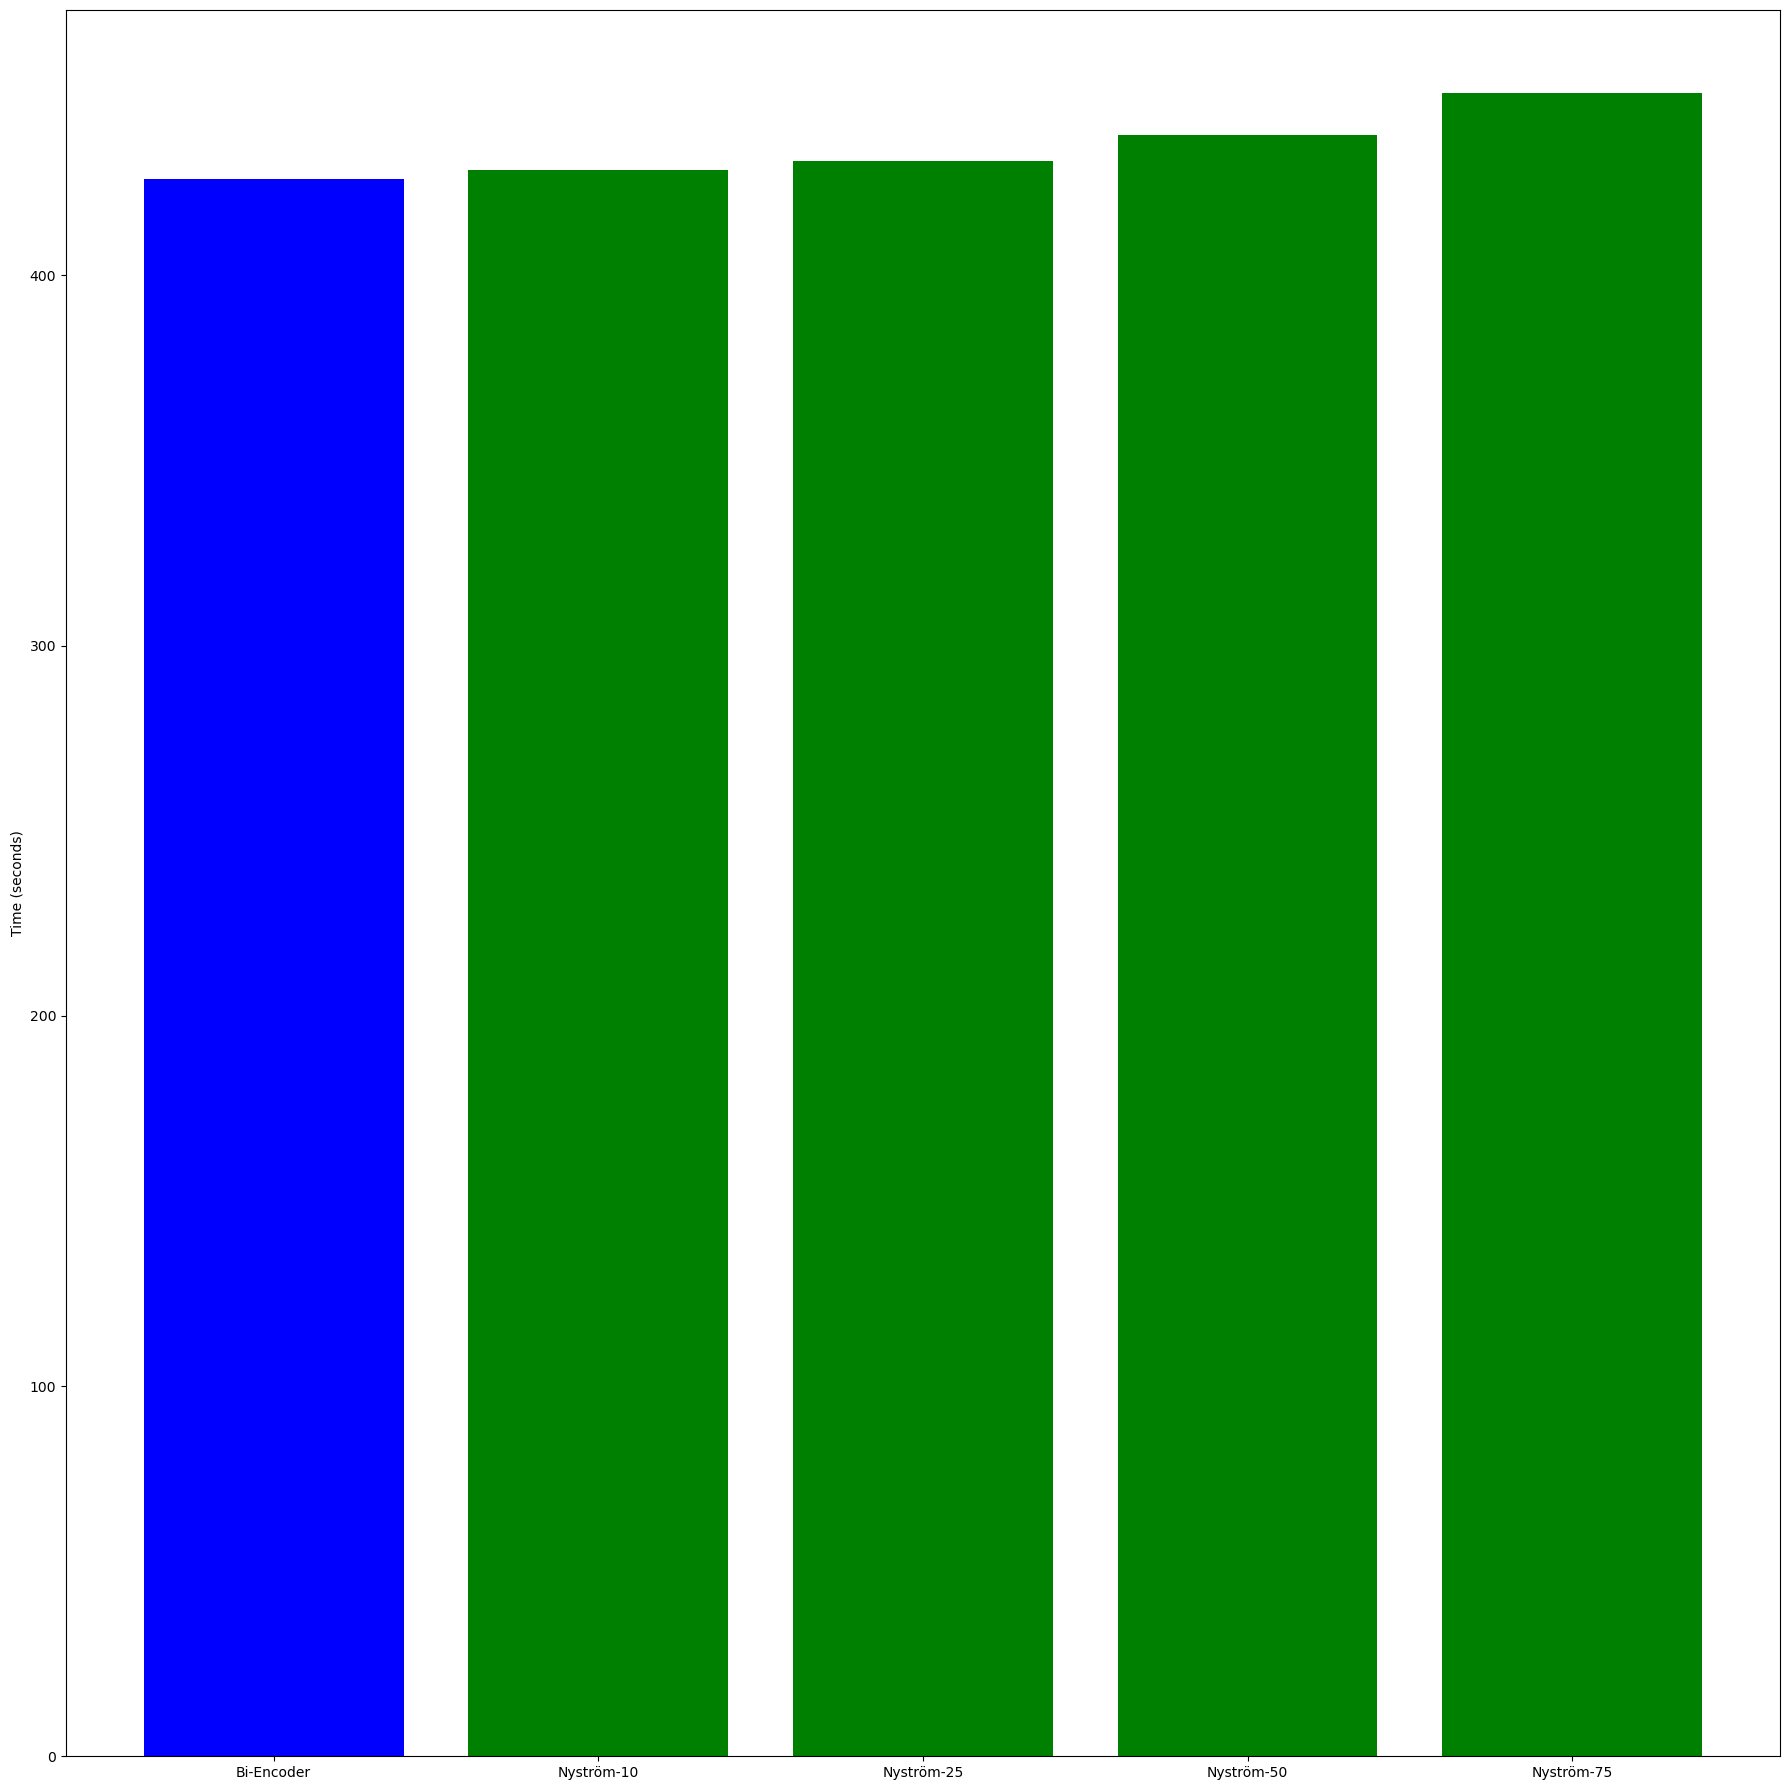

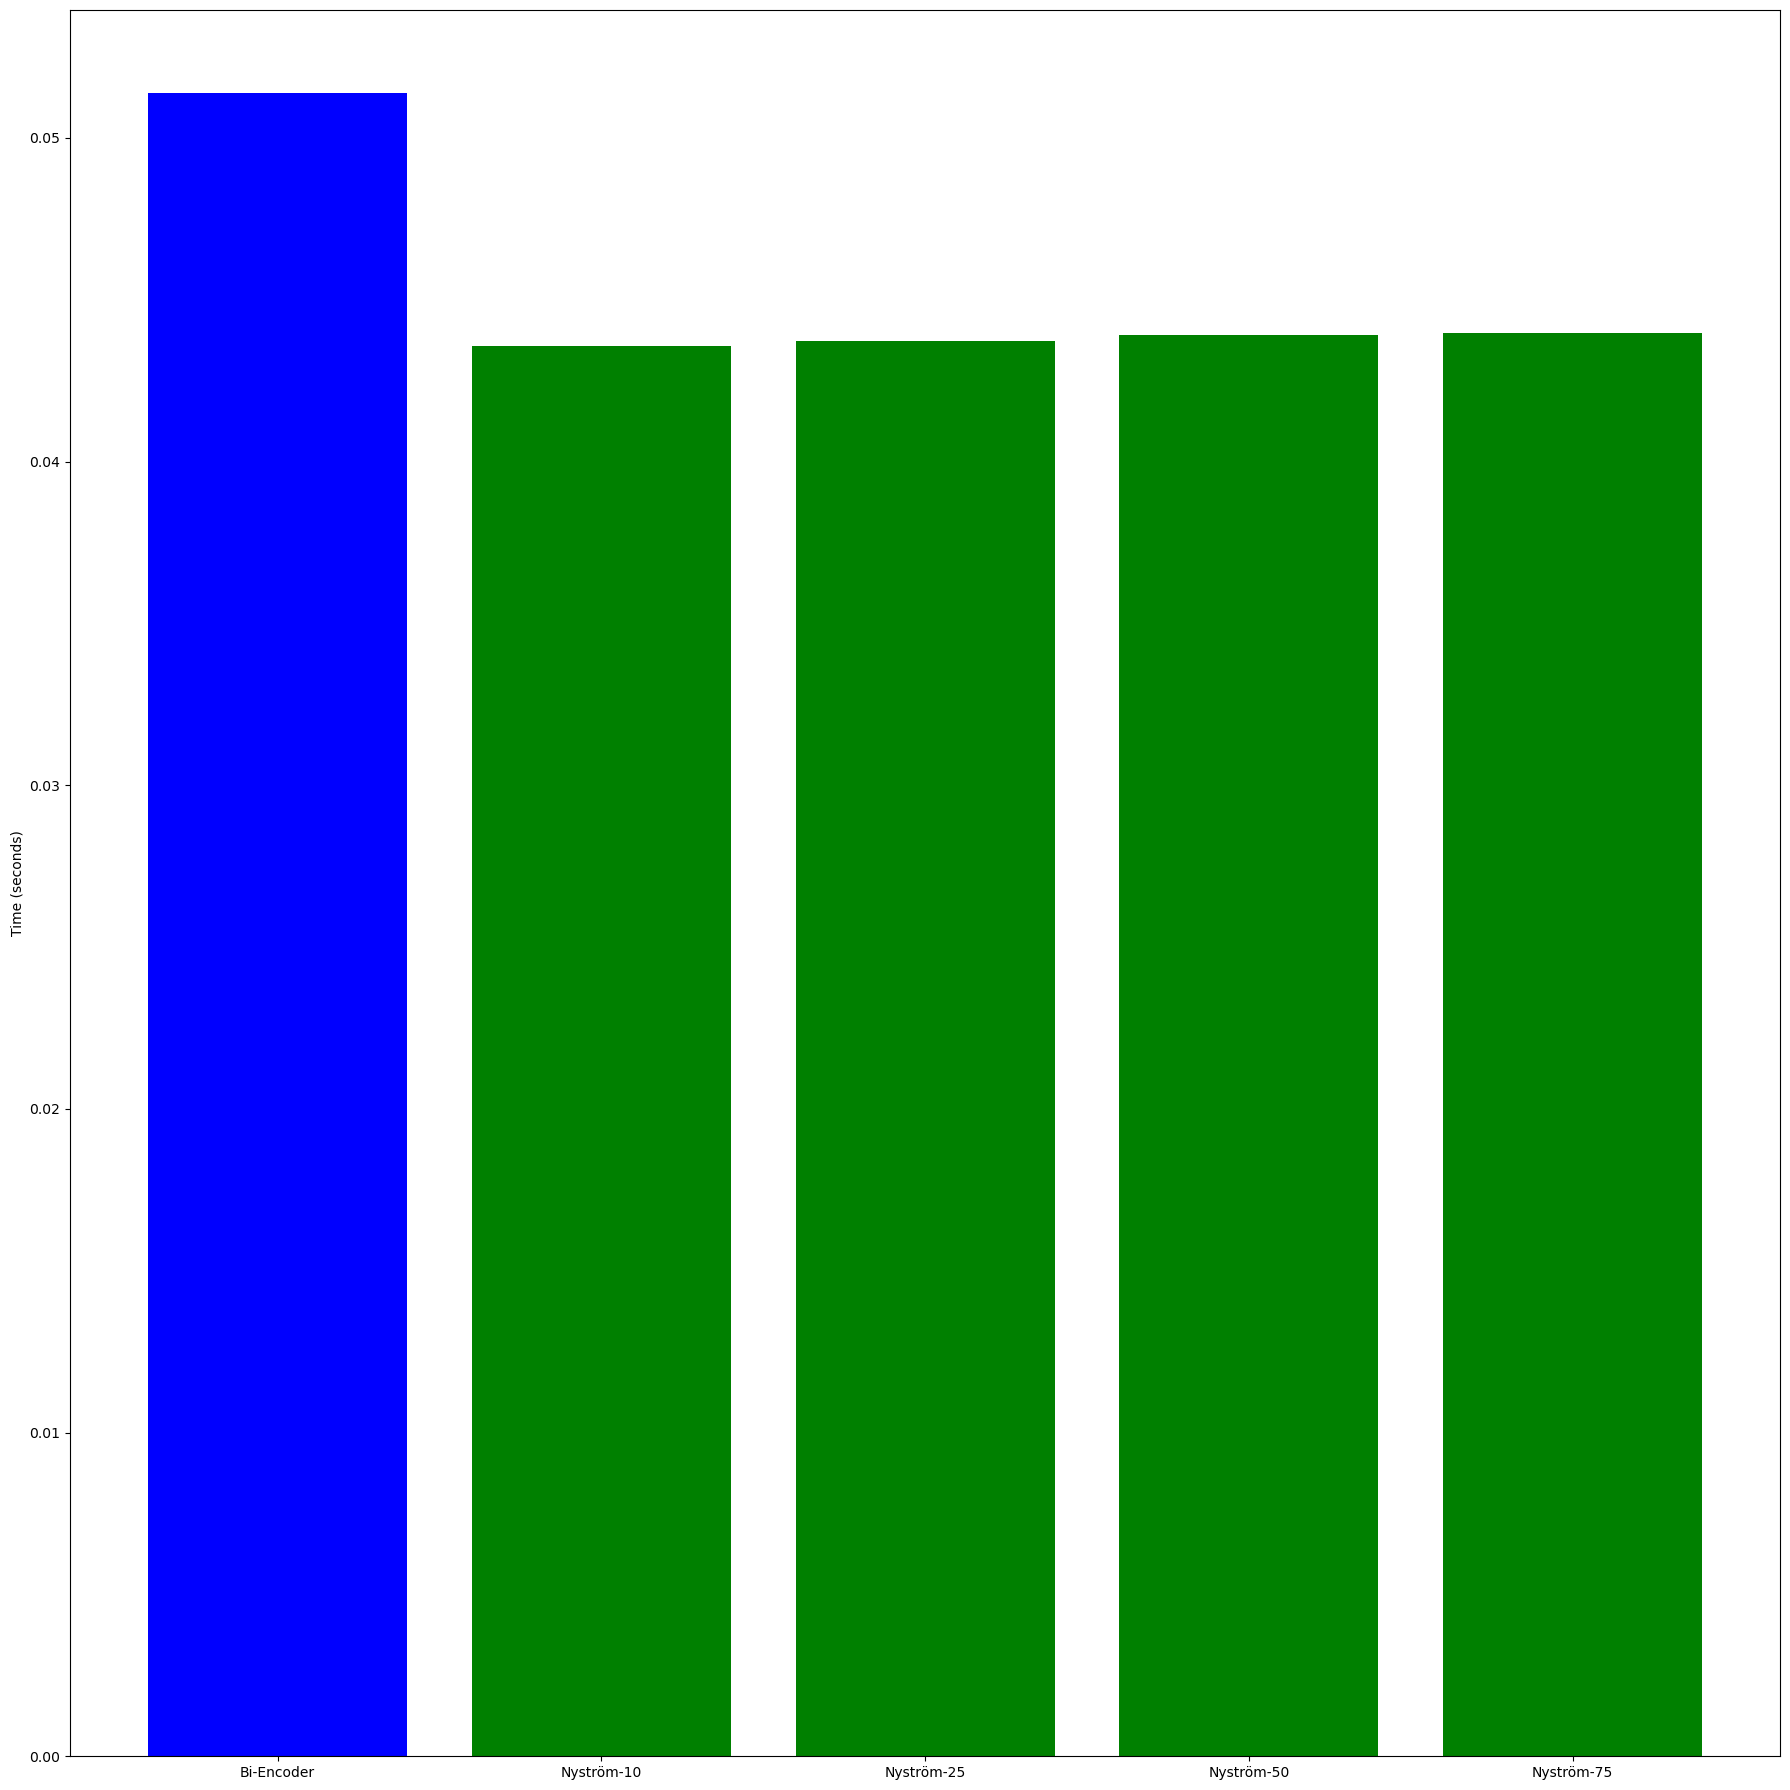

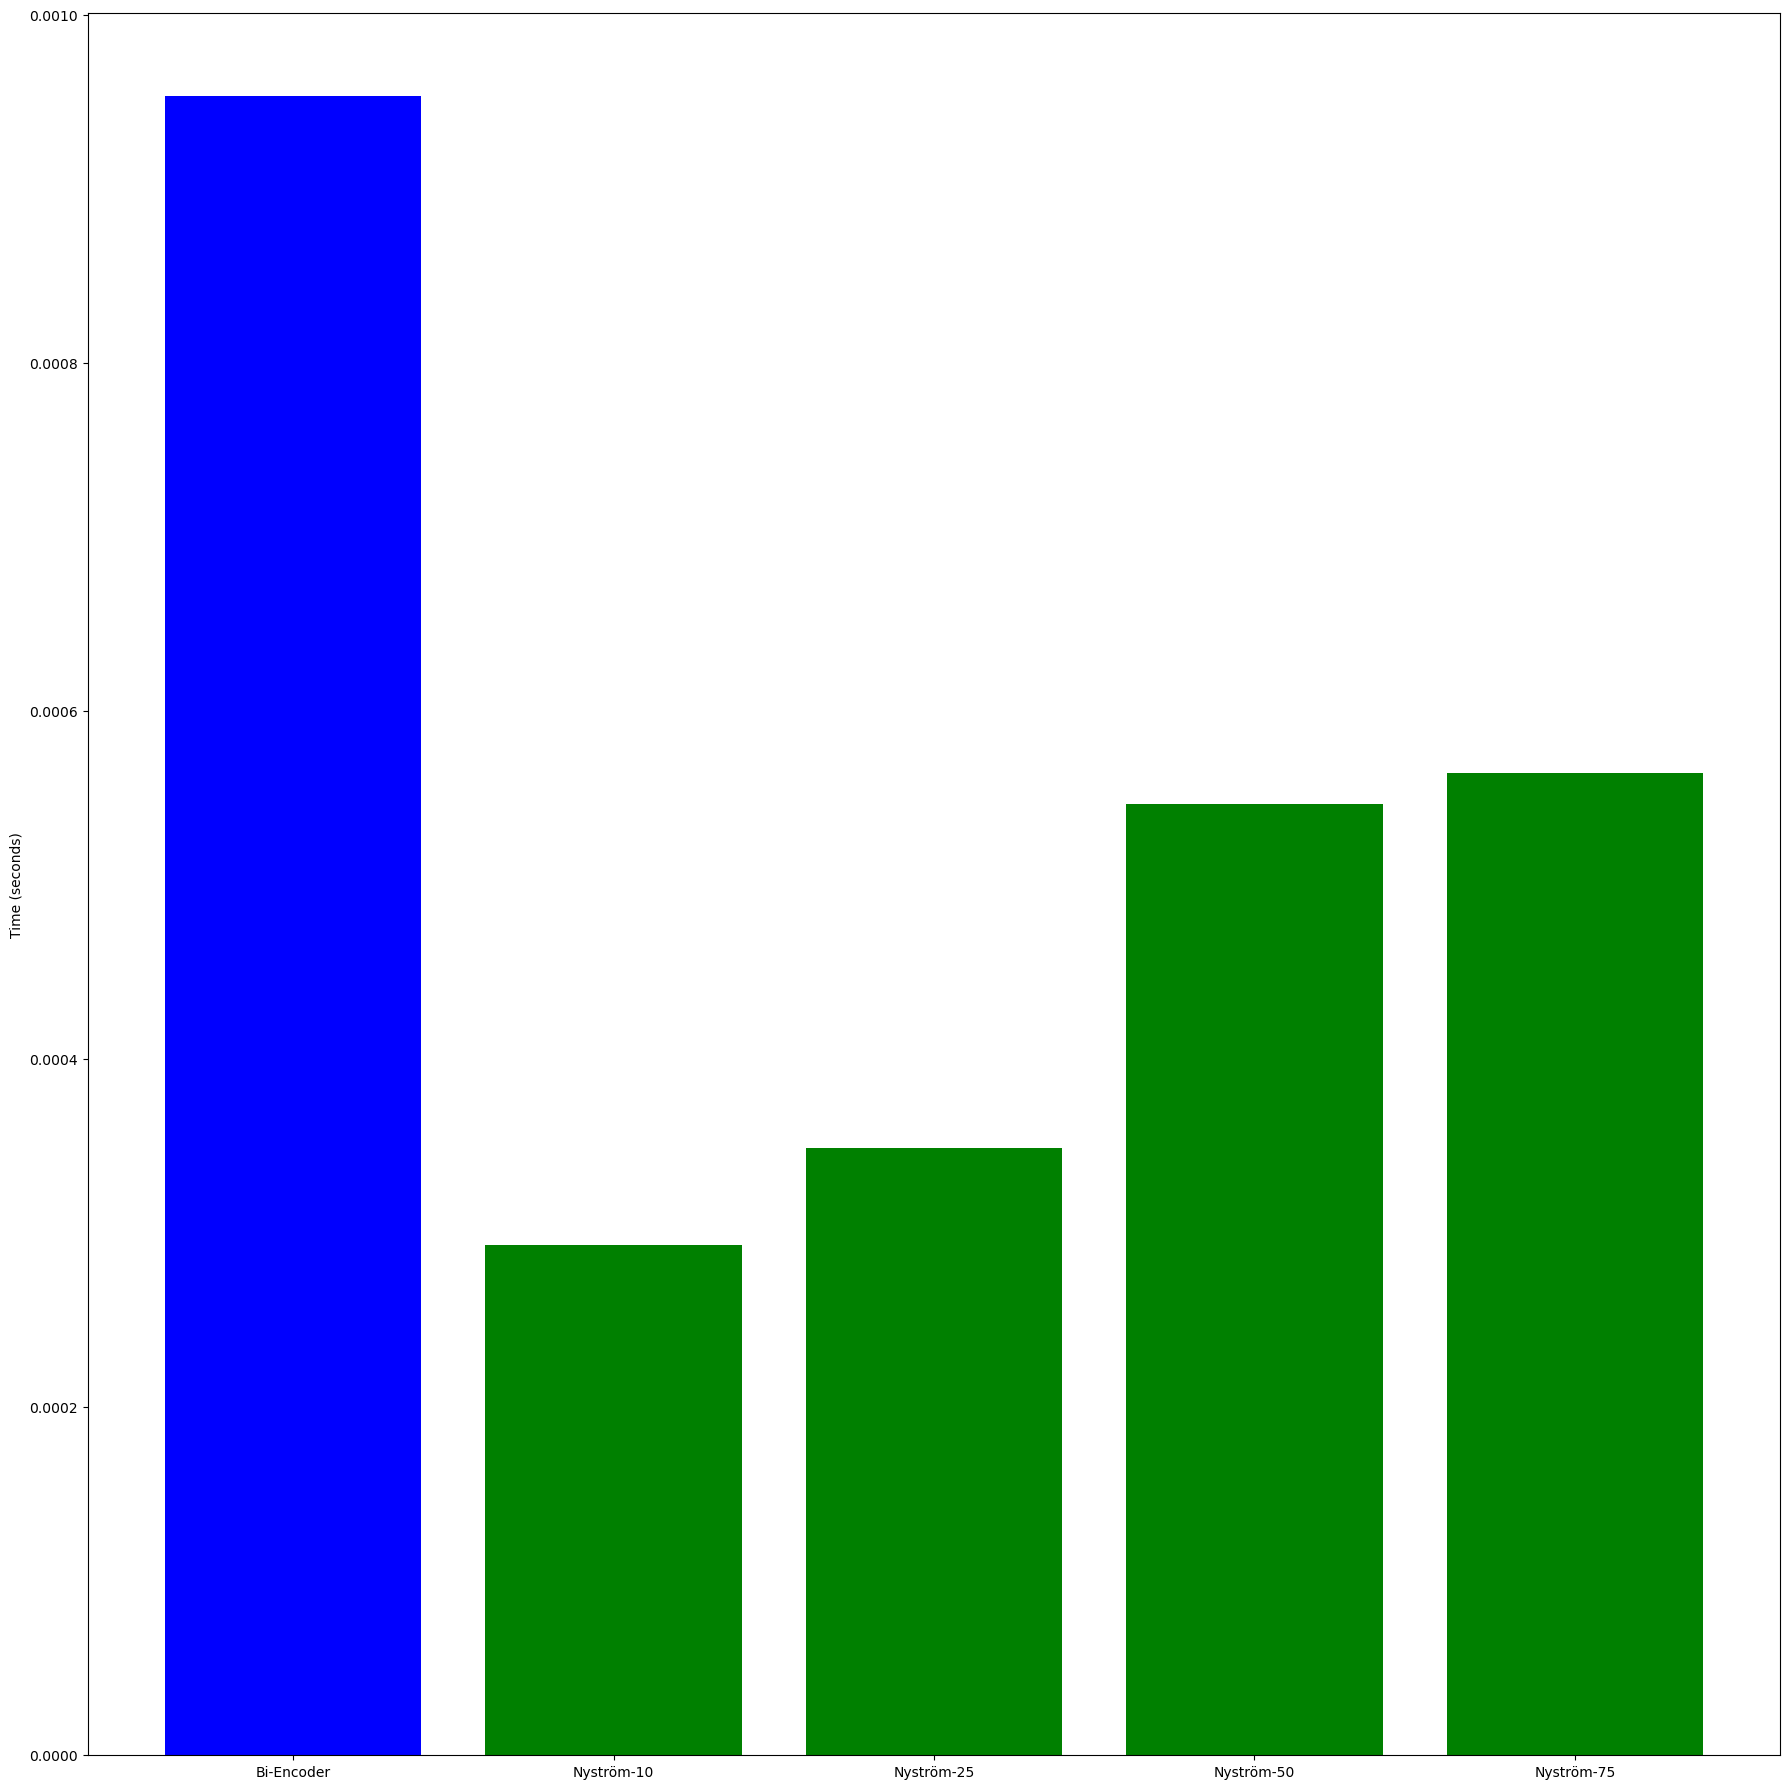

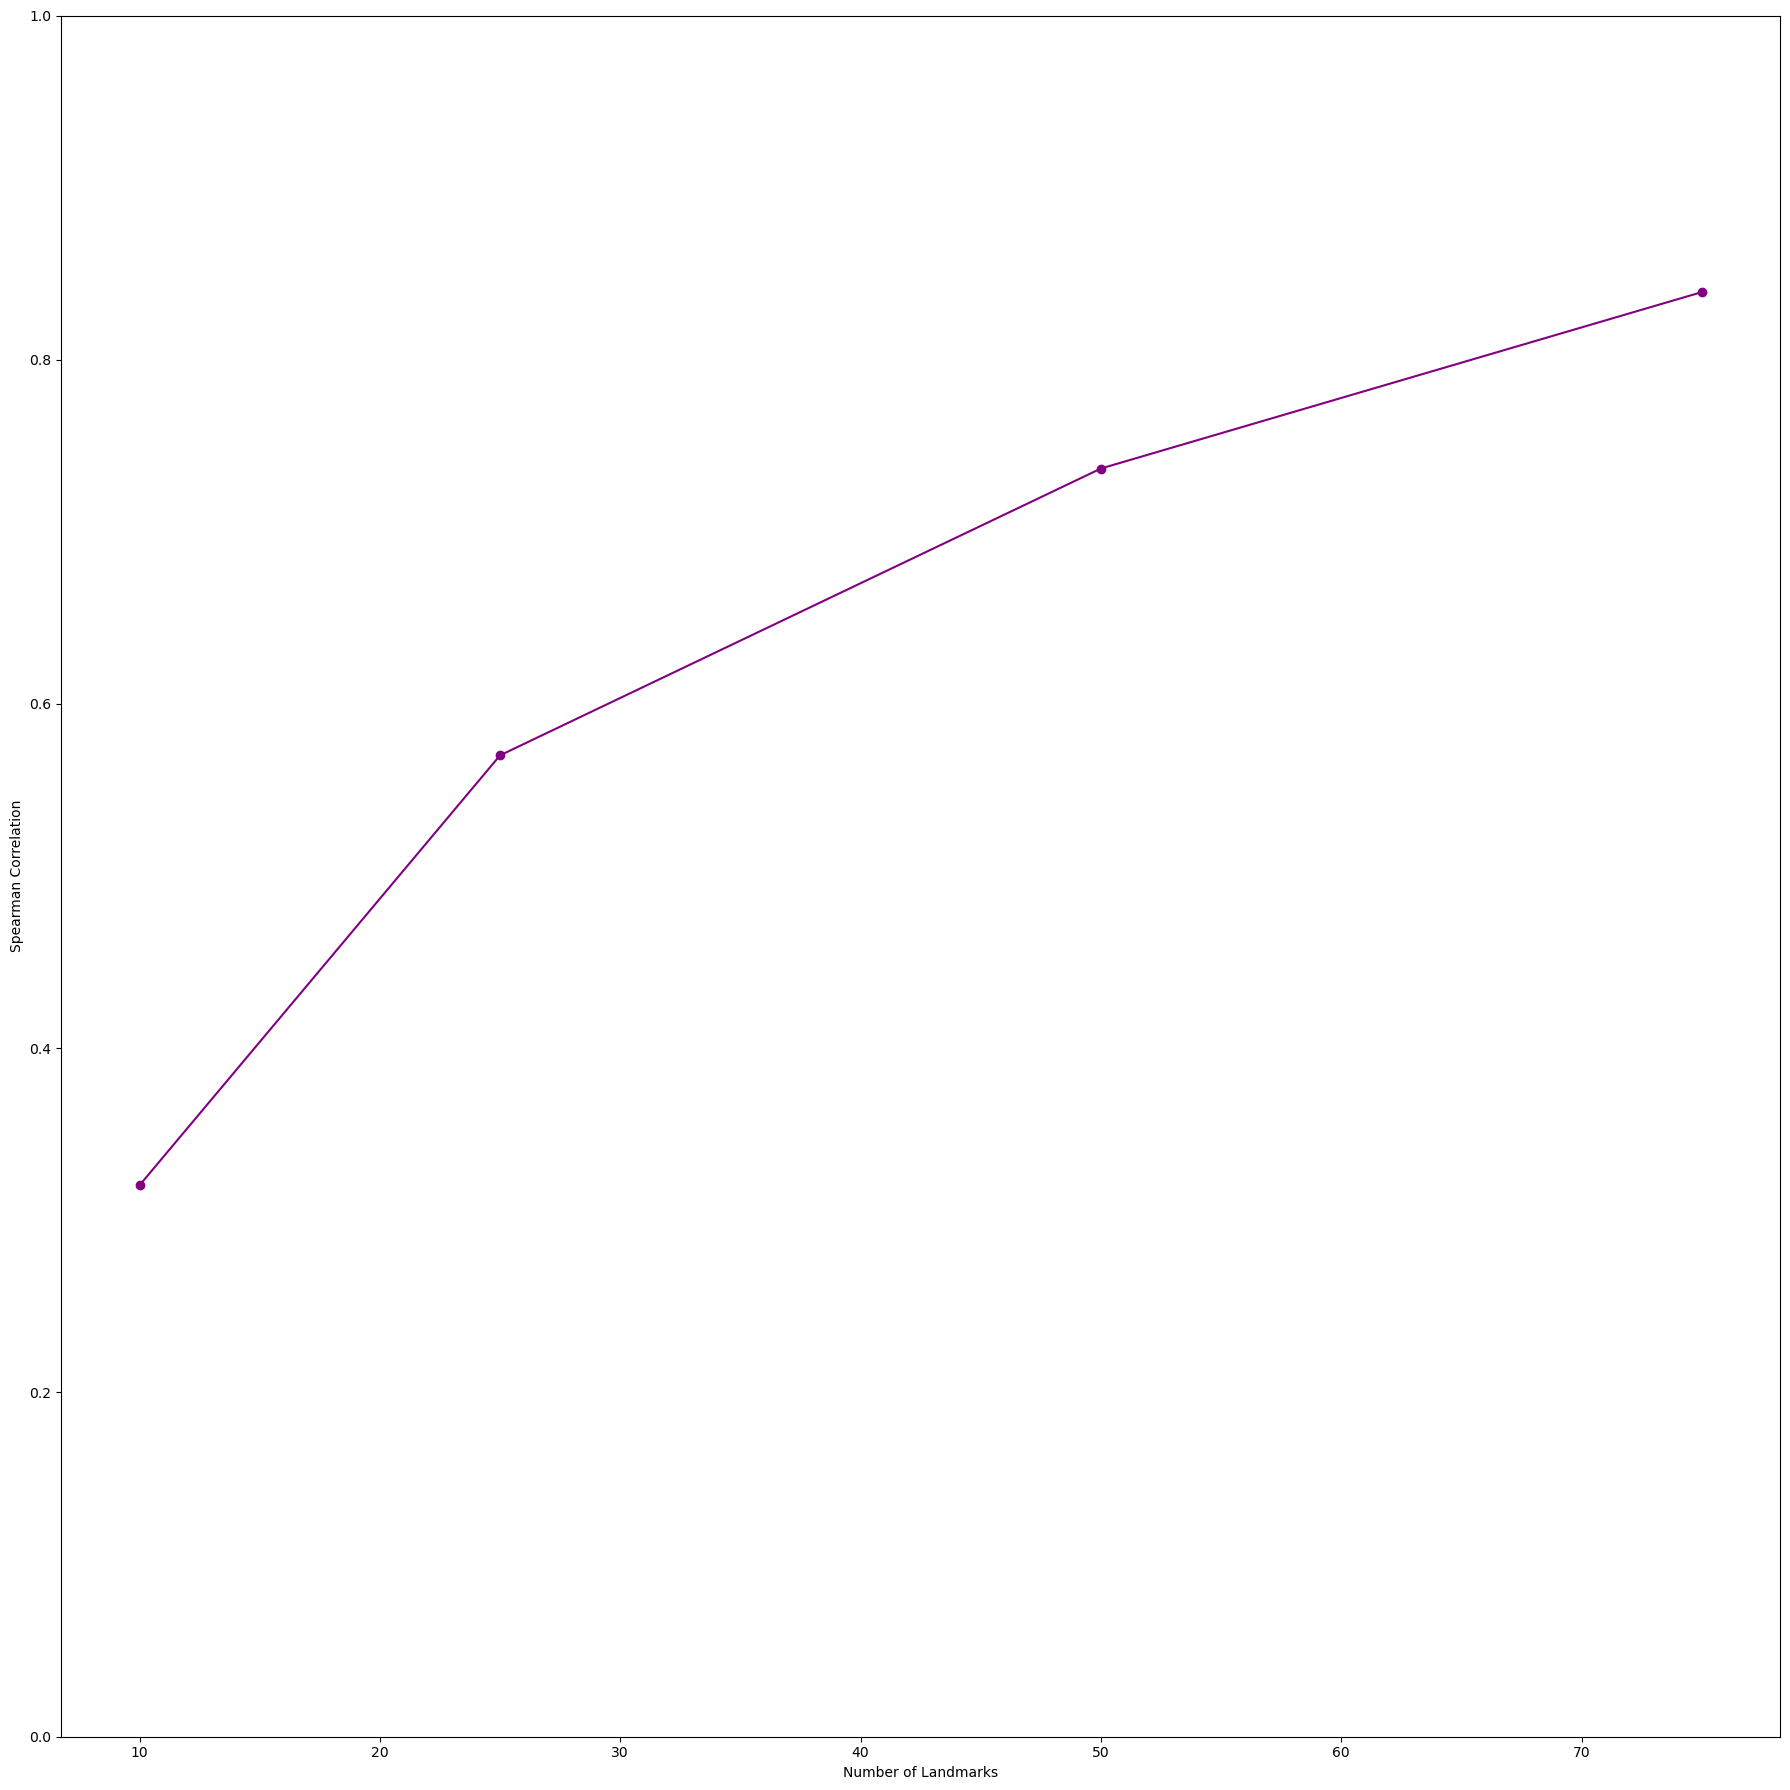

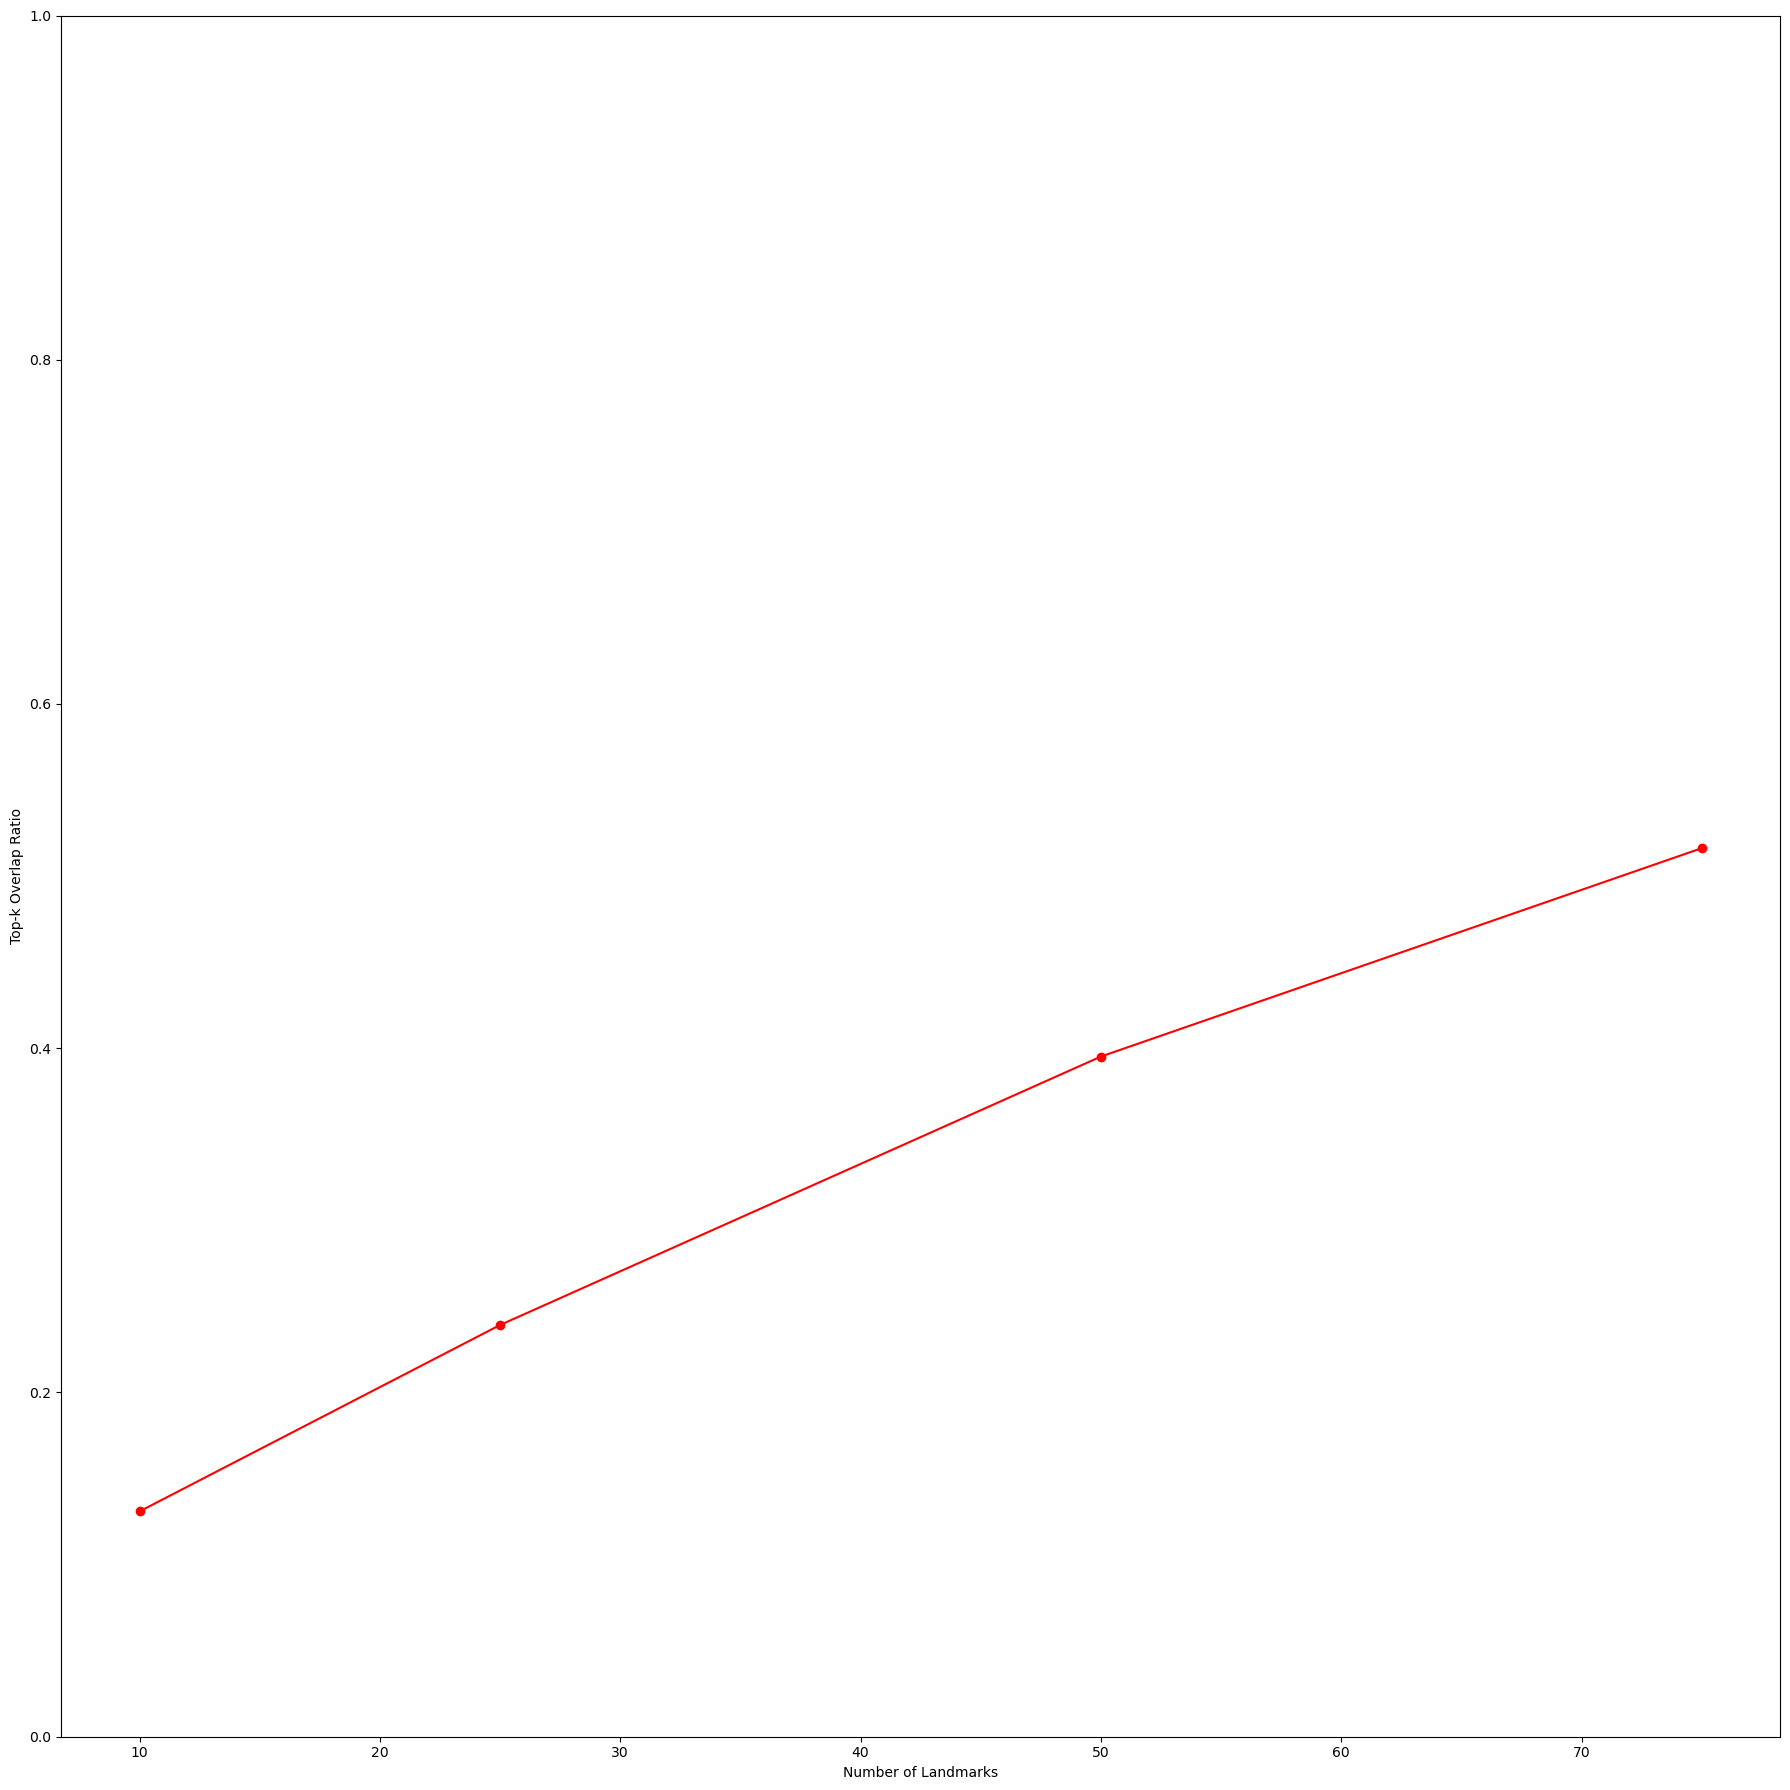

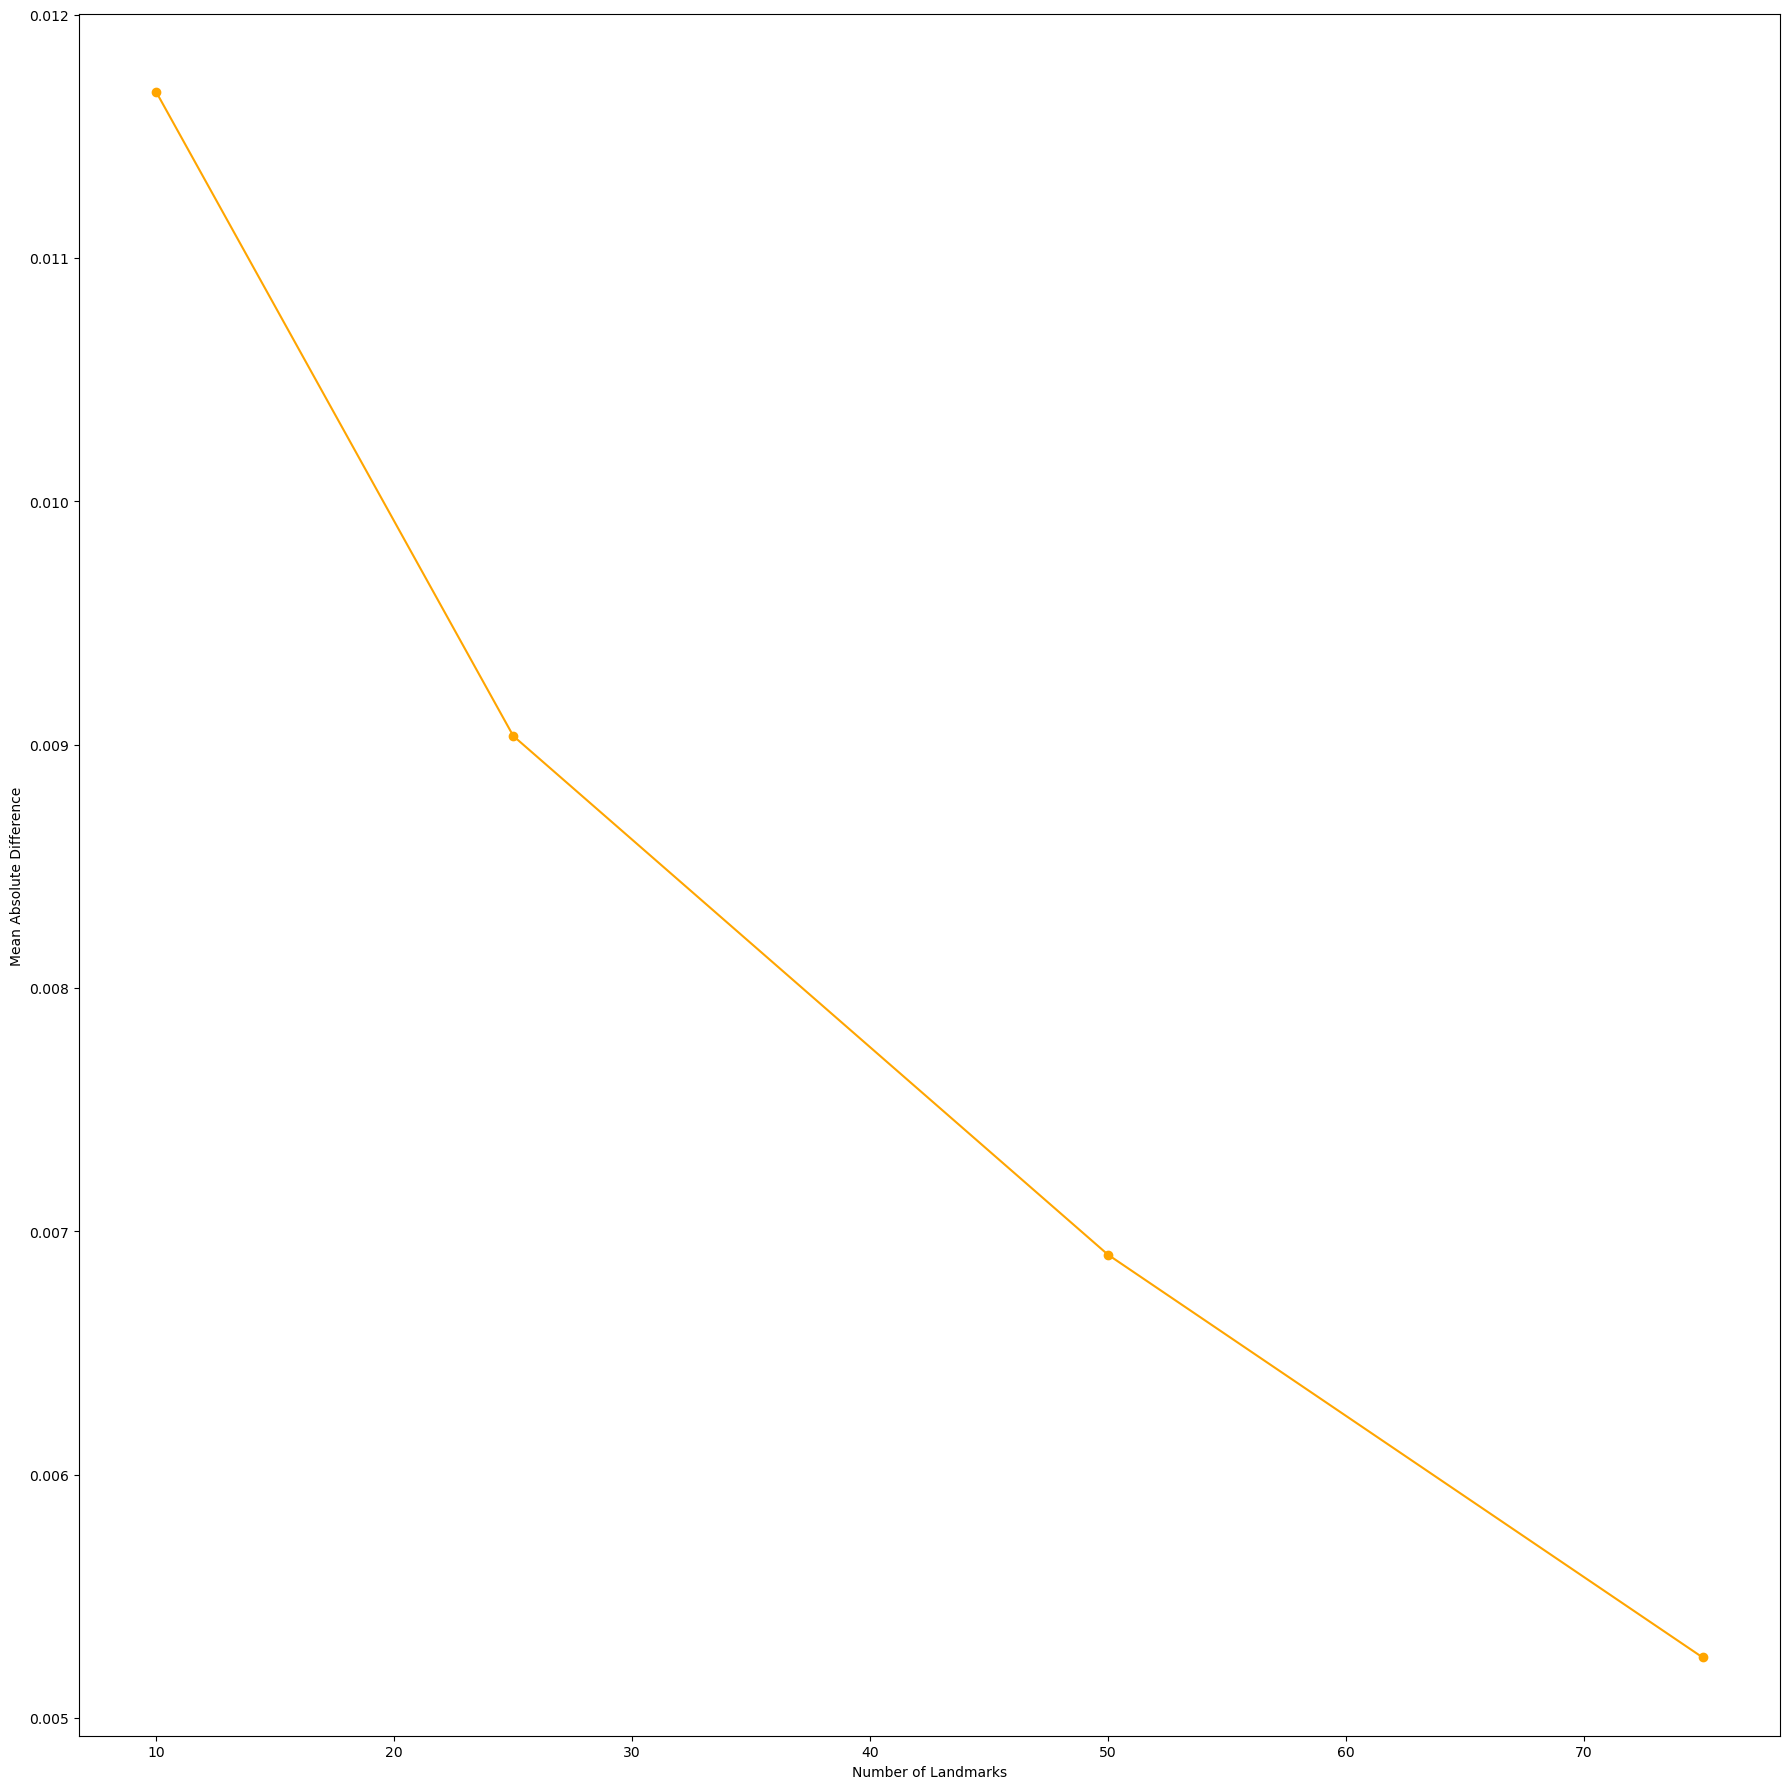

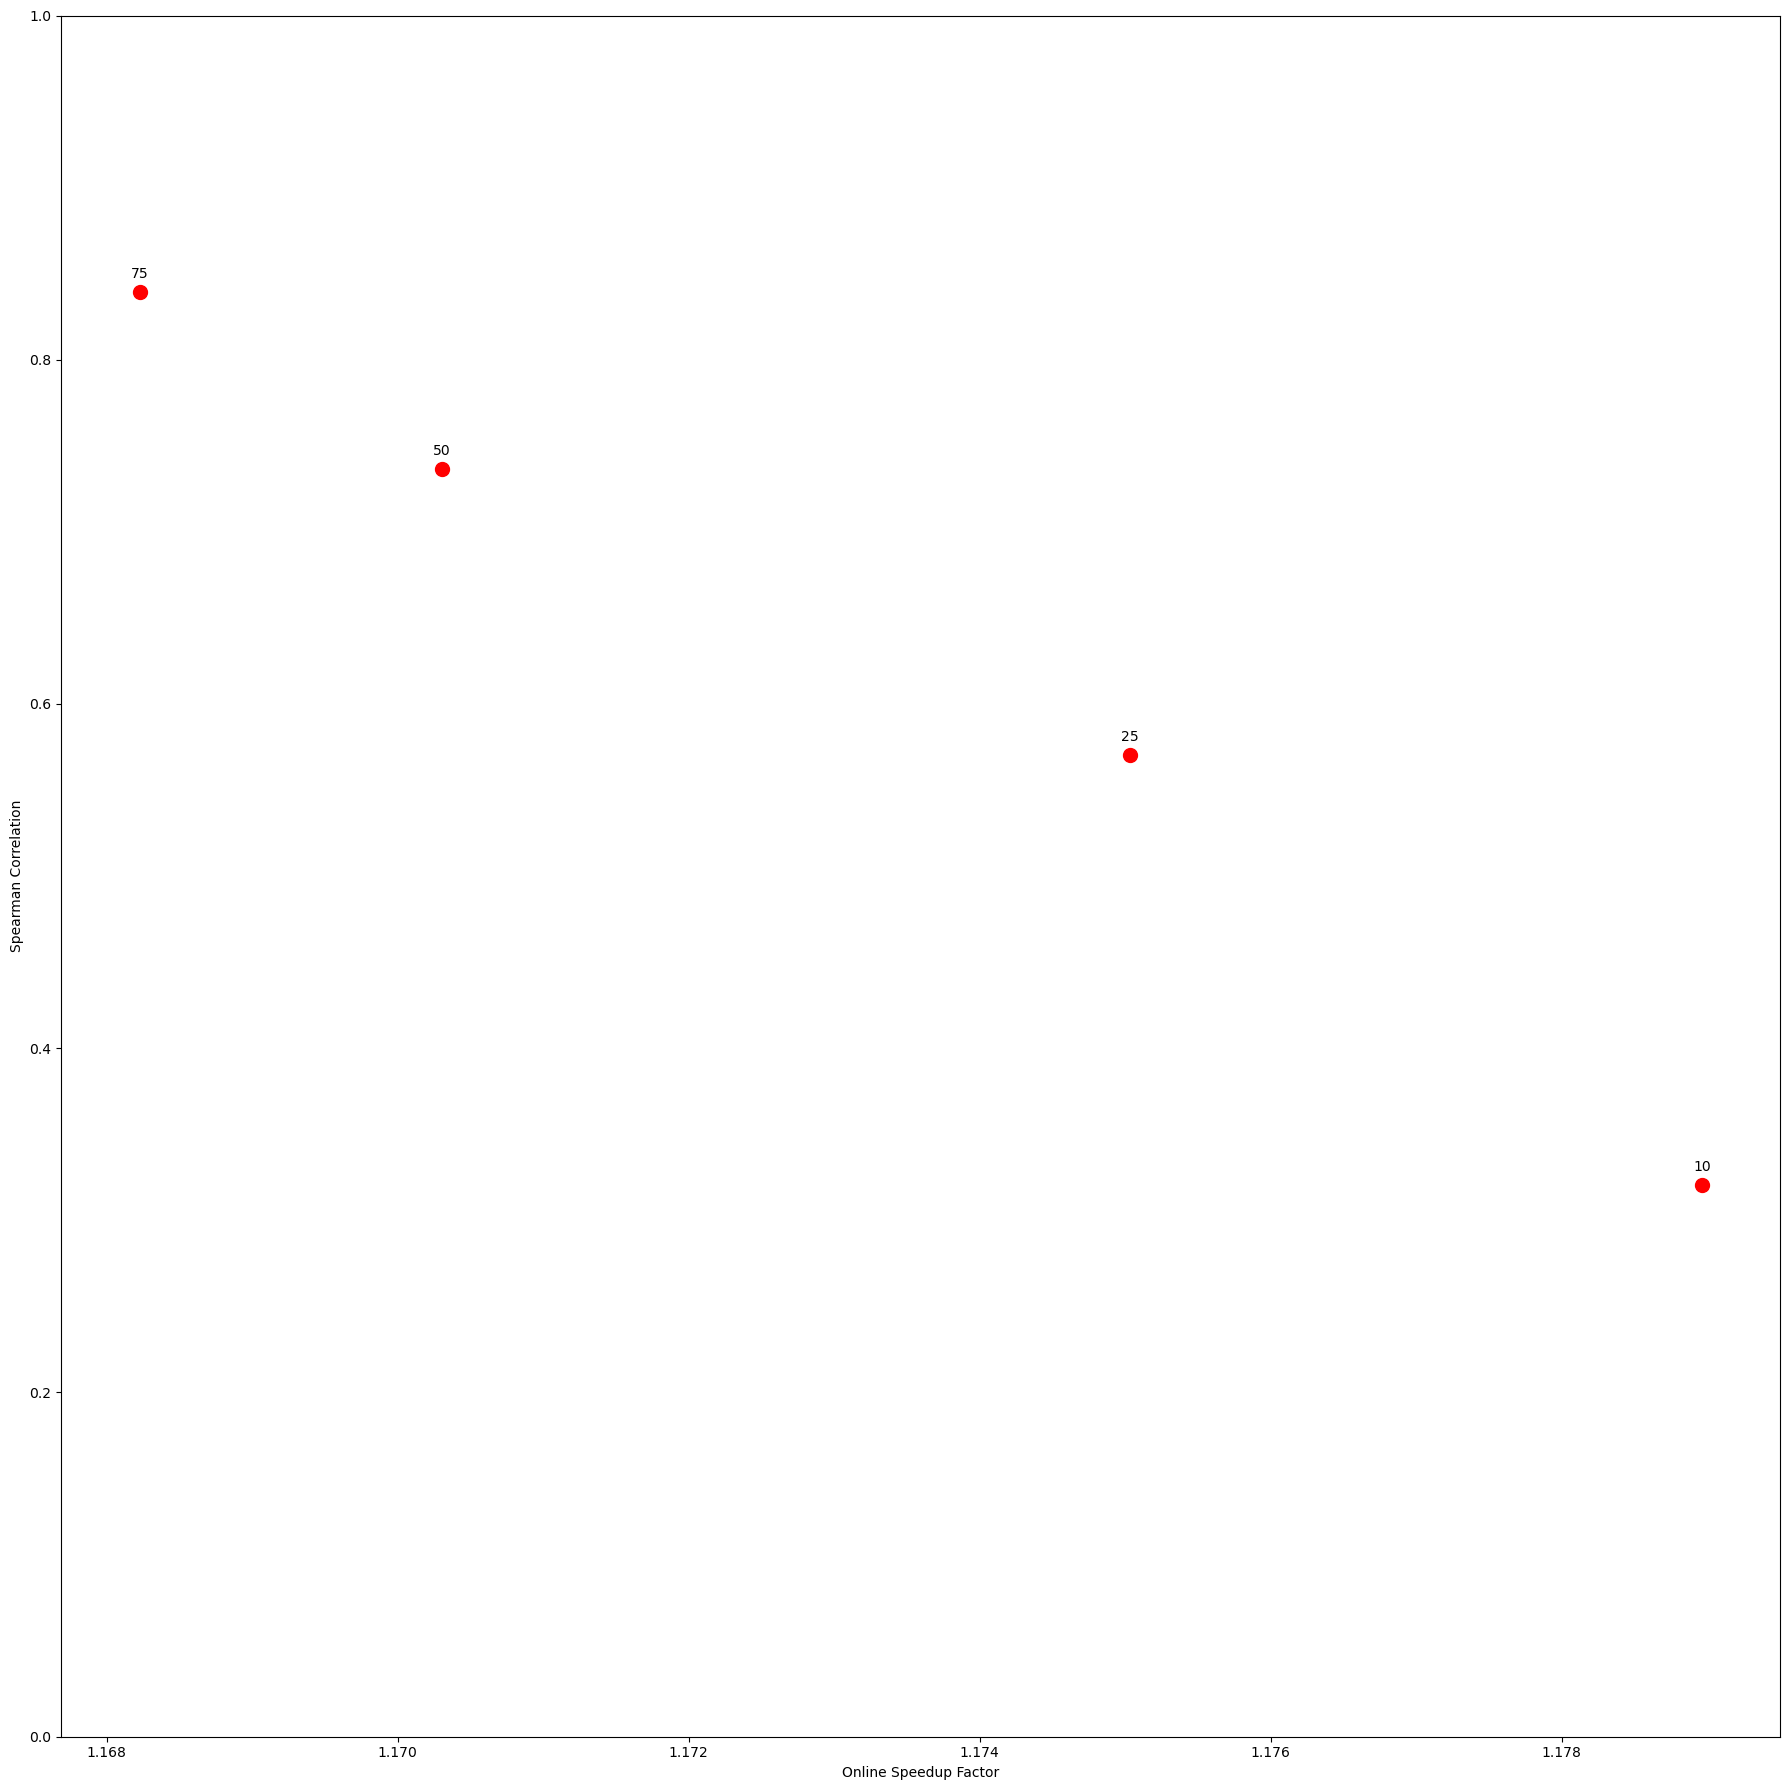

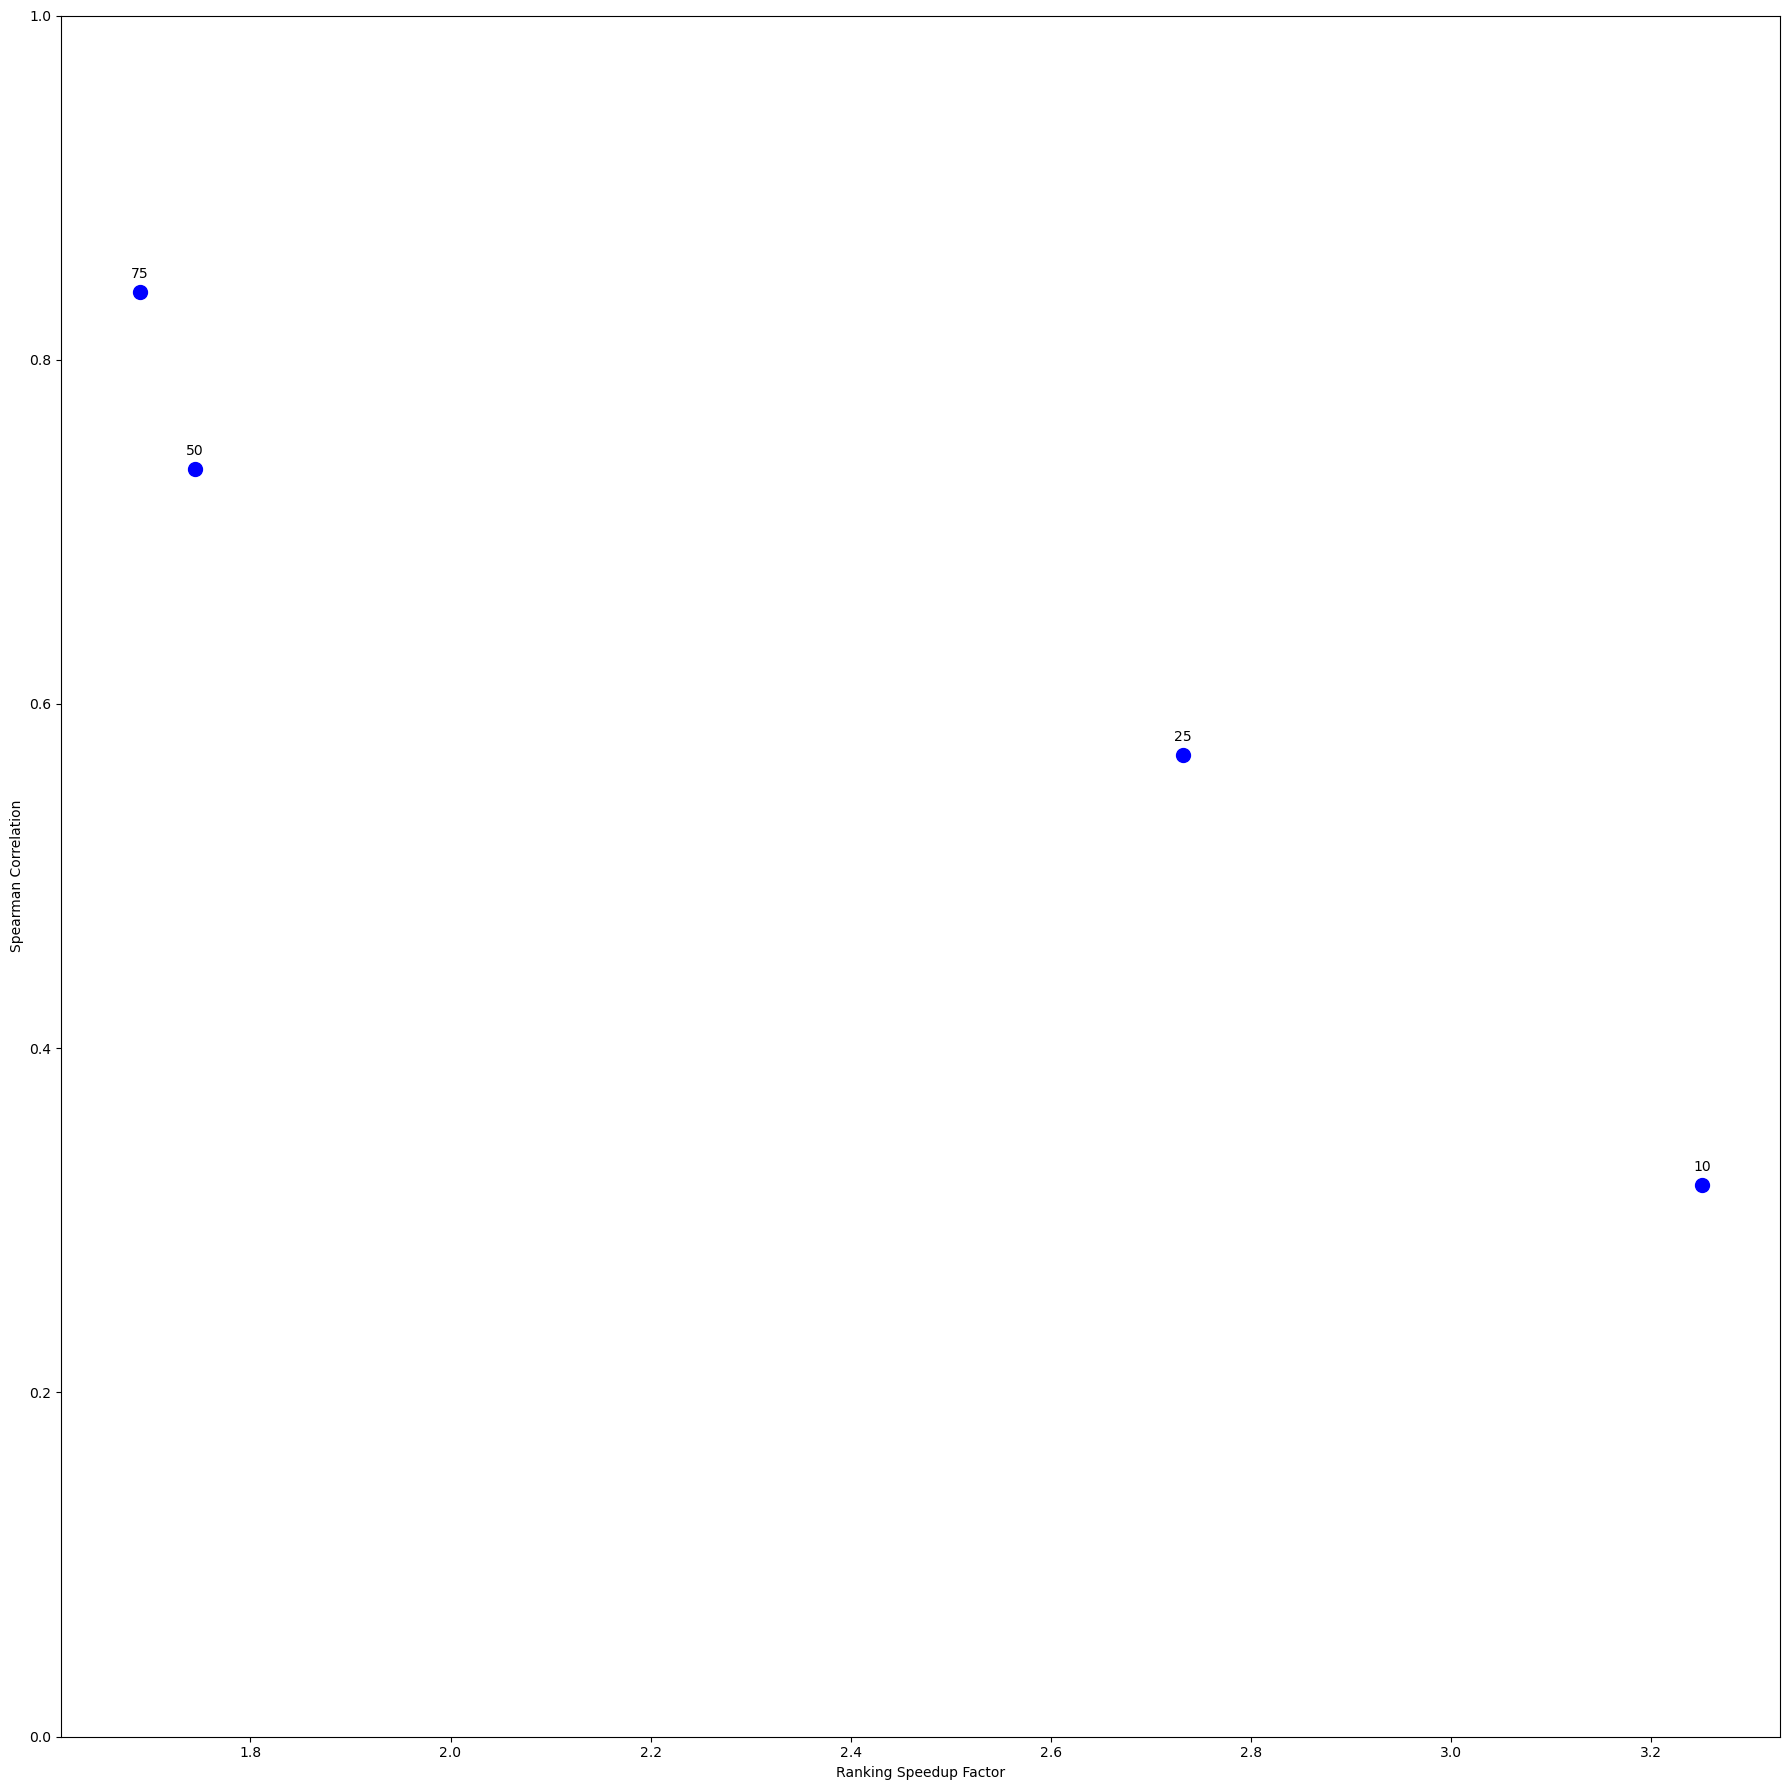


=== OVERALL SUMMARY ===
Dataset: 10000 documents, 10000 queries

Bi-Encoder Performance:
  Total offline time: 426.1524 seconds
  Average online time (per query): 0.05138 seconds (includes query encoding)
  Average ranking time (per query): 0.00095 seconds (only ranking)
  Total online time (10000 queries): 513.83967 seconds
  Total ranking time (10000 queries): 9.53573 seconds

Nyström Performance by Landmark Count:

  Nyström with 10 landmarks:
    Total offline time: 428.4940 seconds
    Average online time (per query): 0.04358 seconds (includes query encoding)
    Average ranking time (per query): 0.00029 seconds (only ranking)
    Total online time (10000 queries): 435.84018 seconds
    Total ranking time (10000 queries): 2.93319 seconds
    Online speedup vs bi-encoder: 1.18x
    Ranking speedup vs bi-encoder: 3.25x
    Similarity to bi-encoder results:
      Spearman rank correlation: 0.3204
      Top-k overlap: 0.1309
      Mean absolute score difference: 0.0117
      Top-1 ma

In [ ]:
from sklearn.cluster import KMeans

# Optimized comparison of bi-encoder vs Nyström kernel approximation
# Computing document embeddings once and running bi-encoder only once per query

from scipy.linalg import det
import os
import gzip
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.linalg import pinv
from scipy.stats import spearmanr
import torch
from transformers import AutoTokenizer, AutoModel

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

class MSMARCOEvaluator:
    """
    Evaluator for comparing bi-encoder and Nyström kernel approximation
    with optimized timing and direct score comparison
    """
    def __init__(self, data_dir="files", model_name="sentence-transformers/all-MiniLM-L6-v2", device=None):
        # File paths
        self.data_dir = data_dir
        self.queries_path = os.path.join(data_dir, "docleaderboard-queries.tsv.gz")
        self.top100_path = os.path.join(data_dir, "docleaderboard-top100.tsv.gz")
        self.fulldocs_path = os.path.join(data_dir, "fulldocs.tsv.gz")
        
        # Set device (GPU if available, otherwise CPU)
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        # Data storage
        self.queries = {}  # query_id -> query_text
        self.documents = {}  # doc_id -> doc_text
        
        # Timing metrics
        self.timing = {
            'embedding': 0,  # Shared embedding time
            'query_embedding': 0,  # Query embedding time
            'biencoder': {
                'offline': 0, 
                'online': [],  # Includes query encoding
                'ranking': []   # Only ranking computation
            },
            'nystrom': {
                'offline': {}, 
                'online': {},   # Includes query encoding
                'ranking': {}   # Only ranking computation
            }
        }
        
        # Comparison metrics
        self.comparison_metrics = {}  # Will store metrics for different landmark counts
        
        # Load model and tokenizer
        print(f"Loading {model_name} model...")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.model.to(self.device)
        self.model.eval()  # Set model to evaluation mode
        
        # Document embeddings storage (shared between both methods)
        self.doc_embeddings = {}  # doc_id -> embedding
        self.query_embeddings = {}  # query_id -> embedding
        
        # Nyström-specific data (will be different for each landmark count)
        self.nystrom_data = {}  # num_landmarks -> data
        
        # Store bi-encoder results for each query
        self.biencoder_results = {}  # query_id -> results
    
    def load_data(self, max_queries=20, max_docs=100):
        """Load a subset of MS MARCO data"""
        print("Loading MS MARCO data...")
        
        # Load queries
        self._load_queries(max_queries)
        
        # Load documents 
        self._load_documents(max_docs)
        
        print(f"Loaded {len(self.queries)} queries and {len(self.documents)} documents")
        return len(self.queries) > 0 and len(self.documents) > 0
    
    def _load_queries(self, max_queries):
        """Load queries from file"""
        try:
            with gzip.open(self.queries_path, 'rt', encoding='utf-8') as f:
                for i, line in enumerate(f):
                    if i >= max_queries:
                        break
                    
                    parts = line.strip().split('\t')
                    if len(parts) >= 2:
                        query_id = parts[0]
                        query_text = parts[1]
                        self.queries[query_id] = query_text
            
            print(f"Loaded {len(self.queries)} queries")
        
        except Exception as e:
            print(f"Error loading queries: {e}")
    
    def _load_documents(self, max_docs):
        """Load or create document content"""
        try:
            # For MS MARCO, try to load real documents first
            docs_loaded = 0
            
            with gzip.open(self.top100_path, 'rt', encoding='utf-8') as f:
                # Extract document IDs from top100 file
                doc_ids = set()
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 3:
                        # Check if query is in our loaded queries
                        query_id = parts[0]
                        if query_id in self.queries:
                            doc_id = parts[2]  # Doc ID is in position 2
                            doc_ids.add(doc_id)
                            
                            # Limit number of docs
                            if len(doc_ids) >= max_docs:
                                break
            
            print(f"Found {len(doc_ids)} unique document IDs")
            
            # Create synthetic documents (in practice, you'd load real documents)
            for i, doc_id in enumerate(doc_ids):
                self.documents[doc_id] = f"This is a synthetic document {i} for id {doc_id}. " + \
                                        "It contains text that would normally come from the real MS MARCO dataset."
            
            print(f"Created {len(self.documents)} document entries")
        
        except Exception as e:
            print(f"Error loading documents: {e}")
            
            # Fallback: Create some dummy documents
            for i in range(max_docs):
                doc_id = f"D{i+1000000}"
                self.documents[doc_id] = f"This is a synthetic document {i} with ID {doc_id}."
            
            print(f"Created {len(self.documents)} fallback document entries")
    
    def encode_text(self, text, max_length=256):
        """Encode text using the pre-trained model"""
        # Tokenize
        inputs = self.tokenizer(
            text,
            max_length=max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        ).to(self.device)
        
        # Get embeddings
        with torch.no_grad():
            outputs = self.model(**inputs)
            
            # Mean pooling - use attention mask to ignore padding tokens
            token_embeddings = outputs.last_hidden_state
            attention_mask = inputs['attention_mask']
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
            embedding = torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
            
            # Normalize embedding
            embedding = torch.nn.functional.normalize(embedding, p=2, dim=1)
        
        return embedding[0].cpu().numpy()
    
    def encode_all_documents(self):
        """Encode all documents once for both methods"""
        print("SHARED PHASE: Encoding all documents (used by both methods)...")
        
        # Clear existing embeddings
        self.doc_embeddings = {}
        
        start_time = time.time()
        
        # Encode all documents
        for doc_id, doc_text in tqdm(self.documents.items(), desc="Encoding documents"):
            self.doc_embeddings[doc_id] = self.encode_text(doc_text)
        
        # Record shared embedding time
        encoding_time = time.time() - start_time
        self.timing['embedding'] = encoding_time
        
        print(f"Encoded {len(self.doc_embeddings)} documents in {encoding_time:.2f} seconds")
        print(f"Average time per document: {encoding_time / len(self.documents):.5f} seconds")

    def encode_all_queries(self):
        """Encode all queries once for both methods"""
        print("SHARED PHASE: Encoding all queries (used by both methods)...")
        
        self.query_embeddings = {}  # Initialize dictionary to store query embeddings
        
        start_time = time.time()
        
        # Encode all queries
        for query_id, query_text in tqdm(self.queries.items(), desc="Encoding queries"):
            self.query_embeddings[query_id] = self.encode_text(query_text)
        
        encoding_time = time.time() - start_time
        self.timing['query_embedding'] = encoding_time
        
        print(f"Encoded {len(self.query_embeddings)} queries in {encoding_time:.2f} seconds")
        print(f"Average time per query: {encoding_time / len(self.queries):.5f} seconds")
    
    def setup_biencoder(self):
        """Set up standard bi-encoder (OFFLINE phase)"""
        print("BIENCODER OFFLINE PHASE: Nothing to do (embeddings already computed)")
        
        # No additional offline processing needed for bi-encoder
        # Just account for the embedding time in the offline time
        self.timing['biencoder']['offline'] = 0  # Additional offline time (zero for bi-encoder)
    
    def setup_nystrom_approximation(self, num_landmarks=10, landmark_method='dpp'):
        """Set up Nyström kernel approximation (OFFLINE phase) with Greedy DPP landmark selection"""
        print(f"NYSTROM OFFLINE PHASE: Setting up with {num_landmarks} landmarks using Greedy DPP...")
        start_time = time.time()

        # 1. Get all document embeddings
        all_doc_ids = list(self.doc_embeddings.keys())
        doc_embeddings = np.array([self.doc_embeddings[doc_id] for doc_id in all_doc_ids])
        n_docs = len(all_doc_ids)

        # 2. Compute the full kernel matrix (if feasible, otherwise use a subset)
        K = np.dot(doc_embeddings, doc_embeddings.T)  # Gram matrix (n_docs × n_docs)

        # 3. Greedy DPP landmark selection
        landmark_indices = []
        remaining_indices = list(range(n_docs))

        # Initialize with the document with maximum norm (highest "quality")
        norms = np.linalg.norm(doc_embeddings, axis=1)
        first_landmark = np.argmax(norms)
        landmark_indices.append(first_landmark)
        remaining_indices.remove(first_landmark)

        # Greedily select landmarks to maximize determinant
        for _ in range(1, num_landmarks):
            best_idx = -1
            best_det = -np.inf

            for idx in remaining_indices:
                # Compute the determinant if we add this index
                candidate_set = landmark_indices + [idx]
                submatrix = K[np.ix_(candidate_set, candidate_set)]
                current_det = det(submatrix)

                if current_det > best_det:
                    best_det = current_det
                    best_idx = idx

            landmark_indices.append(best_idx)
            remaining_indices.remove(best_idx)

        # Get the selected landmark documents and embeddings
        landmark_docs = [all_doc_ids[idx] for idx in landmark_indices]
        landmark_embeddings = np.array([self.doc_embeddings[doc_id] for doc_id in landmark_docs])

        # 4. Compute W and its pseudoinverse
        W = np.dot(landmark_embeddings, landmark_embeddings.T)
        W_inv = np.linalg.pinv(W)  # shape: [num_landmarks, num_landmarks]

        # 5. Precompute document features: (doc_embeddings @ landmarks.T) @ W_inv
        doc_embeddings_matrix = np.array([self.doc_embeddings[doc_id] for doc_id in all_doc_ids])  # shape: [num_docs, dim]
        C = np.dot(doc_embeddings_matrix, landmark_embeddings.T)  # shape: [num_docs, num_landmarks]
        doc_features = np.dot(C, W_inv.T)  # shape: [num_docs, num_landmarks]

        # 6. Ensure contiguous memory layout for maximum BLAS speed
        doc_features = np.ascontiguousarray(doc_features)
        landmark_embeddings = np.ascontiguousarray(landmark_embeddings)

        # 7. Store all data for this landmark configuration
        self.nystrom_data[num_landmarks] = {
            'landmark_docs': landmark_docs,
            'landmark_embeddings': landmark_embeddings,
            'W_inv': W_inv,
            'doc_features': doc_features,
            'doc_ids': np.array(all_doc_ids)
        }

        # Record offline time for this landmark count
        setup_time = time.time() - start_time
        self.timing['nystrom']['offline'][num_landmarks] = setup_time
        print(f"Nyström setup completed in {setup_time:.2f} seconds")
    
    def search_biencoder(self, query_id, top_k=10):
        """Search using standard bi-encoder approach (ONLINE phase)"""
        if not self.doc_embeddings:
            print("Document embeddings not available. Call encode_all_documents() first.")
            return None, 0, 0
        
        # Check if we already have results for this query
        if query_id in self.biencoder_results:
            return self.biencoder_results[query_id], 0, 0
        
        # Get precomputed query embedding
        query_embedding = self.query_embeddings[query_id]
        
        # Start timing (ONLINE phase - includes query encoding)
        start_time = time.time()
        
        # Compute similarities with all documents
        doc_ids = list(self.doc_embeddings.keys())
        doc_embeddings = np.array([self.doc_embeddings[doc_id] for doc_id in doc_ids])
        
        similarities = np.dot(doc_embeddings, query_embedding)
        
        # Sort by similarity and get top k
        sorted_indices = np.argsort(similarities)[::-1][:top_k]
        
        # End timing (total online time)
        online_time = time.time() - start_time + self.timing['query_embedding'] / len(self.queries)
        
        # Start timing for ranking only (without query encoding)
        ranking_start = time.time()
        _ = np.dot(doc_embeddings, query_embedding)
        sorted_indices = np.argsort(similarities)[::-1][:top_k]
        ranking_time = time.time() - ranking_start
        
        # Store timing
        self.timing['biencoder']['online'].append(online_time)
        self.timing['biencoder']['ranking'].append(ranking_time)
        
        # Prepare results
        results = {
            'query_id': query_id,
            'query_text': self.queries[query_id],
            'top_k_docs': [],
            'all_scores': dict(zip(doc_ids, similarities))
        }
        
        # Add top k results
        for idx in sorted_indices:
            doc_id = doc_ids[idx]
            score = float(similarities[idx])
            
            results['top_k_docs'].append({
                'doc_id': doc_id,
                'score': score,
                'text': self.documents[doc_id][:100] + "..."
            })
        
        # Store results
        self.biencoder_results[query_id] = results
        
        return results, online_time, ranking_time
    
    def search_nystrom(self, query_id, num_landmarks, top_k=10):
        """Optimized search using Nyström kernel approximation (ONLINE phase)"""
        if num_landmarks not in self.nystrom_data:
            print(f"Nyström data for {num_landmarks} landmarks not found. Call setup_nystrom_approximation() first.")
            return None, 0, 0
        
        data = self.nystrom_data[num_landmarks]
        
        # Get precomputed query embedding
        query_embedding = self.query_embeddings[query_id]
        
        # Start timing (ONLINE phase - includes query encoding)
        start_time = time.time()
        
        # Compute query features
        query_C = np.dot(query_embedding, data['landmark_embeddings'].T)
        
        # Compute scores
        similarities = np.dot(data['doc_features'], query_C)
        
        # Get top-k docs
        top_k_indices = np.argpartition(similarities, -top_k)[-top_k:]
        top_k_indices = top_k_indices[np.argsort(similarities[top_k_indices])[::-1]]
        
        # End timing (total online time)
        online_time = time.time() - start_time + self.timing['query_embedding'] / len(self.queries)
        
        # Start timing for ranking only (without query encoding)
        ranking_start = time.time()
        _ = np.dot(query_embedding, data['landmark_embeddings'].T)
        _ = np.dot(data['doc_features'], query_C)
        top_k_indices = np.argpartition(similarities, -top_k)[-top_k:]
        _ = top_k_indices[np.argsort(similarities[top_k_indices])[::-1]]
        ranking_time = time.time() - ranking_start
        
        # Store timing
        if num_landmarks not in self.timing['nystrom']['online']:
            self.timing['nystrom']['online'][num_landmarks] = []
            self.timing['nystrom']['ranking'][num_landmarks] = []
            
        self.timing['nystrom']['online'][num_landmarks].append(online_time)
        self.timing['nystrom']['ranking'][num_landmarks].append(ranking_time)
        
        # Prepare results
        results = {
            'query_id': query_id,
            'query_text': self.queries[query_id],
            'top_k_docs': [{
                'doc_id': data['doc_ids'][idx],
                'score': float(similarities[idx]),
                'text': self.documents[data['doc_ids'][idx]][:100] + "..."
            } for idx in top_k_indices],
            'all_scores': dict(zip(data['doc_ids'], similarities))
        }

        return results, online_time, ranking_time
    
    def compare_scores(self, biencoder_results, nystrom_results):
        """Compare scores between bi-encoder and Nyström methods"""
        # Get all document IDs
        doc_ids = set(biencoder_results['all_scores'].keys())
        
        # Get scores for each method
        be_scores = np.array([biencoder_results['all_scores'][doc_id] for doc_id in doc_ids])
        ny_scores = np.array([nystrom_results['all_scores'][doc_id] for doc_id in doc_ids])
        
        # Calculate score differences
        abs_diff = np.abs(be_scores - ny_scores)
        mean_abs_diff = np.mean(abs_diff)
        max_abs_diff = np.max(abs_diff)
        
        # Calculate relative differences
        # Avoid division by zero
        be_abs = np.abs(be_scores)
        valid_indices = be_abs > 1e-10
        rel_diff = np.zeros_like(abs_diff)
        rel_diff[valid_indices] = abs_diff[valid_indices] / be_abs[valid_indices]
        mean_rel_diff = np.mean(rel_diff)
        
        # Calculate rank correlation (Spearman)
        corr, _ = spearmanr(be_scores, ny_scores)
        
        # Calculate top-k overlap
        k = min(10, len(biencoder_results['top_k_docs']))
        be_top_k = set(doc['doc_id'] for doc in biencoder_results['top_k_docs'][:k])
        ny_top_k = set(doc['doc_id'] for doc in nystrom_results['top_k_docs'][:k])
        overlap = len(be_top_k.intersection(ny_top_k)) / k
        
        # Calculate top-1 match
        top1_match = biencoder_results['top_k_docs'][0]['doc_id'] == nystrom_results['top_k_docs'][0]['doc_id']
        
        return {
            'mean_abs_diff': mean_abs_diff,
            'max_abs_diff': max_abs_diff,
            'mean_rel_diff': mean_rel_diff,
            'spearman_corr': corr,
            'top_k_overlap': overlap,
            'top1_match': top1_match
        }
    
    def run_all_queries_with_biencoder(self, query_ids, top_k=10):
        """Run bi-encoder retrieval once for all queries and store results"""
        print(f"Running bi-encoder retrieval for {len(query_ids)} queries...")
        
        # Reset timing
        self.timing['biencoder']['online'] = []
        self.timing['biencoder']['ranking'] = []
        
        # Run bi-encoder for each query
        for query_id in tqdm(query_ids, desc="Bi-encoder retrieval"):
            self.search_biencoder(query_id, top_k)
    
    def compare_performance(self, landmark_counts, query_ids, top_k=10):
        """Compare performance between bi-encoder and Nyström for multiple landmark counts"""
        print("\nComparing bi-encoder and Nyström methods for multiple landmark counts...")
        
        # Initialize storage
        self.comparison_metrics = {count: [] for count in landmark_counts}
        
        # Encode all queries upfront
        self.encode_all_queries()
        
        # Setup bi-encoder
        self.setup_biencoder()
        
        # Step 1: Run bi-encoder retrieval once for all queries
        self.run_all_queries_with_biencoder(query_ids, top_k)
        
        # Step 2: Setup and test Nyström for each landmark count
        results_list = []
        
        for num_landmarks in landmark_counts:
            print(f"\nTesting with {num_landmarks} landmarks...")
            
            # Setup Nyström for this landmark count
            self.setup_nystrom_approximation(num_landmarks)
            
            # Reset online timing for this landmark count
            self.timing['nystrom']['online'][num_landmarks] = []
            self.timing['nystrom']['ranking'][num_landmarks] = []
            
            # Run Nyström for each query and compare with stored bi-encoder results
            for query_id in tqdm(query_ids, desc=f"Nyström-{num_landmarks} retrieval"):
                # Get bi-encoder results
                biencoder_results = self.biencoder_results[query_id]
                
                # Run Nyström search
                nystrom_results, _, _ = self.search_nystrom(query_id, num_landmarks, top_k)
                
                # Compare scores
                comparison = self.compare_scores(biencoder_results, nystrom_results)
                self.comparison_metrics[num_landmarks].append(comparison)
        
        # Calculate all metrics after running all queries
        return self._calculate_final_metrics(landmark_counts, query_ids)
    
    def _calculate_final_metrics(self, landmark_counts, query_ids):
        """Calculate and print all final metrics after running all queries"""
        results_list = []
        
        # Calculate bi-encoder metrics
        biencoder_avg_online = np.mean(self.timing['biencoder']['online'])
        biencoder_avg_ranking = np.mean(self.timing['biencoder']['ranking'])
        biencoder_total_offline = self.timing['embedding'] + self.timing['biencoder']['offline']
        
        for num_landmarks in landmark_counts:
            # Calculate average comparison metrics for this landmark count
            avg_metrics = {}
            for metric in self.comparison_metrics[num_landmarks][0].keys():
                avg_metrics[metric] = np.mean([m[metric] for m in self.comparison_metrics[num_landmarks]])
            
            # Calculate timing metrics
            nystrom_avg_online = np.mean(self.timing['nystrom']['online'][num_landmarks])
            nystrom_avg_ranking = np.mean(self.timing['nystrom']['ranking'][num_landmarks])
            nystrom_total_offline = self.timing['embedding'] + self.timing['nystrom']['offline'][num_landmarks]
            
            # Calculate speedups
            online_speedup = biencoder_avg_online / nystrom_avg_online if nystrom_avg_online > 0 else 0
            ranking_speedup = biencoder_avg_ranking / nystrom_avg_ranking if nystrom_avg_ranking > 0 else 0
            
            # Store results for this landmark count
            results_list.append({
                'biencoder': {
                    'offline': biencoder_total_offline,
                    'online_avg': biencoder_avg_online,
                    'ranking_avg': biencoder_avg_ranking,
                    'online_total': biencoder_avg_online * len(query_ids),
                    'ranking_total': biencoder_avg_ranking * len(query_ids)
                },
                'nystrom': {
                    'offline': nystrom_total_offline,
                    'online_avg': nystrom_avg_online,
                    'ranking_avg': nystrom_avg_ranking,
                    'online_total': nystrom_avg_online * len(query_ids),
                    'ranking_total': nystrom_avg_ranking * len(query_ids),
                    'landmarks': num_landmarks
                },
                'comparison': {
                    'online_speedup': online_speedup,
                    'ranking_speedup': ranking_speedup,
                    'metrics': avg_metrics
                }
            })
        
        return results_list
    
    def plot_results(self, results_list):
        """Plot performance comparison results for multiple configurations"""
        
        
        # Extract landmark counts and timing data
        landmark_counts = [result['nystrom']['landmarks'] for result in results_list]
        biencoder_offline = results_list[0]['biencoder']['offline']  # Same for all
        biencoder_online = results_list[0]['biencoder']['online_avg']  # Same for all
        biencoder_ranking = results_list[0]['biencoder']['ranking_avg']  # Same for all
        nystrom_offline = [result['nystrom']['offline'] for result in results_list]
        nystrom_online = [result['nystrom']['online_avg'] for result in results_list]
        nystrom_ranking = [result['nystrom']['ranking_avg'] for result in results_list]
        
        # Extract comparison metrics
        spearman_corrs = [result['comparison']['metrics']['spearman_corr'] for result in results_list]
        top_k_overlaps = [result['comparison']['metrics']['top_k_overlap'] for result in results_list]
        mean_abs_diffs = [result['comparison']['metrics']['mean_abs_diff'] for result in results_list]
        online_speedups = [result['comparison']['online_speedup'] for result in results_list]
        ranking_speedups = [result['comparison']['ranking_speedup'] for result in results_list]
        
        plt.tight_layout()
        plt.savefig(os.path.join('graphs', 'performance_comparison_dpp.png'))

        # Save individual plots without titles
        plt.figure(figsize=(18, 18))

        # Offline times
        plt.bar(range(len(landmark_counts) + 1), [biencoder_offline] + nystrom_offline, 
                color=['blue'] + ['green'] * len(landmark_counts))
        plt.xticks(range(len(landmark_counts) + 1), 
                ['Bi-Encoder'] + [f'Nyström-{n}' for n in landmark_counts])
        plt.ylabel('Time (seconds)')
        plt.tight_layout()
        plt.savefig(os.path.join('graphs', 'offline_times_dpp.png'))

        # Online times
        plt.figure(figsize=(18, 18))
        plt.bar(range(len(landmark_counts) + 1), [biencoder_online] + nystrom_online, 
                color=['blue'] + ['green'] * len(landmark_counts))
        plt.xticks(range(len(landmark_counts) + 1), 
                ['Bi-Encoder'] + [f'Nyström-{n}' for n in landmark_counts])
        plt.ylabel('Time (seconds)')
        plt.tight_layout()
        plt.savefig(os.path.join('graphs', 'online_times_dpp.png'))

        # Ranking times
        plt.figure(figsize=(18, 18))
        plt.bar(range(len(landmark_counts) + 1), [biencoder_ranking] + nystrom_ranking, 
                color=['blue'] + ['green'] * len(landmark_counts))
        plt.xticks(range(len(landmark_counts) + 1), 
                ['Bi-Encoder'] + [f'Nyström-{n}' for n in landmark_counts])
        plt.ylabel('Time (seconds)')
        plt.tight_layout()
        plt.savefig(os.path.join('graphs', 'ranking_times_dpp.png'))

        # Spearman Correlation
        plt.figure(figsize=(18, 18))
        plt.plot(landmark_counts, spearman_corrs, 'o-', color='purple')
        plt.xlabel('Number of Landmarks')
        plt.ylabel('Spearman Correlation')
        plt.ylim([0, 1])
        plt.tight_layout()
        plt.savefig(os.path.join('graphs', 'spearman_correlation_dpp.png'))

        # Top-k Overlap
        plt.figure(figsize=(18, 18))
        plt.plot(landmark_counts, top_k_overlaps, 'o-', color='red')
        plt.xlabel('Number of Landmarks')
        plt.ylabel('Top-k Overlap Ratio')
        plt.ylim([0, 1])
        plt.tight_layout()
        plt.savefig(os.path.join('graphs', 'topk_overlap_dpp.png'))

        # Mean Absolute Difference
        plt.figure(figsize=(18, 18))
        plt.plot(landmark_counts, mean_abs_diffs, 'o-', color='orange')
        plt.xlabel('Number of Landmarks')
        plt.ylabel('Mean Absolute Difference')
        plt.tight_layout()
        plt.savefig(os.path.join('graphs', 'mean_abs_diff_dpp.png'))

        # Online Speedup vs Quality Tradeoff
        plt.figure(figsize=(18, 18))
        plt.scatter(online_speedups, spearman_corrs, c='red', s=100)
        for i, n in enumerate(landmark_counts):
            plt.annotate(f"{n}", (online_speedups[i], spearman_corrs[i]), 
                        textcoords="offset points", xytext=(0,10), ha='center')
        plt.xlabel('Online Speedup Factor')
        plt.ylabel('Spearman Correlation')
        plt.ylim([0, 1])
        plt.tight_layout()
        plt.savefig(os.path.join('graphs', 'online_speedup_vs_quality_dpp.png'))

        # Ranking Speedup vs Quality Tradeoff
        plt.figure(figsize=(18, 18))
        plt.scatter(ranking_speedups, spearman_corrs, c='blue', s=100)
        for i, n in enumerate(landmark_counts):
            plt.annotate(f"{n}", (ranking_speedups[i], spearman_corrs[i]), 
                        textcoords="offset points", xytext=(0,10), ha='center')
        plt.xlabel('Ranking Speedup Factor')
        plt.ylabel('Spearman Correlation')
        plt.ylim([0, 1])
        plt.tight_layout()
        plt.savefig(os.path.join('graphs', 'ranking_speedup_vs_quality_dpp.png'))

        plt.show()

def main():
    # CUSTOMIZABLE PARAMETERS
    NUM_QUERIES = 10000    # Number of queries to evaluate
    NUM_DOCS = 10000      # Number of documents to use
    LANDMARK_COUNTS = [10, 25, 50, 75]  # Number of landmarks to test
    
    # Create evaluator
    evaluator = MSMARCOEvaluator()
    
    # Load data
    evaluator.load_data(max_queries=NUM_QUERIES, max_docs=NUM_DOCS)
    
    # Encode documents once for both methods
    evaluator.encode_all_documents()
    
    # Select test queries
    test_query_ids = list(evaluator.queries.keys())[:NUM_QUERIES]
    
    # Compare performance with different landmark counts
    results_list = evaluator.compare_performance(
        landmark_counts=LANDMARK_COUNTS,
        query_ids=test_query_ids,
        top_k=10
    )
    
    # Plot comparative results
    evaluator.plot_results(results_list)
    
    # Print overall summary
    print("\n=== OVERALL SUMMARY ===")
    print(f"Dataset: {NUM_DOCS} documents, {NUM_QUERIES} queries")
    
    # Bi-encoder timings (same for all landmark counts)
    be_offline = results_list[0]['biencoder']['offline']
    be_online_avg = results_list[0]['biencoder']['online_avg']
    be_ranking_avg = results_list[0]['biencoder']['ranking_avg']
    
    print("\nBi-Encoder Performance:")
    print(f"  Total offline time: {be_offline:.4f} seconds")
    print(f"  Average online time (per query): {be_online_avg:.5f} seconds (includes query encoding)")
    print(f"  Average ranking time (per query): {be_ranking_avg:.5f} seconds (only ranking)")
    print(f"  Total online time ({NUM_QUERIES} queries): {be_online_avg * NUM_QUERIES:.5f} seconds")
    print(f"  Total ranking time ({NUM_QUERIES} queries): {be_ranking_avg * NUM_QUERIES:.5f} seconds")
    
    print("\nNyström Performance by Landmark Count:")
    for i, num_landmarks in enumerate(LANDMARK_COUNTS):
        ny_offline = results_list[i]['nystrom']['offline']
        ny_online_avg = results_list[i]['nystrom']['online_avg']
        ny_ranking_avg = results_list[i]['nystrom']['ranking_avg']
        online_speedup = results_list[i]['comparison']['online_speedup']
        ranking_speedup = results_list[i]['comparison']['ranking_speedup']
        metrics = results_list[i]['comparison']['metrics']
        
        print(f"\n  Nyström with {num_landmarks} landmarks:")
        print(f"    Total offline time: {ny_offline:.4f} seconds")
        print(f"    Average online time (per query): {ny_online_avg:.5f} seconds (includes query encoding)")
        print(f"    Average ranking time (per query): {ny_ranking_avg:.5f} seconds (only ranking)")
        print(f"    Total online time ({NUM_QUERIES} queries): {ny_online_avg * NUM_QUERIES:.5f} seconds")
        print(f"    Total ranking time ({NUM_QUERIES} queries): {ny_ranking_avg * NUM_QUERIES:.5f} seconds")
        print(f"    Online speedup vs bi-encoder: {online_speedup:.2f}x")
        print(f"    Ranking speedup vs bi-encoder: {ranking_speedup:.2f}x")
        print("    Similarity to bi-encoder results:")
        print(f"      Spearman rank correlation: {metrics['spearman_corr']:.4f}")
        print(f"      Top-k overlap: {metrics['top_k_overlap']:.4f}")
        print(f"      Mean absolute score difference: {metrics['mean_abs_diff']:.4f}")
        print(f"      Top-1 match ratio: {metrics['top1_match']:.4f}")
    
    print("\nEvaluation complete!")

if __name__ == "__main__":
    main()